# zBEAMS: Application to Strong Lensing 

In [4]:
import os
os.getcwd()

'/mnt/zfsusers/hollowayp/zBEAMS/cmd_outputs'

In [2]:
from zbeamsfunctions_SL import likelihood_SL,likelihood_spec_contam_SL,likelihood_phot_contam_SL,likelihood_phot_SL,r_SL
from astropy.cosmology import LambdaCDM,FlatLambdaCDM,wCDM,FlatwCDM,w0waCDM
from zbeamsfunctions import mu_w,likelihood,likelihood_spec
from mcmcfunctions_SL_JAX import j_likelihood_SL,run_MCMC
from Lenstronomy_Cosmology import Background, LensCosmo
from mcmcfunctions import mcmc,mcmc_spec,mcmc_phot
from numpyro import distributions as dist, infer
from numpyro.infer import MCMC, NUTS, HMC
import matplotlib.patches as mpatches
from mcmcfunctions_SL import mcmc_SL
from scipy.stats import truncnorm
import matplotlib.lines as mlines
from cosmology_JAX import j_r_SL
from jax import random,grad, jit
import matplotlib.pyplot as pl
import jax.numpy as jnp
import jax_cosmo as jc
from tqdm import tqdm
import scipy.sparse
import pandas as pd
import arviz as az
import numpy as np
import importlib
import numpyro
import corner
import emcee
import glob
import sys
import jax

try:importlib.reload(sys.modules['mcmcfunctions_SL'])
except Exception as ex: print(f'Cannot reload: {ex}')
from mcmcfunctions_SL import mcmc_SL

Om_fid = 0.2;Ode_fid = 0.8;H0_fid = 70;w_fid = -1.0;wa_fid=0

cosmo_type = 'wCDM'
'''
Have shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further
demonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most
importantly including contamination + photometry.
'''

ModuleNotFoundError: No module named 'zbeamsfunctions_SL'

In [27]:
from importlib import reload  # Python 3.4+
reload(sys.modules['mcmcfunctions_SL_JAX'])
from mcmcfunctions_SL_JAX import j_likelihood_SL,run_MCMC
'''
Have shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further
demonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most
importantly including contamination + photometry.
'''

Importing Omega_k!=0 package
Importing Omega_k==0 package
Running Omega_k check


 67%|██████▋   | 141/212 [00:00<00:00, 885324.65it/s]


"\nHave shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further\ndemonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most\nimportantly including contamination + photometry.\n"

In [1]:
#zL_obs=db_in['zL_obs'];zS_obs=db_in['zS_obs'];r_obs=db_in['r_obs'];sigma_r_obs=db_in['sigma_r_obs'] #Making these up!!!

def generate_databases(N_obs,true_lens_frac,Percentage_error,cosmo_type,Om_fid,Ode_fid,H0_fid,w_fid,wa_fid,
                       verbose=False):
    if True: 
        print(f'Generating sample of {N_obs} systems, of which {100*true_lens_frac}% are true lenses '+\
              f'with {Percentage_error}% measurement error in a {cosmo_type} cosmology. This has '+\
              f'parameters Om:{Om_fid},Ode:{Ode_fid},H0:{H0_fid} and w:{w_fid}')
    repeat_0=True
    zL_obs_0 = []
    zS_obs_0 = []
    repeat_0=True
    while repeat_0:
        #Have changed the means of these from (0.5,1) to (0.4,0.8).
        zL_obs_i = truncnorm(-2,np.inf,loc=0.4,scale = 0.2).rvs(size=10*N_obs)
        zS_obs_i = truncnorm(-2,np.inf,loc=0.8,scale=0.4).rvs(size=10*N_obs)
        valid_bool = zL_obs_i<zS_obs_i
        zL_obs_i=zL_obs_i[valid_bool]
        zS_obs_i=zS_obs_i[valid_bool]
        if len(zL_obs_i)>=N_obs:
            zL_obs_0 = zL_obs_i[0:N_obs]
            zS_obs_0 = zS_obs_i[0:N_obs]
            assert len(zL_obs_0)==N_obs;assert len(zS_obs_0)==N_obs
            repeat_0=False

    '''
    NOTE: I think this may currently be incorrect - r_obs_0 should be measured from theta_E and vel_disp, rather than redshifts?
    '''
    if cosmo_type == 'w0CDM': r_obs_0 = r_SL(zL_obs_0,zS_obs_0,wCDM(H0=H0_fid,Om0=Om_fid,Ode0=Ode_fid,w0=w_fid))
    if cosmo_type == 'wCDM': r_obs_0 = r_SL(zL_obs_0,zS_obs_0,w0waCDM(H0=H0_fid,Om0=Om_fid,Ode0=Ode_fid,w0=w_fid,wa=wa_fid))
    if cosmo_type == 'FlatwCDM': r_obs_0 = r_SL(zL_obs_0,zS_obs_0,FlatwCDM(H0=H0_fid,Om0=Om_fid,w0=w_fid))
    if cosmo_type == 'LambdaCDM': r_obs_0 = r_SL(zL_obs_0,zS_obs_0,LambdaCDM(H0=H0_fid,Om0=Om_fid,Ode0=Ode_fid))
    if cosmo_type == 'FlatLambdaCDM': r_obs_0 = r_SL(zL_obs_0,zS_obs_0,FlatLambdaCDM(H0=H0_fid,Om0=Om_fid))

    #Breaking the measurements of r_obs if the object is contaminated:

    p_tau_0 = [np.random.choice([true_lens_frac]) for i in range(len(r_obs_0))]
    contaminated_bool_0 = [np.random.choice([0,1],p=[p_tau_0[i],1-p_tau_0[i]]) for i in range(len(r_obs_0))] #Lens = 0
    r_obs_0_contam = [r_obs_0[i] if contaminated_bool_0[i] == 0 else np.random.random() for i in range(len(r_obs_0))]

    '''
    Not sure what sigma_r_obs_0 should be if the object is not a lens?
    '''
    sigma_r_obs_0 = abs((Percentage_error/100)*r_obs_0)

    db_in = pd.DataFrame({'zL_obs':zL_obs_0,'zS_obs':zS_obs_0,
                        'sigma_zL_obs':Percentage_error/100,'sigma_zS_obs':Percentage_error/100,
                        'r_obs':r_obs_0,'r_obs_contam': r_obs_0_contam,
                        'sigma_r_obs':sigma_r_obs_0,'P_tau':p_tau_0,'FP_bool':contaminated_bool_0})
    db_filename = f'./databases/spectroscopic_db_{Percentage_error}perc_{N_obs}_samples_'+\
                  f'{int(np.round(100*db_in["P_tau"].mean()))}_true_cosmo_{cosmo_type}.csv' 
    print(db_filename)
    db_in.to_csv(db_filename)
    if verbose: print(db_in.describe())

N_lens = 100
for N_obs_i in 2**np.arange(7,18):
    generate_databases(N_obs=N_obs_i,
                       true_lens_frac=np.round(N_lens/N_obs_i,2),
                       Percentage_error=1,
                       cosmo_type='wCDM',
                       Om_fid=Om_fid,
                       Ode_fid=Ode_fid,
                       H0_fid=H0_fid,
                       w_fid=w_fid,
                       wa_fid=wa_fid,
                       verbose=False)

'''#Note, need the backslash after VARIABLE (in the addqueue...)
print('for VARIABLE in {50..100..2}
do
addqueue -c '5min' -m 3 -n 5 -s -q blackhole /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_100_samples_$VARIABLE\_true_cosmo_.csv True False wCDM 1000
done

for VARIABLE in 2 4 8 16 32 64 128 256 512 1024
do
addqueue -c '5min' -m 3 -n 5 -s -q blackhole /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_$VARIABLE\_samples_100_true.csv False False wCDM 1000
done
'''

NameError: name 'np' is not defined

In [37]:
generate_databases(N_obs=100000,
                       true_lens_frac=0.8,
                       Percentage_error=1,
                       cosmo_type='FlatLambdaCDM',
                       Om_fid=Om_fid,
                       Ode_fid=Ode_fid,
                       H0_fid=H0_fid,
                       w_fid=w_fid,
                       wa_fid=wa_fid,
                       verbose=False)

Generating sample of 100000 systems, of which 80.0% are true lenses with 1% measurement error in a FlatLambdaCDM cosmology. This has parameters Om:0.2,Ode:0.8,H0:70 and w:-1.0
./databases/spectroscopic_db_1perc_100000_samples_80_true_cosmo_FlatLambdaCDM.csv


In [128]:
#!addqueue -c '1hr' -m 5 -n 2x4 -s -q gpulong --gpus 2 /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_128_samples_80_true_cosmo_wCDM.csv False True wCDM 2000 10
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_64_samples_80_true_cosmo_wCDM.csv False True FlatLambdaCDM 2000
#!addqueue -c '1hr' -m 2 -n 1x2 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2
!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 10000

Disabling MPI - so only running 1 copy of your program.
Sending program's output to file: /mnt/users/hollowayp/python11_env/bin/python3.11-725522.out
Job submission complete.



In [124]:
'''
Question: Does the GPU thing run faster if I give it more cores (within 1 node)?
Answer: Giving 20GB on 1 node + 1 core was very slow on gpulong_5.
Variable improvement for giving 4x more cores in the same node (1x4 vs 1x1) => Wasn't 4x faster anyway.
-n 1x4 -m 5:  4m20, 7m, 5m
-n 1x1 -m 5:  5m30, 4m, 4m30
-n 1x1 -m 20: 5m20, 3m30, 4m

'''
!addqueue -c '1hr' -m 5 -n 1x4 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_64_samples_100_true_cosmo_LambdaCDM.csv False False FLatLambdaCDM 200 5
!addqueue -c '1hr' -m 5 -n 1x1 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_64_samples_100_true_cosmo_LambdaCDM.csv False False FLatLambdaCDM 200 5
!addqueue -c '1hr' -m 20 -n 1x1 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_64_samples_100_true_cosmo_LambdaCDM.csv False False FLatLambdaCDM 200 5

Disabling MPI - so only running 1 copy of your program.
Sending program's output to file: /mnt/users/hollowayp/python11_env/bin/python3.11-725516.out
Job submission complete.

Disabling MPI - so only running 1 copy of your program.
Sending program's output to file: /mnt/users/hollowayp/python11_env/bin/python3.11-725517.out
Job submission complete.

Disabling MPI - so only running 1 copy of your program.
Sending program's output to file: /mnt/users/hollowayp/python11_env/bin/python3.11-725518.out
Job submission complete.



In [ ]:
'''
Job List:
725389: 100k samples on GPU
725521: 1024 samples, JAX Not Contaminated but photometric
725522: 1024 samples, emcee Not Contaminated but photometric
'''

In [129]:
'''
To get 100k samples, ran this:
addqueue -c '50min' -m 10 -s -n 1x2 -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_100000_samples_80_true_cosmo_FlatLambdaCDM.csv True True wCDM 2000 2
'''

"\nTo get 100k samples, ran this:\naddqueue -c '50min' -m 10 -s -n 1x2 -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_100000_samples_80_true_cosmo_FlatLambdaCDM.csv True True wCDM 2000 2\n"

In [16]:
'''
from astropy.cosmology import LambdaCDM,FlatLambdaCDM,wCDM,FlatwCDM,w0waCDM
from Lenstronomy_Cosmology import Background, LensCosmo
from jax_cosmo import Cosmology
from jax_cosmo import background
from jax import jit 
import jax_cosmo as jc
import time
import jax.numpy as jnp
'''
@jit
def j_D_cov(z,j_cosmo):
    #Comoving distance in Mpc
    return background.radial_comoving_distance(j_cosmo,jc.utils.z2a(z))/j_cosmo.h #**Dividing** by h as otherwise returned in Mpc/h.

st=time.time()
f=j_D_cov(jnp.array([1.0,2.0,3.0]),jc.Cosmology(Omega_c=0.3,h=70/100, Omega_k=0,w0=-1,Omega_b=0,wa=-1,sigma8=0.8,n_s=0.96))
mt=time.time()
f=j_D_cov(jnp.array([1.0,2.0,3.0]),jc.Cosmology(Omega_c=0.3,h=70/100, Omega_k=0,w0=-1,Omega_b=0,wa=-1,sigma8=0.8,n_s=0.96))
et=time.time()
print(mt-st)
print(et-mt)


/mnt/users/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


0.2806544303894043
0.000720977783203125


In [98]:
from numpyro import distributions as dist, infer
from numpyro.infer import MCMC, NUTS, HMC
from jax import random,grad, jit
from scipy.stats import norm
import jax.numpy as jnp
import numpyro
import jax
import time
from jax import local_device_count,default_backend,devices
print('COMPS',local_device_count(),default_backend(),devices()) #= 1 gpu [cuda(id=0)] when run on GPU.

def normpdf(x, mean, sd):
    var = (sd)**2
    return jnp.log(((2*jnp.pi*var)**-0.5)*(jnp.exp(-(x-(mean))**2/(2*var))))

def j_likelihood_SL(x):
    key = jax.random.PRNGKey(0)
    mu = jnp.squeeze(numpyro.sample("mu", dist.Uniform(0,5),sample_shape=(1,)))
    sigma = jnp.squeeze(numpyro.sample("sigma", dist.Uniform(0,5),sample_shape=(1,)))
    r = jit(normpdf)(x,mu,sigma)
    L = numpyro.factor("Likelihood",r)

def run_MCMC():
    sampler_0 = infer.MCMC(
        infer.NUTS((j_likelihood_SL)),
        num_warmup=100,
        num_samples=1000,
        num_chains=2,
        progress_bar=False)
    sampler_0.run(jax.random.PRNGKey(0),
                 jnp.array(norm(1,2).rvs(size=10000)))
    return sampler_0

st=time.time()
N_iter=2
for i in range(N_iter):
    a=run_MCMC()
t_iter=(time.time()-st)/N_iter
print(f"{t_iter} per iteration") #3.5s for GPU, 2s for CPU.

COMPS 1 cpu [CpuDevice(id=0)]


/tmp/ipykernel_23961/3814160675.py:24: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler_0 = infer.MCMC(
/tmp/ipykernel_23961/3814160675.py:24: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler_0 = infer.MCMC(


2.6658490896224976 per iteration


In [79]:
from numpyro import distributions as dist, infer
from numpyro.infer import MCMC, NUTS, HMC
from jax import random,grad, jit
import jax.numpy as jnp
import jax_cosmo as jc
from tqdm import tqdm
import numpyro
import jax
from scipy.stats import norm
import time

def j_likelihood_SL(x):
    key = jax.random.PRNGKey(0)
    mu = jnp.squeeze(numpyro.sample("mu", dist.Uniform(0,5),sample_shape=(1,)))
    sigma = jnp.squeeze(numpyro.sample("sigma", dist.Uniform(0,5),sample_shape=(1,)))
    r = jit(dist.Normal)(mu,sigma).log_prob(x)
    L = numpyro.factor("Likelihood",r)

def run_MCMC():
    sampler_0 = infer.MCMC(
        infer.NUTS((j_likelihood_SL)),
        num_warmup=100,
        num_samples=1000,
        num_chains=2,
        progress_bar=True,
        chain_method='parallel')
    sampler_0.run(jax.random.PRNGKey(0),
                 jnp.array(norm(1,2).rvs(size=10000)))
    return sampler_0

st=time.time()
N_iter=10
for i in range(N_iter):
    a=run_MCMC()
t_iter=(time.time()-st)/N_iter
print(f"{t_iter} per iteration")

/tmp/ipykernel_23961/3728878216.py:20: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler_0 = infer.MCMC(


sample: 100%|██████████| 1100/1100 [00:00<00:00, 2464.17it/s, 3 steps of size 9.54e-01. acc. prob=0.90]
/tmp/ipykernel_23961/3728878216.py:20: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler_0 = infer.MCMC(
sample: 100%|██████████| 1100/1100 [00:00<00:00, 2280.58it/s, 3 steps of size 7.98e-01. acc. prob=0.92]
/tmp/ipykernel_23961/3728878216.py:20: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sample

2.887103486061096 per iteration


In [ ]:
db_in = pd.read_csv('./databases/spectroscopic_db_0.1perc_1024_samples_100_true_cosmo_wCDM.csv')
sampler_S = run_MCMC(photometric = False,contaminated = False,cosmo_type='wCDM',\
                     zL_obs=jnp.array(db_in['zL_obs']),
                     zS_obs=jnp.array(db_in['zS_obs']),
                     r_obs=jnp.array(db_in['r_obs']),
                     sigma_r_obs=jnp.array(db_in['sigma_r_obs']),
                     sigma_r_obs_2=100,
                     P_tau=jnp.array(db_in['P_tau']),
                     num_warmup = 500,
                     num_samples=5000,
                     num_chains=10,
                     H0=H0_fid)

/mnt/zfsusers/hollowayp/zBEAMS/mcmcfunctions_SL_JAX.py:111: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler_0 = infer.MCMC(


Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state


/mnt/users/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state


  0%|          | 0/5500 [00:00<?, ?it/s]

Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state


/mnt/users/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
sample: 100%|██████████| 5500/5500 [00:15<00:00, 351.42it/s, 31 steps of size 1.31e-01. acc. prob=0.93]


Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state


/mnt/users/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state


sample: 100%|██████████| 5500/5500 [00:12<00:00, 440.96it/s, 63 steps of size 1.29e-01. acc. prob=0.92]
/mnt/users/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state
Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state


sample: 100%|██████████| 5500/5500 [00:10<00:00, 544.54it/s, 31 steps of size 1.69e-01. acc. prob=0.81]


Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state


/mnt/users/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state


sample: 100%|██████████| 5500/5500 [00:11<00:00, 464.97it/s, 3 steps of size 1.23e-01. acc. prob=0.92] 
/mnt/users/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state
Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state


sample: 100%|██████████| 5500/5500 [00:12<00:00, 452.28it/s, 19 steps of size 1.33e-01. acc. prob=0.87]
/mnt/users/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state
Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state


sample: 100%|██████████| 5500/5500 [00:10<00:00, 505.10it/s, 15 steps of size 1.81e-01. acc. prob=0.85]
/mnt/users/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state
Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state


sample: 100%|██████████| 5500/5500 [00:10<00:00, 511.94it/s, 3 steps of size 1.83e-01. acc. prob=0.87] 
/mnt/users/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state
Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state


sample: 100%|██████████| 5500/5500 [00:12<00:00, 426.19it/s, 3 steps of size 1.22e-01. acc. prob=0.94] 
/mnt/users/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state
Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state


sample: 100%|██████████| 5500/5500 [00:11<00:00, 477.18it/s, 15 steps of size 1.32e-01. acc. prob=0.90]
/mnt/users/hollowayp/python11_env/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state
Assuming the universe may have curvature
NOTE: Need to think about my priors more here - if there is no information, the Om and Ode priors are uniform, so my
 Ok prior would be triangular (1-(Ode+Om)), centered on 0. **This is very problematic**. Perhaps need to sample from a uniform
 3D distribution with some planar cuts to make Ode+Ok+Om=1?
Assuming non-trivial dark energy equation of state


sample: 100%|██████████| 5500/5500 [00:11<00:00, 463.41it/s, 31 steps of size 1.27e-01. acc. prob=0.92]


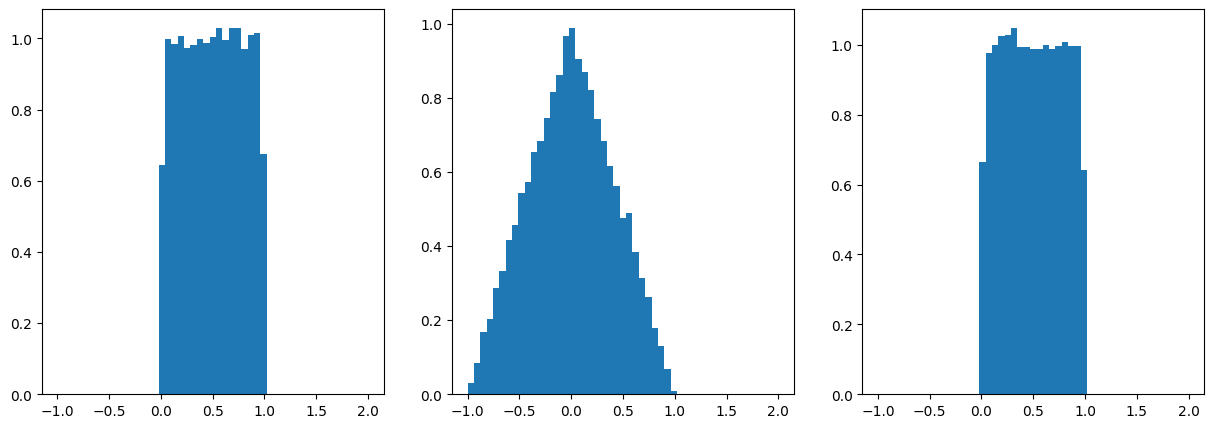

In [ ]:
fig,ax = pl.subplots(1,3,figsize=(15,5))
a = np.random.random(size=int(1e+5))
b=2*np.random.random(size=int(1e+5))-1
c=1-(a+b)
hist_dict = {'density':True,'bins':np.linspace(-1,2,50)}
ax[0].hist(a[(c<1)&(c>0)],**hist_dict)
ax[1].hist(b[(c<1)&(c>0)],**hist_dict)
ax[2].hist(c[(c<1)&(c>0)],**hist_dict)
pl.show()

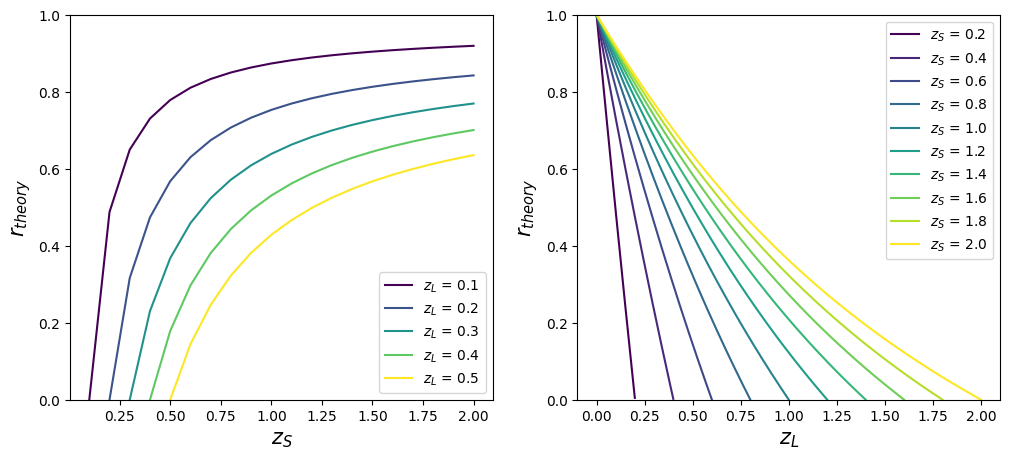

In [ ]:
#Pick some zL values:
zL_list_0 = np.round(np.arange(0.1,0.6,0.1),2)
#Choose range of zS to go with each one:
zS_list_0 = [np.arange(zL_i,2.1,0.1) for zL_i in zL_list_0]
#Calculate corresponding theoretical r value:
r_theory_list_0 = [r_SL(zL_list_0[i],zS_list_0[i],wCDM(H0=70,Om0=0.3,Ode0=0.7,w0=-1)) for i in range(len(zL_list_0))]
color_list_0 = pl.cm.viridis(np.linspace(0,1,len(zL_list_0)))

#Pick some zL values:
zS_list_1 = np.round(np.arange(0.2,2.2,0.2),2)
#Choose range of zL values to go with each one:
zL_list_1 = [np.arange(0,zS_i,0.001) for zS_i in zS_list_1]
#Calculate theoretical corresponding r value:
r_theory_list_1 = [r_SL(zL_list_1[i],zS_list_1[i],wCDM(H0=70,Om0=0.3,Ode0=0.7,w0=-1)) for i in range(len(zL_list_1))]
color_list_1 = pl.cm.viridis(np.linspace(0,1,len(zS_list_1)))

#Plot variation in r:
fig,ax = pl.subplots(1,2,figsize=(12,5))
for c_i in range(len(zL_list_0)):
    ax[0].plot(zS_list_0[c_i],r_theory_list_0[c_i],c=color_list_0[c_i])
for c_i in range(len(zS_list_1)):
    ax[1].plot(zL_list_1[c_i],r_theory_list_1[c_i],c=color_list_1[c_i])

ax[0].legend([f'$z_L$ = {zL_i}' for zL_i in  zL_list_0])
ax[1].legend([f'$z_S$ = {zS_i}' for zS_i in  zS_list_1])

ax[0].set_xlabel('$z_S$',fontsize=15)
ax[1].set_xlabel('$z_L$',fontsize=15)
for i in range(2):
    ax[i].set_ylabel('$r_{theory}$',fontsize=15)
    ax[i].set_ylim(0,1)

pl.show()

'''Takeaways: 
- Large variation in r if zL is unknown. If zL is uncertain, could explain many values of r within the uncertainty,
without resorting to constraining the cosmology.
- Large variation in r if zS is small and unknown, but smaller variation if zS is larger. If zS is uncertain but large, will get
smaller uncertainty in the theoretical value of r_theory, allowing more constraining power on the cosmology.
  '''

In [ ]:
['FlatLambdaCDM','LambdaCDM','FlatwCDM','wCDM','w0CDM']

contaminated = False;photometric = False
if not contaminated:
    if not photometric: likelihood = likelihood_SL
    if photometric: likelihood = likelihood_phot_SL
else: 
     if not photometric: likelihood = likelihood_spec_contam_SL
     if photometric: likelihood = likelihood_phot_contam_SL

mcmc_SL(
     n = 1000,n_walkers = int(2*(13+2*len(db_in))),
     likelihood = likelihood,
     zbias = 'bias',
     mubias = 'bias',
     OMi = 0.3,
     Odei = 0.7,
     H0i = 70,
     wi = -1,
     wai = 0,
     omstep = 0.01,
     ode_step = 0.01,
     H0step = 1,
     wstep = 0.01,
     db_in = db_in, #input file (dataset)
     fileout = 'chains/SL_orig',
     status = True,
     cosmo_type = cosmo_type,
     contaminated = contaminated,
     photometric = photometric)

#Would be good to have a code which seemlessly went from spectroscopic to photometric (or vice versa?) Not sure if 
#this is possible. May need to remove assertion in likelihood function.

Assuming the sample is not contaminated, and that the redshifts are not photometric
Allowing the cosmology to have non-zero curvature
Assuming w=-1
Using 12 cores


  0%|          | 0/1000 [00:00<?, ?it/s]

Outside OD boundOutside OD boundOutside OM boundOutside OD boundOutside W0 boundOutside OD boundOutside OM boundOutside OM boundOutside OM boundOutside OM bound









Outside W0 boundOutside OM bound

Outside OM bound
Outside OM bound
Outside OM bound

Outside OM boundOutside OD boundOutside OM boundOutside OM bound


Outside OM boundOutside OD bound
Outside OD bound
Outside OD boundOutside OM boundOutside OM bound



Outside OD bound
Outside OD bound
Outside OM boundOutside OM bound

Outside OD boundOutside OD boundOutside OM bound


Outside W0 bound
Outside OM bound
Outside OM boundOutside OD bound
Outside OD bound

Outside OM boundOutside OM bound

Outside OD boundOutside OD bound

Outside OM boundOutside OM bound

Outside OM bound
Outside OD bound
Outside OD bound
Outside OM bound
Outside OM boundOutside OM bound

Outside OM boundOutside OM bound

Outside OD boundOutside W0 bound

Outside OD boundOutside OM bound

Outside OD bound
Outside OD bound
Outside OM boundOutside W0 boun

  0%|          | 5/1000 [00:00<00:21, 46.21it/s]

Outside W0 bound
Outside OD bound
Outside OM boundOutside OM bound

Outside OD bound
Outside OD bound
Outside OD boundOutside OM boundOutside OD boundOutside OM boundOutside OM bound




Outside OM boundOutside OD bound

Outside OD bound
Outside OD bound
Outside OM bound
Outside OM boundOutside OM boundOutside OM bound
Outside OM bound
Outside OD bound


Outside W0 boundOutside OM boundOutside OM boundOutside OD boundOutside OM bound




Outside OM boundOutside OM bound

Outside OD boundOutside OD bound

Outside OM boundOutside OM bound

Outside OM boundOutside OM bound

Outside OD bound
Outside OM boundOutside W0 boundOutside OM boundOutside OM boundOutside OM bound


Outside OD bound


Outside W0 boundOutside OM boundOutside OM boundOutside OM bound


Outside OM bound
Outside W0 boundOutside OD bound

Outside OM bound

Outside OD bound
Outside OM boundOutside W0 boundOutside OD bound


Outside W0 boundOutside OD boundOutside OD boundOutside OD boundOutside OM bound




Outside W0 bou

  1%|          | 11/1000 [00:00<00:18, 52.88it/s]

Outside OM boundOutside OM boundOutside OM boundOutside OM boundOutside W0 boundOutside W0 boundOutside OD bound
Outside OM bound






Outside W0 boundOutside OD boundOutside OD boundOutside W0 boundOutside OM bound




Outside W0 bound
Outside OM boundOutside OD bound

Outside OM boundOutside OD bound

Outside OM boundOutside W0 bound

Outside OM bound
Outside OD bound
Outside OD boundOutside W0 bound
Outside W0 bound
Outside OM bound

Outside OD bound
Outside W0 bound
Outside OM bound
Outside OD bound
Outside OD boundOutside OD boundOutside W0 boundOutside OM boundOutside OM boundOutside OM bound





Outside OM boundOutside W0 boundOutside OD boundOutside W0 boundOutside OD boundOutside OD bound
Outside OD bound





Outside OM bound
Outside OM bound
Outside OD boundOutside OM boundOutside OD boundOutside OM boundOutside OM bound




Outside OD bound
Outside OM boundOutside OD bound

Outside OM bound
Outside OD boundOutside OD boundOutside W0 bound

Outside W0 bound

Outside OD bou

  2%|▏         | 17/1000 [00:00<00:17, 55.51it/s]

Outside OM boundOutside W0 boundOutside OD boundOutside W0 bound


Outside OD bound

Outside OM boundOutside OM boundOutside W0 boundOutside OD bound



Outside OD bound
Outside W0 boundOutside OM boundOutside OM boundOutside OD bound

Outside W0 bound


Outside OM boundOutside OD boundOutside OD boundOutside OM boundOutside OD boundOutside OD bound





Outside W0 boundOutside OM boundOutside OM boundOutside W0 boundOutside OD boundOutside OD boundOutside OM bound






Outside W0 bound
Outside OM bound
Outside W0 boundOutside W0 boundOutside OM bound

Outside OM bound

Outside OM boundOutside OD boundOutside OD boundOutside OD boundOutside OM boundOutside OM boundOutside OD boundOutside OD bound







Outside OM bound
Outside W0 boundOutside OM boundOutside W0 boundOutside W0 bound



Outside OM boundOutside OD boundOutside OD boundOutside OD bound


Outside OD bound

Outside OD bound
Outside W0 boundOutside OD bound

Outside W0 boundOutside OD bound

Outside OD boundOutside OD boun

  2%|▏         | 24/1000 [00:00<00:16, 58.53it/s]

Outside W0 boundOutside W0 boundOutside W0 boundOutside OM boundOutside OD boundOutside OM bound





Outside OM bound
Outside OD boundOutside OD bound

Outside W0 bound
Outside OM bound
Outside OM bound
Outside W0 bound
Outside W0 boundOutside OD bound

Outside OM boundOutside W0 bound


Outside OD boundOutside OM bound
Outside OD bound
Outside W0 bound
Outside OD boundOutside OM bound
Outside OM bound

Outside OM bound
Outside OM boundOutside OM boundOutside OM boundOutside OM bound


Outside OM bound

Outside OM boundOutside OM boundOutside OD bound
Outside W0 boundOutside OD boundOutside OD boundOutside OM bound





Outside OD boundOutside W0 boundOutside OD boundOutside OM bound
Outside W0 bound



Outside OD bound

Outside OD bound


Outside OD bound
Outside W0 boundOutside W0 bound

Outside OD boundOutside W0 boundOutside W0 bound
Outside W0 boundOutside W0 bound
Outside OM bound
Outside OD boundOutside OM bound
Outside W0 boundOutside OD bound
Outside W0 bound


Outside OD bou

  3%|▎         | 31/1000 [00:00<00:15, 62.45it/s]

Outside OM boundOutside W0 boundOutside OM boundOutside OD bound


Outside OM boundOutside W0 bound


Outside OD boundOutside OD bound

Outside OD boundOutside OD boundOutside OD bound


Outside W0 bound
Outside OM boundOutside W0 bound
Outside OM boundOutside OM bound


Outside W0 bound
Outside W0 boundOutside OM bound

Outside OD boundOutside OM bound

Outside OD bound
Outside OM boundOutside OD boundOutside W0 bound


Outside OD bound
Outside W0 bound
Outside OM bound
Outside W0 bound
Outside OD bound
Outside OD boundOutside OM bound

Outside W0 boundOutside W0 bound

Outside OM boundOutside OD boundOutside OM bound
Outside H0 boundOutside OD boundOutside W0 bound




Outside W0 boundOutside OM boundOutside H0 bound
Outside OM bound
Outside W0 bound


Outside W0 boundOutside OM boundOutside W0 bound


Outside OM boundOutside OD bound

Outside OD bound
Outside OM bound
Outside W0 bound
Outside OD boundOutside W0 bound
Outside OM bound

Outside W0 bound
Outside H0 bound
Outside W0 bou

  4%|▍         | 38/1000 [00:00<00:14, 64.39it/s]

Outside W0 boundOutside H0 bound
Outside OD bound

Outside W0 bound
Outside OM boundOutside W0 boundOutside H0 bound

Outside OM bound
Outside H0 boundOutside W0 boundOutside H0 boundOutside OD bound


Outside W0 bound


Outside OM bound

Outside H0 boundOutside OD bound
Outside W0 boundOutside OD boundOutside OM boundOutside H0 boundOutside W0 boundOutside OD boundOutside W0 boundOutside W0 boundOutside W0 bound








Outside OD bound
Outside W0 boundOutside OM bound
Outside OD bound
Outside H0 bound
Outside W0 bound

Outside H0 boundOutside W0 boundOutside W0 bound

Outside OM boundOutside W0 boundOutside OM bound



Outside W0 boundOutside OD bound
Outside OM boundOutside OM boundOutside W0 boundOutside OM bound
Outside OM bound




Outside OD bound
Outside OD bound
Outside OM bound
Outside W0 boundOutside OD boundOutside W0 boundOutside OM boundOutside OD bound

Outside OM bound

Outside W0 bound


Outside W0 boundOutside H0 boundOutside W0 boundOutside H0 bound



Outside OD bou

  4%|▍         | 45/1000 [00:00<00:17, 54.52it/s]

Outside W0 boundOutside OM bound
Outside OD bound
Outside H0 bound

Outside H0 boundOutside H0 boundOutside OD boundOutside OD bound



Outside H0 bound
Outside OD boundOutside OM boundOutside W0 bound

Outside W0 boundOutside W0 bound

Outside OD boundOutside H0 boundOutside H0 bound



Outside OD boundOutside OD bound

Outside OD boundOutside H0 bound

Outside W0 boundOutside OD boundOutside OD boundOutside W0 boundOutside OM bound




Outside OM boundOutside H0 bound

Outside OD bound
Outside H0 boundOutside H0 bound

Outside OM bound
Outside OM boundOutside OM bound

Outside OD boundOutside OM bound

Outside OD boundOutside H0 bound
Outside W0 bound

Outside OD bound
Outside OD boundOutside OM bound
Outside W0 bound
Outside OM boundOutside H0 boundOutside W0 boundOutside H0 bound




Outside H0 boundOutside W0 boundOutside OM bound


Outside H0 boundOutside W0 boundOutside W0 bound
Outside OM boundOutside H0 boundOutside W0 bound




Outside OM boundOutside W0 boundOutside H0 bound

  5%|▌         | 52/1000 [00:00<00:16, 57.27it/s]

Outside OD bound
Outside H0 boundOutside OD bound

Outside H0 boundOutside W0 bound

Outside W0 boundOutside OM boundOutside W0 bound


Outside OD bound
Outside W0 boundOutside H0 bound

Outside W0 boundOutside H0 boundOutside OD bound


Outside H0 bound
Outside H0 boundOutside OD boundOutside OD boundOutside OD boundOutside W0 bound




Outside H0 boundOutside OD boundOutside H0 bound
Outside H0 bound
Outside W0 boundOutside H0 bound



Outside W0 boundOutside OD bound

Outside OD bound
Outside W0 boundOutside OD bound

Outside H0 boundOutside H0 bound

Outside W0 boundOutside OM boundOutside H0 boundOutside H0 bound
Outside H0 bound
Outside OD bound



Outside OM bound
Outside W0 boundOutside W0 boundOutside W0 bound
Outside OM boundOutside W0 bound



Outside H0 boundOutside OD boundOutside OD boundOutside H0 boundOutside OD boundOutside OM boundOutside H0 boundOutside W0 bound


Outside H0 bound




Outside OD boundOutside OD bound
Outside W0 bound

Outside W0 boundOutside H0 bound

  6%|▌         | 58/1000 [00:01<00:16, 55.91it/s]

Outside H0 boundOutside OM boundOutside OD bound


Outside OD boundOutside OD boundOutside H0 bound
Outside OD bound
Outside OM boundOutside W0 bound



Outside H0 bound
Outside OD bound

Outside H0 boundOutside OM bound
Outside W0 boundOutside OM bound

Outside OD bound
Outside H0 boundOutside OD boundOutside W0 bound


Outside OD boundOutside H0 bound
Outside H0 bound

Outside H0 bound
Outside H0 boundOutside OD bound

Outside W0 bound

Outside OD boundOutside W0 bound
Outside H0 boundOutside H0 boundOutside W0 bound
Outside H0 boundOutside H0 boundOutside OM bound




Outside H0 bound
Outside OM boundOutside OM boundOutside H0 bound


Outside W0 boundOutside W0 bound
Outside W0 bound

Outside H0 bound
Outside OM boundOutside OM boundOutside H0 bound


Outside W0 boundOutside W0 bound

Outside OM boundOutside W0 bound

Outside OD bound
Outside W0 boundOutside OD boundOutside H0 boundOutside OM bound

Outside H0 bound
Outside OM boundOutside H0 bound


Outside OD bound

Outside W0 bou

  6%|▋         | 64/1000 [00:01<00:16, 55.77it/s]

Outside H0 boundOutside OD boundOutside OD boundOutside OM bound

Outside OM boundOutside H0 bound
Outside H0 boundOutside W0 bound




Outside H0 boundOutside W0 bound

Outside OM boundOutside W0 boundOutside OM bound


Outside H0 boundOutside H0 bound
Outside H0 bound

Outside W0 boundOutside H0 bound
Outside OD boundOutside OM bound

Outside OD bound

Outside OD boundOutside H0 boundOutside OD boundOutside W0 boundOutside W0 boundOutside H0 boundOutside H0 bound






Outside W0 boundOutside OD bound

Outside H0 boundOutside W0 boundOutside OD boundOutside OD bound



Outside OD boundOutside H0 boundOutside H0 boundOutside OM bound



Outside H0 bound
Outside W0 bound

Outside OM boundOutside OD boundOutside H0 boundOutside H0 bound


Outside OD bound
Outside H0 boundOutside W0 boundOutside H0 bound


Outside H0 bound
Outside OD boundOutside W0 bound

Outside OM bound
Outside W0 bound
Outside W0 boundOutside OM bound

Outside H0 boundOutside H0 bound

Outside OM boundOutside W0 boun

  7%|▋         | 70/1000 [00:01<00:16, 55.82it/s]


Outside H0 bound
Outside W0 boundOutside H0 boundOutside OM bound

Outside W0 boundOutside H0 bound


Outside OD boundOutside H0 boundOutside OD bound
Outside H0 boundOutside OD bound



Outside H0 bound
Outside H0 boundOutside W0 boundOutside OM boundOutside OD bound

Outside W0 boundOutside H0 bound



Outside H0 boundOutside OD bound

Outside W0 bound
Outside H0 boundOutside H0 boundOutside OD boundOutside H0 boundOutside W0 bound


Outside H0 bound

Outside H0 bound

Outside W0 boundOutside H0 boundOutside OM boundOutside W0 bound



Outside OM bound
Outside H0 boundOutside W0 bound
Outside H0 boundOutside W0 bound

Outside OD boundOutside OD boundOutside OD bound



Outside W0 bound
Outside H0 boundOutside W0 boundOutside W0 boundOutside W0 bound



Outside OM boundOutside OD boundOutside OD bound


Outside OD bound
Outside OM boundOutside H0 boundOutside W0 boundOutside OM boundOutside W0 bound




Outside H0 bound
Outside W0 bound
Outside OM boundOutside OD bound

Outside W0 bo

  8%|▊         | 77/1000 [00:01<00:15, 59.43it/s]

Outside W0 boundOutside OD bound
Outside W0 boundOutside OM boundOutside OM boundOutside OD bound




Outside OD boundOutside OD boundOutside W0 boundOutside W0 boundOutside H0 boundOutside OM boundOutside OD boundOutside W0 boundOutside OD bound






Outside H0 bound


Outside W0 boundOutside W0 boundOutside W0 bound


Outside W0 boundOutside W0 boundOutside OM bound


Outside H0 boundOutside H0 boundOutside W0 boundOutside OM bound

Outside H0 boundOutside W0 bound



Outside OM bound
Outside W0 bound
Outside OM boundOutside OD bound

Outside OD boundOutside H0 boundOutside H0 bound


Outside W0 boundOutside H0 boundOutside OM bound

Outside OD boundOutside OM boundOutside H0 boundOutside W0 bound

Outside H0 bound



Outside W0 bound
Outside H0 boundOutside OD bound
Outside OD boundOutside H0 bound
Outside H0 bound


Outside OM boundOutside OM bound
Outside W0 boundOutside H0 bound
Outside W0 boundOutside OM bound


Outside H0 bound

Outside OD bound
Outside OD boundOutside OM boun

  8%|▊         | 84/1000 [00:01<00:14, 61.21it/s]

Outside OD boundOutside OM bound

Outside OD boundOutside OM bound

Outside H0 bound
Outside OM boundOutside W0 bound

Outside H0 boundOutside H0 bound
Outside H0 bound

Outside H0 boundOutside H0 bound
Outside W0 bound

Outside W0 bound
Outside W0 bound
Outside H0 boundOutside OM boundOutside H0 boundOutside H0 bound



Outside OM boundOutside H0 bound

Outside OM bound
Outside OD boundOutside OD bound

Outside W0 boundOutside OM bound

Outside OD boundOutside W0 boundOutside OD boundOutside H0 bound



Outside OM bound
Outside OD boundOutside OM boundOutside OD bound
Outside OD bound

Outside OM bound

Outside H0 bound
Outside H0 bound
Outside W0 boundOutside H0 bound

Outside OM bound
Outside W0 bound
Outside OM boundOutside H0 bound

Outside OM boundOutside W0 boundOutside OM bound


Outside W0 bound
Outside W0 boundOutside H0 bound


Outside OD boundOutside OD bound
Outside H0 bound
Outside H0 bound
Outside H0 boundOutside OM bound

Outside OD boundOutside OD boundOutside H0 bound

  9%|▉         | 91/1000 [00:01<00:15, 59.20it/s]

Outside OD boundOutside H0 bound
Outside W0 bound
Outside H0 boundOutside W0 boundOutside OD bound

Outside OM bound
Outside H0 bound

Outside W0 bound

Outside H0 bound
Outside OD bound
Outside W0 boundOutside OM bound

Outside W0 bound
Outside OM bound
Outside H0 bound
Outside OM bound
Outside W0 bound
Outside OM boundOutside OD boundOutside H0 bound


Outside OM boundOutside OM bound

Outside OM boundOutside H0 boundOutside H0 bound


Outside OM bound
Outside W0 bound
Outside OD bound
Outside OD bound
Outside OD bound
Outside W0 bound
Outside OD bound
Outside H0 boundOutside OM bound
Outside H0 bound

Outside OM bound
Outside W0 bound
Outside OD bound
Outside OD boundOutside OM boundOutside OM bound


Outside H0 boundOutside OD bound


Outside H0 boundOutside W0 bound
Outside OM bound
Outside OM boundOutside H0 boundOutside W0 bound


Outside W0 bound
Outside OD bound
Outside OD boundOutside H0 bound
Outside OM bound
Outside OM bound

Outside OD bound
Outside W0 boundOutside H0 boun

 10%|▉         | 97/1000 [00:01<00:15, 58.13it/s]

Outside OM boundOutside H0 boundOutside H0 boundOutside OD bound



Outside H0 boundOutside H0 bound

Outside OD boundOutside H0 boundOutside OD bound


Outside H0 bound
Outside OM bound
Outside OD boundOutside H0 bound

Outside OM bound
Outside OM boundOutside OM bound

Outside W0 boundOutside OD boundOutside OD boundOutside OM boundOutside OD bound

Outside H0 bound

Outside OM boundOutside H0 bound



Outside H0 bound
Outside H0 bound
Outside OM boundOutside H0 bound

Outside OD bound
Outside W0 bound
Outside W0 bound
Outside OD bound
Outside H0 bound
Outside H0 bound
Outside H0 boundOutside H0 bound
Outside H0 bound
Outside OM boundOutside H0 bound


Outside H0 boundOutside H0 bound

Outside OM bound
Outside W0 bound
Outside W0 boundOutside OM boundOutside H0 bound


Outside H0 bound
Outside H0 boundOutside OD boundOutside OD boundOutside H0 bound
Outside H0 bound


Outside OM boundOutside OD boundOutside OM boundOutside OD bound

Outside OD bound

Outside OD bound


Outside H0 bou

 10%|█         | 103/1000 [00:01<00:15, 56.43it/s]


Outside W0 bound
Outside H0 boundOutside W0 bound
Outside H0 bound

Outside H0 bound
Outside OM bound
Outside OM boundOutside OM bound

Outside OD bound
Outside H0 bound
Outside H0 boundOutside H0 boundOutside W0 bound


Outside W0 boundOutside OM bound

Outside H0 boundOutside W0 bound

Outside W0 boundOutside OM bound

Outside OM bound
Outside OD bound
Outside W0 boundOutside OM bound

Outside H0 bound
Outside H0 bound
Outside H0 boundOutside OD boundOutside OD bound


Outside W0 boundOutside W0 boundOutside OM bound

Outside H0 bound
Outside OM bound

Outside H0 boundOutside W0 bound
Outside OD bound
Outside OM bound

Outside H0 boundOutside W0 bound

Outside H0 bound
Outside OM boundOutside H0 bound

Outside OM boundOutside W0 boundOutside OM boundOutside H0 bound
Outside H0 bound



Outside OM bound
Outside OD bound
Outside OM bound
Outside H0 boundOutside OM boundOutside OM bound
Outside OM bound



Outside OM boundOutside H0 boundOutside H0 bound

Outside H0 boundOutside W0 bou

 11%|█         | 109/1000 [00:01<00:15, 56.72it/s]

Outside H0 boundOutside OD boundOutside H0 bound


Outside H0 boundOutside H0 bound
Outside H0 bound

Outside H0 boundOutside OD bound
Outside W0 boundOutside H0 bound
Outside W0 bound


Outside W0 bound
Outside OM boundOutside H0 boundOutside OD boundOutside W0 boundOutside OD boundOutside H0 boundOutside H0 bound





Outside H0 boundOutside OM boundOutside OM bound


Outside OM bound

Outside OM bound
Outside OD boundOutside OM boundOutside H0 boundOutside H0 boundOutside H0 bound



Outside OD boundOutside W0 boundOutside W0 bound



Outside H0 boundOutside H0 boundOutside OD bound


Outside H0 boundOutside H0 boundOutside W0 boundOutside W0 boundOutside OM bound




Outside OM bound
Outside OM boundOutside H0 boundOutside W0 bound


Outside OM boundOutside W0 bound

Outside OD bound
Outside H0 boundOutside OM boundOutside OD boundOutside H0 boundOutside W0 boundOutside OD bound
Outside OD bound





Outside OD bound
Outside H0 boundOutside OM bound

Outside W0 boundOutside W0 boun

 12%|█▏        | 116/1000 [00:02<00:15, 58.55it/s]

Outside W0 boundOutside OM boundOutside W0 boundOutside OM bound







Outside H0 boundOutside H0 boundOutside H0 boundOutside W0 bound



Outside OD bound
Outside OD boundOutside OM bound

Outside W0 bound
Outside OM boundOutside W0 boundOutside OD boundOutside W0 boundOutside OM bound



Outside W0 bound

Outside OD boundOutside W0 boundOutside H0 bound

Outside OD bound
Outside W0 boundOutside OM boundOutside H0 bound
Outside OM bound



Outside H0 bound
Outside OM bound
Outside OM boundOutside W0 bound

Outside H0 boundOutside H0 bound
Outside H0 boundOutside H0 bound

Outside OD boundOutside W0 bound


Outside W0 bound
Outside H0 boundOutside OM bound

Outside OM boundOutside W0 bound
Outside W0 boundOutside OM bound


Outside OD bound
Outside W0 bound
Outside OM boundOutside W0 boundOutside OD bound


Outside H0 boundOutside H0 bound
Outside OM boundOutside W0 bound


Outside W0 boundOutside W0 bound

Outside H0 boundOutside W0 boundOutside OD bound


Outside H0 boundOutside H0 

 12%|█▏        | 122/1000 [00:02<00:14, 58.95it/s]

Outside W0 bound
Outside OM boundOutside H0 bound

Outside H0 bound
Outside W0 bound

Outside OD boundOutside OM bound
Outside W0 bound
Outside W0 boundOutside H0 boundOutside H0 bound

Outside H0 bound
Outside H0 boundOutside H0 bound


Outside H0 bound
Outside OD boundOutside OD bound

Outside W0 boundOutside H0 boundOutside H0 boundOutside W0 boundOutside OM bound




Outside H0 boundOutside W0 bound


Outside OD boundOutside W0 boundOutside OD bound
Outside W0 bound
Outside OM bound
Outside OM boundOutside OD bound


Outside W0 boundOutside OM bound
Outside OD boundOutside OM bound


Outside H0 boundOutside W0 boundOutside OM bound


Outside W0 boundOutside H0 bound

Outside OD bound
Outside W0 boundOutside H0 bound

Outside H0 boundOutside OD bound

Outside W0 bound
Outside W0 bound
Outside OD boundOutside OM bound

Outside H0 bound

Outside OM boundOutside H0 bound
Outside OD bound
Outside H0 boundOutside W0 boundOutside OD bound


Outside OM boundOutside OM boundOutside W0 bound

 13%|█▎        | 129/1000 [00:02<00:14, 60.66it/s]

Outside H0 bound
Outside H0 bound
Outside H0 bound

Outside W0 boundOutside W0 boundOutside W0 boundOutside W0 bound


Outside H0 boundOutside OD bound

Outside H0 boundOutside W0 bound

Outside H0 boundOutside H0 boundOutside OM bound

Outside H0 boundOutside OM bound
Outside OD bound


Outside H0 bound
Outside OM bound
Outside H0 boundOutside H0 boundOutside OM bound


Outside OD boundOutside OM bound
Outside W0 bound

Outside OM bound
Outside OM bound
Outside W0 boundOutside H0 bound
Outside H0 bound

Outside H0 boundOutside W0 bound

Outside H0 boundOutside OM bound

Outside H0 bound
Outside OM boundOutside H0 boundOutside W0 boundOutside OM bound
Outside W0 boundOutside H0 bound




Outside H0 boundOutside OM bound

Outside OM boundOutside OM boundOutside OM bound
Outside H0 boundOutside H0 bound


Outside W0 bound

Outside OD bound

Outside H0 boundOutside W0 boundOutside W0 boundOutside H0 bound

Outside OM bound
Outside W0 bound

Outside H0 boundOutside OM boundOutside OM bound

 14%|█▎        | 136/1000 [00:02<00:14, 59.21it/s]

Outside H0 bound
Outside W0 boundOutside H0 bound

Outside H0 bound
Outside W0 bound
Outside OM bound
Outside OD boundOutside H0 boundOutside H0 bound
Outside H0 bound
Outside OM bound
Outside H0 boundOutside H0 boundOutside OM bound




Outside H0 boundOutside W0 bound
Outside H0 bound
Outside OM bound

Outside H0 boundOutside H0 bound

Outside W0 boundOutside OM bound

Outside OD boundOutside OM bound

Outside OD boundOutside OM bound

Outside H0 boundOutside H0 bound

Outside H0 bound
Outside W0 boundOutside OD bound

Outside OM boundOutside OD bound

Outside OM boundOutside OM bound

Outside W0 boundOutside H0 bound

Outside W0 bound
Outside W0 boundOutside OD boundOutside W0 boundOutside H0 boundOutside H0 bound



Outside W0 bound
Outside W0 bound

Outside W0 boundOutside H0 boundOutside W0 boundOutside OM bound
Outside OM boundOutside H0 bound




Outside OM bound
Outside W0 boundOutside OM bound
Outside H0 bound
Outside OM boundOutside H0 bound


Outside W0 bound
Outside H0 bou

 14%|█▍        | 142/1000 [00:02<00:14, 58.84it/s]

Outside H0 bound


Outside OM boundOutside OD bound
Outside W0 boundOutside W0 bound


Outside OM bound
Outside W0 bound
Outside H0 boundOutside OM bound

Outside OM bound
Outside H0 boundOutside OD bound

Outside H0 boundOutside OD bound

Outside W0 bound
Outside H0 bound
Outside OD bound
Outside OD bound
Outside OM bound
Outside H0 bound
Outside OD boundOutside W0 bound
Outside OM bound
Outside W0 bound

Outside H0 boundOutside H0 bound
Outside OD boundOutside OD boundOutside H0 boundOutside OM boundOutside OM bound
Outside W0 bound

Outside W0 bound


Outside W0 bound


Outside OM bound
Outside W0 bound
Outside W0 boundOutside OM boundOutside OD boundOutside W0 bound



Outside OM boundOutside OM bound

Outside H0 boundOutside OD boundOutside H0 bound


Outside H0 bound
Outside W0 boundOutside OD bound

Outside OM bound
Outside OM boundOutside H0 bound

Outside OD bound
Outside H0 boundOutside H0 boundOutside H0 bound

Outside W0 bound

Outside W0 bound
Outside OD boundOutside W0 bo

 15%|█▍        | 149/1000 [00:02<00:14, 59.76it/s]


Outside H0 boundOutside OM bound

Outside H0 boundOutside H0 boundOutside OM bound

Outside OM boundOutside OD bound
Outside W0 bound


Outside H0 boundOutside OM bound

Outside OM boundOutside OM boundOutside W0 boundOutside H0 bound

Outside W0 bound


Outside OD boundOutside H0 bound
Outside OD bound

Outside W0 bound
Outside OM boundOutside H0 bound

Outside W0 boundOutside OM boundOutside OM bound

Outside OM boundOutside OD bound
Outside H0 bound


Outside OM bound
Outside OM boundOutside W0 bound

Outside W0 bound
Outside OD bound
Outside H0 boundOutside OM bound
Outside OM bound
Outside H0 boundOutside H0 boundOutside OM boundOutside W0 boundOutside W0 bound





Outside W0 boundOutside OM bound

Outside OM boundOutside W0 boundOutside H0 bound
Outside H0 bound


Outside H0 bound
Outside H0 boundOutside OM boundOutside H0 bound

Outside H0 boundOutside W0 bound
Outside OM bound
Outside W0 bound

Outside H0 bound
Outside W0 bound

Outside OM bound
Outside OM bound
Outside H0 bo

 16%|█▌        | 156/1000 [00:02<00:14, 59.29it/s]

Outside H0 bound
Outside H0 bound
Outside OM boundOutside H0 boundOutside W0 bound

Outside OD bound

Outside W0 boundOutside H0 bound

Outside OM boundOutside W0 boundOutside W0 boundOutside W0 bound
Outside W0 boundOutside W0 boundOutside W0 boundOutside H0 bound






Outside OM boundOutside H0 bound

Outside H0 boundOutside H0 bound

Outside OM bound
Outside OD bound
Outside OM bound
Outside W0 bound
Outside W0 bound
Outside H0 boundOutside OD boundOutside OD boundOutside W0 bound



Outside OM boundOutside OD bound
Outside H0 boundOutside H0 boundOutside OD boundOutside H0 bound
Outside OD bound





Outside W0 boundOutside W0 boundOutside W0 bound

Outside OM boundOutside H0 bound

Outside W0 boundOutside H0 boundOutside W0 bound

Outside OD boundOutside OD boundOutside W0 boundOutside OD bound




Outside W0 bound
Outside OM bound
Outside H0 boundOutside OD bound

Outside H0 boundOutside H0 boundOutside OM boundOutside W0 bound
Outside OD boundOutside W0 bound

Outside W0 bound


 16%|█▌        | 162/1000 [00:02<00:14, 58.94it/s]





Outside OM boundOutside W0 boundOutside OD bound
Outside H0 boundOutside H0 bound
Outside OM boundOutside H0 boundOutside OD bound





Outside H0 boundOutside OM boundOutside H0 boundOutside OM bound



Outside W0 boundOutside OM bound
Outside OM boundOutside H0 bound


Outside H0 boundOutside OM boundOutside H0 bound


Outside OM bound
Outside H0 boundOutside W0 bound

Outside OM boundOutside OM boundOutside OM boundOutside H0 boundOutside OM bound




Outside H0 bound
Outside OM boundOutside H0 bound

Outside W0 bound
Outside OD boundOutside OM boundOutside W0 bound

Outside OM bound

Outside H0 boundOutside W0 boundOutside H0 boundOutside H0 boundOutside OD bound
Outside W0 boundOutside OM boundOutside H0 bound






Outside OM boundOutside H0 boundOutside W0 bound
Outside H0 boundOutside OM boundOutside W0 bound




Outside W0 boundOutside OM bound
Outside OD bound
Outside OM bound

Outside W0 boundOutside W0 boundOutside H0 boundOutside OM bound


Outside H0 bound

Outside OD

 17%|█▋        | 169/1000 [00:02<00:13, 61.04it/s]


Outside OM boundOutside H0 boundOutside H0 boundOutside OD boundOutside W0 bound




Outside W0 bound
Outside OM bound
Outside H0 boundOutside H0 boundOutside OM bound

Outside OM boundOutside OM boundOutside H0 bound


Outside H0 bound

Outside W0 boundOutside OD boundOutside H0 boundOutside H0 boundOutside W0 boundOutside H0 boundOutside H0 bound






Outside H0 bound
Outside H0 bound
Outside OM boundOutside H0 boundOutside W0 bound
Outside OM boundOutside OM bound
Outside OM bound



Outside OM bound
Outside H0 boundOutside W0 boundOutside OM boundOutside OD boundOutside W0 boundOutside OM boundOutside W0 bound






Outside OM boundOutside OM boundOutside OM bound
Outside OD bound
Outside H0 boundOutside OD bound
Outside W0 bound



Outside OM bound
Outside H0 boundOutside OD boundOutside H0 boundOutside W0 boundOutside W0 boundOutside H0 bound
Outside W0 boundOutside OM bound






Outside H0 boundOutside W0 bound

Outside OM bound
Outside H0 boundOutside OM boundOutside OM boun

 18%|█▊        | 176/1000 [00:03<00:13, 60.43it/s]

Outside W0 boundOutside OD bound
Outside W0 bound
Outside OM bound

Outside H0 bound
Outside H0 boundOutside H0 bound

Outside OM boundOutside H0 boundOutside H0 boundOutside W0 bound



Outside OM bound
Outside H0 bound
Outside OD boundOutside W0 boundOutside W0 bound


Outside H0 boundOutside OD bound

Outside H0 boundOutside H0 bound

Outside OM boundOutside OM bound
Outside OD boundOutside H0 boundOutside H0 bound
Outside OM bound



Outside OM boundOutside OM boundOutside H0 bound


Outside W0 bound
Outside W0 boundOutside H0 bound


Outside H0 boundOutside H0 bound
Outside OM bound
Outside H0 boundOutside H0 bound

Outside OM boundOutside H0 boundOutside H0 bound


Outside W0 boundOutside OM bound

Outside W0 bound
Outside H0 bound
Outside H0 boundOutside W0 bound

Outside OM bound
Outside W0 boundOutside H0 boundOutside H0 bound


Outside OM bound
Outside OD bound
Outside H0 boundOutside OD bound

Outside OM bound
Outside H0 boundOutside H0 bound

Outside H0 bound
Outside H0 bou

 18%|█▊        | 183/1000 [00:03<00:13, 60.26it/s]


Outside OD boundOutside OM bound

Outside H0 bound


Outside H0 bound
Outside OD boundOutside H0 boundOutside OM boundOutside OD bound
Outside W0 boundOutside OD boundOutside H0 bound





Outside OM bound
Outside W0 boundOutside H0 boundOutside H0 bound


Outside H0 boundOutside OD boundOutside OM bound


Outside H0 bound
Outside OD boundOutside H0 bound
Outside H0 bound

Outside OM boundOutside W0 boundOutside H0 boundOutside H0 bound
Outside H0 bound


Outside OD boundOutside OM bound


Outside H0 bound
Outside H0 boundOutside W0 bound

Outside OM boundOutside H0 bound

Outside H0 bound
Outside OM boundOutside H0 boundOutside OM boundOutside OM bound
Outside H0 boundOutside H0 bound




Outside OD boundOutside W0 boundOutside H0 boundOutside H0 boundOutside H0 bound


Outside W0 boundOutside H0 boundOutside W0 bound



Outside W0 bound



Outside OM boundOutside OM bound
Outside H0 bound


Outside H0 boundOutside OM boundOutside H0 bound
Outside OD boundOutside OM boundOutside H0 b

 19%|█▉        | 190/1000 [00:03<00:13, 61.69it/s]

Outside OD boundOutside H0 boundOutside W0 bound


Outside H0 bound
Outside H0 boundOutside OD bound



Outside H0 boundOutside OM bound
Outside H0 boundOutside OM boundOutside H0 bound

Outside H0 boundOutside H0 bound
Outside H0 boundOutside OM boundOutside W0 boundOutside H0 bound




Outside H0 boundOutside OD boundOutside H0 boundOutside OM boundOutside W0 boundOutside H0 boundOutside OD bound





Outside OD bound

Outside W0 bound
Outside H0 bound
Outside H0 bound
Outside W0 boundOutside OM boundOutside W0 bound


Outside OD bound
Outside H0 bound
Outside H0 boundOutside OD boundOutside W0 boundOutside W0 bound
Outside W0 boundOutside H0 boundOutside H0 bound





Outside H0 bound
Outside H0 boundOutside H0 bound

Outside OM bound
Outside OM boundOutside W0 bound

Outside H0 boundOutside OM boundOutside H0 bound
Outside OM bound


Outside W0 boundOutside H0 bound

Outside OM boundOutside H0 bound
Outside W0 boundOutside H0 boundOutside W0 bound



Outside W0 boundOutside W0 boun

 20%|█▉        | 197/1000 [00:03<00:13, 60.87it/s]

Outside OM boundOutside OD bound

Outside OM boundOutside H0 bound
Outside H0 boundOutside H0 bound


Outside H0 bound
Outside H0 boundOutside H0 bound
Outside H0 boundOutside W0 bound


Outside H0 bound
Outside H0 boundOutside W0 bound

Outside W0 boundOutside OM boundOutside OM boundOutside OM bound



Outside OM bound
Outside W0 bound
Outside W0 boundOutside H0 boundOutside H0 bound


Outside H0 bound
Outside H0 boundOutside W0 bound

Outside W0 bound
Outside H0 boundOutside H0 bound

Outside OD bound
Outside OD boundOutside H0 boundOutside OM boundOutside W0 boundOutside OM bound
Outside H0 bound
Outside OM bound




Outside OM bound
Outside OM boundOutside H0 bound

Outside W0 boundOutside W0 bound

Outside H0 boundOutside W0 boundOutside OD bound


Outside OD bound
Outside H0 bound
Outside H0 boundOutside W0 boundOutside OM bound
Outside H0 boundOutside W0 bound



Outside W0 boundOutside H0 bound
Outside W0 bound
Outside W0 bound

Outside W0 boundOutside OM boundOutside W0 bound

 20%|██        | 204/1000 [00:03<00:12, 61.24it/s]



Outside H0 bound
Outside H0 bound
Outside W0 boundOutside OM bound

Outside OM boundOutside OD bound

Outside OM boundOutside W0 bound

Outside H0 boundOutside OM boundOutside OM bound


Outside OD boundOutside OM bound


Outside H0 boundOutside W0 boundOutside OD boundOutside OD bound


Outside H0 boundOutside OM boundOutside OD boundOutside W0 boundOutside OM boundOutside OM boundOutside H0 bound


Outside OD boundOutside OM bound





Outside OD boundOutside OM bound
Outside OM boundOutside OM boundOutside H0 bound
Outside H0 bound



Outside OD boundOutside H0 bound
Outside H0 boundOutside OM bound
Outside W0 boundOutside OD boundOutside W0 bound




Outside OM boundOutside OM boundOutside W0 boundOutside OM bound

Outside W0 bound


Outside OD bound

Outside OD boundOutside OM boundOutside OM bound

Outside H0 boundOutside H0 boundOutside H0 bound


Outside W0 boundOutside OD boundOutside H0 boundOutside OM bound



Outside OM bound
Outside OD boundOutside H0 boundOutside H0 bou

 21%|██        | 211/1000 [00:03<00:12, 61.27it/s]


Outside H0 bound
Outside OD bound
Outside H0 bound
Outside OM bound
Outside OD bound
Outside OD bound
Outside OD boundOutside W0 bound

Outside H0 bound
Outside H0 bound
Outside W0 boundOutside OM boundOutside OD bound


Outside H0 boundOutside H0 boundOutside OD boundOutside OM boundOutside W0 boundOutside W0 boundOutside H0 boundOutside H0 bound
Outside W0 bound







Outside OM bound
Outside H0 boundOutside W0 boundOutside W0 boundOutside OM boundOutside W0 boundOutside H0 bound





Outside H0 bound
Outside H0 boundOutside OM bound
Outside OM bound
Outside OD boundOutside W0 bound


Outside OD boundOutside H0 boundOutside H0 boundOutside W0 boundOutside W0 bound

Outside H0 bound



Outside H0 bound
Outside W0 boundOutside H0 bound

Outside H0 boundOutside H0 boundOutside OM boundOutside OD bound



Outside OM boundOutside OD bound

Outside OM boundOutside W0 bound

Outside H0 boundOutside OM bound

Outside OD boundOutside OM boundOutside OM boundOutside OM bound



Outside W0 bo

 22%|██▏       | 218/1000 [00:03<00:12, 62.24it/s]

Outside OM bound
Outside W0 boundOutside OD boundOutside OD boundOutside H0 bound
Outside H0 bound



Outside H0 bound
Outside W0 boundOutside W0 boundOutside OM bound


Outside OM bound
Outside H0 boundOutside OM boundOutside OM boundOutside OM boundOutside W0 boundOutside OM boundOutside OD bound






Outside OM boundOutside OD boundOutside H0 bound
Outside OM boundOutside W0 boundOutside OM boundOutside W0 bound
Outside OD bound





Outside OM bound
Outside OM bound
Outside OM bound
Outside OD bound
Outside OM bound
Outside OD boundOutside W0 boundOutside OM bound
Outside OM boundOutside OM bound



Outside OM bound
Outside W0 bound
Outside W0 boundOutside OM boundOutside OM bound


Outside OM bound
Outside W0 boundOutside OD boundOutside OM boundOutside OM bound



Outside H0 bound
Outside OD boundOutside W0 boundOutside OM bound
Outside OM bound


Outside OD boundOutside OD bound


Outside OD boundOutside OD bound
Outside OM bound
Outside OM bound
Outside OD boundOutside OM boun

 22%|██▎       | 225/1000 [00:03<00:12, 63.56it/s]

Outside OD boundOutside W0 bound

Outside H0 bound
Outside H0 bound
Outside W0 boundOutside OM bound

Outside OM boundOutside OM bound

Outside W0 boundOutside OM bound

Outside H0 bound
Outside OM bound
Outside OM boundOutside OM bound

Outside OM bound
Outside W0 boundOutside W0 bound

Outside H0 bound
Outside OM bound
Outside OD bound
Outside W0 boundOutside W0 bound

Outside W0 boundOutside W0 boundOutside OM boundOutside H0 bound



Outside W0 boundOutside W0 boundOutside OD boundOutside W0 bound

Outside H0 boundOutside OD boundOutside OM bound
Outside W0 bound


Outside OM bound

Outside OM bound

Outside OM boundOutside W0 boundOutside H0 boundOutside W0 bound
Outside W0 boundOutside OM bound



Outside OD bound

Outside H0 bound
Outside H0 boundOutside H0 boundOutside H0 bound



Outside H0 boundOutside W0 boundOutside W0 bound

Outside OD boundOutside W0 boundOutside OD bound

Outside H0 boundOutside OM boundOutside OM bound



Outside OD bound
Outside OD boundOutside W0 boun

 23%|██▎       | 232/1000 [00:03<00:12, 63.55it/s]

Outside H0 bound
Outside OD boundOutside W0 boundOutside H0 bound


Outside OD bound
Outside H0 bound
Outside OD boundOutside OD boundOutside W0 bound


Outside OM boundOutside W0 bound

Outside OD bound
Outside W0 boundOutside OM bound
Outside W0 bound

Outside OD boundOutside W0 bound

Outside OD boundOutside OM boundOutside W0 bound



Outside H0 boundOutside OM boundOutside W0 bound

Outside W0 bound
Outside H0 bound
Outside W0 bound
Outside OM boundOutside OM boundOutside OD bound

Outside H0 bound

Outside H0 bound
Outside H0 boundOutside W0 bound

Outside H0 bound
Outside OM boundOutside OM boundOutside W0 boundOutside OD boundOutside H0 bound




Outside OM boundOutside OD boundOutside H0 bound
Outside W0 bound


Outside OD bound
Outside H0 boundOutside H0 boundOutside H0 bound


Outside OM bound
Outside H0 boundOutside W0 bound

Outside OD bound
Outside OM boundOutside OM boundOutside OM boundOutside OM bound



Outside OM bound
Outside W0 boundOutside OM bound
Outside W0 boun

 24%|██▍       | 239/1000 [00:04<00:12, 61.65it/s]

Outside OD boundOutside OM bound

Outside H0 bound
Outside OM boundOutside H0 bound

Outside W0 bound
Outside OM bound
Outside OM bound
Outside H0 boundOutside OM boundOutside OM bound


Outside H0 boundOutside H0 boundOutside H0 boundOutside OD boundOutside W0 boundOutside H0 bound





Outside OM bound
Outside H0 boundOutside OM boundOutside OM boundOutside H0 bound



Outside OM boundOutside W0 bound

Outside OM boundOutside OM bound

Outside W0 boundOutside OM bound
Outside OM boundOutside OM boundOutside OM bound



Outside H0 boundOutside H0 bound

Outside H0 boundOutside OD boundOutside W0 boundOutside OM bound


Outside OM bound

Outside OD boundOutside OM bound

Outside OM bound
Outside H0 boundOutside H0 boundOutside H0 bound

Outside OM boundOutside OM boundOutside H0 bound


Outside OM bound

Outside H0 boundOutside OM bound
Outside H0 boundOutside OD boundOutside H0 bound


Outside H0 boundOutside OM bound


Outside OM boundOutside W0 boundOutside W0 boundOutside OD boundO

 25%|██▍       | 246/1000 [00:04<00:12, 61.16it/s]

Outside W0 bound
Outside H0 boundOutside W0 bound

Outside W0 boundOutside OD bound
Outside OM bound

Outside OM boundOutside OM bound

Outside H0 bound
Outside OM boundOutside OD bound

Outside H0 bound
Outside W0 boundOutside H0 bound

Outside OM bound

Outside H0 boundOutside W0 bound
Outside OM boundOutside H0 bound

Outside OM bound
Outside H0 boundOutside OD bound

Outside H0 bound
Outside W0 bound
Outside OM bound
Outside OM bound
Outside OM bound
Outside OD boundOutside H0 bound

Outside H0 boundOutside OM bound

Outside OM boundOutside H0 boundOutside OM bound
Outside OD boundOutside OM bound


Outside H0 boundOutside OM bound


Outside OM boundOutside H0 boundOutside OD bound


Outside H0 boundOutside W0 bound

Outside H0 bound
Outside H0 bound
Outside OM bound
Outside OM bound
Outside OM boundOutside H0 bound

Outside H0 bound
Outside H0 boundOutside H0 bound

Outside H0 boundOutside H0 bound
Outside OM bound
Outside OM bound

Outside H0 boundOutside H0 boundOutside H0 bound

 25%|██▌       | 253/1000 [00:04<00:13, 57.32it/s]

Outside W0 boundOutside H0 bound
Outside OM boundOutside H0 bound

Outside OM bound

Outside W0 boundOutside OD boundOutside OD boundOutside H0 boundOutside OM boundOutside H0 boundOutside OM boundOutside H0 boundOutside OM bound

Outside W0 bound





Outside H0 boundOutside OM bound



Outside H0 boundOutside OD boundOutside OM boundOutside H0 boundOutside OM bound

Outside OM boundOutside W0 bound
Outside OM bound




Outside W0 boundOutside W0 boundOutside H0 boundOutside OM bound
Outside H0 boundOutside OM boundOutside OM bound



Outside OM bound


Outside H0 bound
Outside OM boundOutside OM bound
Outside OM bound
Outside OM bound

Outside H0 boundOutside OD bound

Outside W0 bound
Outside W0 bound
Outside OM boundOutside OM bound

Outside W0 bound
Outside H0 boundOutside OM boundOutside OM boundOutside OM bound



Outside OD boundOutside OM boundOutside OM bound

Outside H0 bound
Outside OM bound

Outside OM bound
Outside H0 boundOutside OM boundOutside OM bound


Outside OD bou

 26%|██▌       | 259/1000 [00:04<00:13, 54.02it/s]




Outside H0 bound
Outside OM bound
Outside OD boundOutside OD bound

Outside H0 bound
Outside OM bound
Outside H0 boundOutside W0 boundOutside H0 bound


Outside H0 bound
Outside OM bound
Outside OD bound
Outside OD bound
Outside H0 boundOutside OM bound

Outside OM boundOutside H0 boundOutside OM bound
Outside OD bound
Outside W0 boundOutside OM bound
Outside H0 bound



Outside H0 bound
Outside OM boundOutside OD bound
Outside OM boundOutside W0 bound


Outside OM boundOutside OM bound

Outside W0 bound
Outside H0 bound
Outside OD boundOutside OM boundOutside H0 bound


Outside H0 boundOutside W0 bound


Outside OM boundOutside OM boundOutside W0 bound

Outside OM bound
Outside H0 bound
Outside OD bound
Outside OD bound
Outside OM bound
Outside H0 boundOutside OM boundOutside H0 bound
Outside H0 bound


Outside OM bound
Outside W0 bound
Outside OM bound
Outside OD bound
Outside OM bound
Outside OM bound
Outside H0 boundOutside OM boundOutside W0 bound


Outside H0 bound
Outside H0 

 26%|██▋       | 265/1000 [00:04<00:13, 54.83it/s]

Outside H0 bound
Outside OM bound
Outside H0 bound
Outside H0 boundOutside OM bound

Outside OD boundOutside OM bound

Outside OD bound
Outside OD boundOutside OM boundOutside H0 boundOutside OD boundOutside W0 bound
Outside W0 boundOutside OD bound
Outside OM bound





Outside H0 boundOutside OM boundOutside H0 boundOutside H0 bound



Outside H0 boundOutside H0 boundOutside OM boundOutside OD bound

Outside OD boundOutside OM bound
Outside OD boundOutside OM bound




Outside H0 boundOutside OD bound

Outside H0 boundOutside OM boundOutside W0 bound

Outside H0 bound

Outside H0 bound
Outside OM bound
Outside H0 bound
Outside W0 bound
Outside OD bound
Outside H0 boundOutside H0 bound

Outside H0 boundOutside H0 boundOutside W0 bound

Outside OM bound

Outside W0 bound






Outside OM boundOutside OD boundOutside W0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside H0 boundOutside H0 boundOutside OM bound


Outside OM boundOutside OM boundOutside H0 boundOutside OM boundO

 27%|██▋       | 272/1000 [00:04<00:12, 56.50it/s]


Outside OD bound

Outside OM bound
Outside H0 bound
Outside OM bound
Outside OM boundOutside OM boundOutside W0 bound


Outside H0 boundOutside H0 bound

Outside OM boundOutside H0 boundOutside OM boundOutside W0 boundOutside OM bound




Outside OM boundOutside H0 boundOutside OM boundOutside OM bound
Outside H0 boundOutside OD bound
Outside W0 bound
Outside H0 bound




Outside OM bound
Outside H0 boundOutside H0 bound
Outside W0 bound

Outside H0 boundOutside OD bound

Outside OD boundOutside H0 boundOutside W0 boundOutside H0 boundOutside OM boundOutside H0 bound





Outside H0 boundOutside OM boundOutside OD bound
Outside H0 bound


Outside H0 boundOutside OM boundOutside OD bound
Outside OM bound
Outside H0 boundOutside H0 boundOutside W0 bound




Outside OM bound
Outside H0 boundOutside W0 bound
Outside H0 bound
Outside H0 boundOutside H0 boundOutside OM boundOutside OM bound




Outside H0 bound
Outside OM boundOutside OD boundOutside OM bound

Outside OM boundOutside H0 bou

 28%|██▊       | 279/1000 [00:04<00:12, 58.19it/s]

Outside H0 bound
Outside H0 bound

Outside H0 boundOutside H0 boundOutside H0 bound

Outside OD boundOutside H0 boundOutside H0 bound

Outside W0 bound


Outside H0 boundOutside OM bound

Outside H0 boundOutside H0 boundOutside OM boundOutside W0 boundOutside OM boundOutside OM bound



Outside H0 bound


Outside H0 boundOutside OM bound
Outside OM bound
Outside OD boundOutside OM bound


Outside OM boundOutside W0 bound
Outside OD boundOutside OM boundOutside OM boundOutside W0 bound
Outside OM bound

Outside H0 boundOutside H0 boundOutside H0 bound





Outside H0 boundOutside OM boundOutside OM bound


Outside OM bound
Outside H0 boundOutside H0 boundOutside W0 bound
Outside OM bound
Outside W0 bound


Outside H0 bound
Outside OD boundOutside H0 bound



Outside H0 boundOutside H0 boundOutside OM boundOutside W0 bound
Outside OM boundOutside H0 bound


Outside H0 boundOutside H0 bound

Outside W0 boundOutside OD boundOutside W0 bound
Outside H0 boundOutside W0 boundOutside H0 boundO

 29%|██▊       | 286/1000 [00:04<00:11, 60.11it/s]

Outside H0 boundOutside W0 boundOutside OM bound


Outside H0 bound
Outside H0 bound
Outside H0 bound

Outside H0 boundOutside OD boundOutside OM bound

Outside H0 bound
Outside W0 bound
Outside OM boundOutside W0 bound

Outside OM boundOutside H0 bound

Outside H0 bound
Outside OM bound
Outside OD boundOutside OD bound

Outside H0 bound
Outside OM boundOutside W0 bound
Outside OD boundOutside W0 bound


Outside W0 boundOutside OM bound

Outside OD boundOutside OD bound

Outside H0 boundOutside OM bound

Outside OD boundOutside OM boundOutside OD bound
Outside H0 bound


Outside W0 bound
Outside H0 boundOutside H0 bound

Outside H0 bound
Outside W0 boundOutside W0 bound
Outside H0 bound

Outside OD bound
Outside H0 bound
Outside W0 bound
Outside W0 boundOutside OD boundOutside W0 bound


Outside OM boundOutside OD bound

Outside OD boundOutside OD bound

Outside W0 boundOutside H0 boundOutside OM boundOutside OD boundOutside W0 bound
Outside OM bound




Outside OM boundOutside W0 boun

 29%|██▉       | 293/1000 [00:04<00:12, 58.84it/s]

Outside H0 bound
Outside H0 boundOutside W0 boundOutside OD bound
Outside H0 boundOutside W0 bound



Outside H0 boundOutside OD boundOutside H0 bound
Outside OD bound


Outside H0 bound
Outside H0 bound
Outside W0 bound
Outside H0 boundOutside OM bound

Outside OD bound
Outside W0 boundOutside W0 boundOutside H0 bound


Outside OD boundOutside H0 boundOutside H0 bound

Outside H0 boundOutside OM bound
Outside W0 boundOutside W0 bound
Outside H0 bound

Outside OM bound


Outside OM bound
Outside OD boundOutside W0 bound
Outside H0 boundOutside OM bound
Outside W0 bound

Outside H0 bound

Outside OM boundOutside H0 bound

Outside H0 bound
Outside OM bound
Outside OD bound
Outside W0 boundOutside W0 boundOutside H0 boundOutside OD boundOutside H0 bound

Outside H0 bound



Outside OD bound
Outside OM boundOutside OM boundOutside W0 boundOutside OD bound



Outside W0 boundOutside OM boundOutside OM boundOutside OM boundOutside H0 boundOutside H0 boundOutside OM bound
Outside H0 bound





 30%|██▉       | 299/1000 [00:05<00:12, 57.76it/s]

Outside W0 bound
Outside H0 bound
Outside H0 boundOutside OM bound

Outside OD bound
Outside H0 boundOutside OM boundOutside OM bound
Outside OM bound

Outside H0 bound
Outside OD boundOutside OM boundOutside OM boundOutside W0 bound


Outside H0 bound


Outside H0 boundOutside W0 boundOutside H0 boundOutside W0 bound



Outside OM boundOutside W0 boundOutside OD bound

Outside W0 bound

Outside OM bound
Outside H0 bound
Outside OD boundOutside W0 bound
Outside W0 boundOutside OM bound
Outside OD bound


Outside H0 bound
Outside OD boundOutside W0 boundOutside H0 bound


Outside W0 boundOutside OD boundOutside W0 bound


Outside H0 bound
Outside OM boundOutside OD boundOutside OM boundOutside W0 boundOutside OD boundOutside OM boundOutside H0 bound




Outside OM bound


Outside H0 boundOutside W0 bound

Outside W0 bound
Outside H0 boundOutside OD boundOutside W0 boundOutside H0 bound
Outside H0 boundOutside OM boundOutside OD boundOutside OM bound

Outside H0 bound





Outside W0 bou

 30%|███       | 305/1000 [00:05<00:12, 57.90it/s]


Outside OM boundOutside OD bound
Outside W0 bound
Outside H0 bound


Outside OM boundOutside OM boundOutside OD bound

Outside W0 bound
Outside OM bound
Outside H0 bound
Outside W0 boundOutside OM bound

Outside OD boundOutside W0 bound


Outside OD bound
Outside H0 boundOutside W0 boundOutside H0 bound


Outside OM boundOutside W0 boundOutside H0 boundOutside H0 bound


Outside OM boundOutside W0 boundOutside H0 bound


Outside OM bound
Outside H0 bound
Outside OD boundOutside OM bound

Outside H0 boundOutside OM bound

Outside H0 bound
Outside OD bound
Outside W0 boundOutside OD boundOutside H0 bound


Outside H0 boundOutside H0 bound

Outside W0 bound
Outside H0 boundOutside H0 bound

Outside H0 boundOutside OD boundOutside OM boundOutside OM bound
Outside OD boundOutside W0 bound
Outside W0 boundOutside OD bound





Outside H0 boundOutside OM boundOutside OM bound
Outside H0 bound
Outside H0 boundOutside OM boundOutside W0 bound
Outside H0 bound




Outside OM boundOutside H0 bou

 31%|███       | 311/1000 [00:05<00:12, 57.33it/s]

Outside OD boundOutside W0 boundOutside H0 bound
Outside OD boundOutside OD boundOutside OD bound


Outside H0 bound
Outside OM boundOutside OD bound



Outside W0 boundOutside OD bound

Outside W0 boundOutside W0 boundOutside W0 bound
Outside H0 bound


Outside W0 bound
Outside OD boundOutside W0 bound
Outside OM boundOutside H0 bound


Outside H0 bound
Outside OD boundOutside H0 boundOutside OD boundOutside H0 bound
Outside OM boundOutside W0 boundOutside W0 bound
Outside H0 bound

Outside OD bound




Outside H0 bound
Outside OM bound
Outside OM boundOutside H0 boundOutside OD bound

Outside OD bound

Outside OD bound
Outside H0 bound
Outside W0 boundOutside OD bound
Outside OM bound

Outside W0 bound

Outside H0 boundOutside OD boundOutside W0 bound
Outside W0 bound

Outside OD boundOutside H0 boundOutside OM boundOutside W0 bound
Outside OD boundOutside OM bound


Outside OD bound
Outside H0 boundOutside W0 bound



Outside W0 bound
Outside OM boundOutside H0 bound

Outside OM bou

 32%|███▏      | 317/1000 [00:05<00:11, 57.38it/s]

Outside OM bound
Outside OD boundOutside OM bound
Outside OD bound
Outside OM bound

Outside W0 boundOutside W0 boundOutside OD bound


Outside H0 boundOutside H0 bound

Outside OM boundOutside H0 bound
Outside H0 bound
Outside H0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside H0 bound
Outside W0 boundOutside OM bound






Outside OD boundOutside OD boundOutside OD boundOutside H0 bound
Outside OM boundOutside OM bound

Outside H0 boundOutside OD bound

Outside OD bound



Outside H0 boundOutside W0 bound

Outside H0 bound
Outside OM boundOutside H0 boundOutside OM boundOutside H0 bound



Outside OM bound
Outside W0 boundOutside OD boundOutside H0 bound
Outside OM boundOutside OD bound
Outside H0 bound
Outside H0 bound



Outside W0 boundOutside OM boundOutside H0 boundOutside H0 boundOutside OM boundOutside OD boundOutside OD bound



Outside H0 bound
Outside H0 bound



Outside OD boundOutside H0 boundOutside OD boundOutside OM bound



Outside OM boundOutside OM boun

 32%|███▏      | 324/1000 [00:05<00:11, 58.91it/s]

Outside W0 bound
Outside OD bound
Outside H0 boundOutside H0 bound
Outside W0 bound

Outside OD bound
Outside OM boundOutside OM boundOutside OM bound
Outside H0 bound

Outside H0 boundOutside W0 bound


Outside W0 boundOutside OD boundOutside OM boundOutside H0 bound
Outside OM boundOutside OM bound


Outside H0 boundOutside OM bound



Outside OD boundOutside W0 boundOutside OM boundOutside W0 boundOutside OM boundOutside OD bound





Outside W0 bound
Outside H0 boundOutside H0 bound
Outside OM boundOutside OM bound


Outside OM bound
Outside OM boundOutside H0 boundOutside H0 bound
Outside OM boundOutside W0 bound



Outside W0 boundOutside OM bound
Outside H0 boundOutside H0 boundOutside OM boundOutside OM bound




Outside H0 boundOutside OD bound

Outside OD boundOutside H0 boundOutside H0 boundOutside OD boundOutside OD bound




Outside H0 boundOutside H0 boundOutside OM bound
Outside OM boundOutside W0 boundOutside H0 bound




Outside W0 boundOutside H0 bound

Outside H0 bou

 33%|███▎      | 332/1000 [00:05<00:10, 62.96it/s]



Outside H0 bound

Outside H0 bound
Outside W0 boundOutside W0 boundOutside W0 boundOutside OM bound


Outside H0 bound

Outside W0 boundOutside H0 boundOutside W0 bound


Outside W0 boundOutside OM boundOutside H0 boundOutside H0 bound



Outside OM boundOutside OM bound
Outside W0 boundOutside W0 bound


Outside H0 bound
Outside W0 boundOutside OD boundOutside OM boundOutside OD boundOutside H0 bound




Outside H0 boundOutside OM boundOutside W0 bound
Outside W0 boundOutside OD bound
Outside OD boundOutside OD bound

Outside W0 bound



Outside OD bound
Outside H0 boundOutside OM boundOutside H0 bound


Outside H0 boundOutside OM bound

Outside H0 boundOutside H0 bound

Outside OM bound
Outside OD boundOutside OM bound
Outside W0 boundOutside OD bound
Outside H0 bound


Outside OM boundOutside H0 bound

Outside H0 boundOutside OD boundOutside OD bound


Outside W0 boundOutside W0 bound

Outside H0 boundOutside H0 boundOutside OM boundOutside OD boundOutside OM boundOutside H0 bound

 34%|███▍      | 339/1000 [00:05<00:10, 62.47it/s]

Outside H0 boundOutside OM boundOutside W0 boundOutside OD boundOutside H0 boundOutside OM bound
Outside OM boundOutside W0 bound

Outside W0 bound

Outside OM boundOutside H0 boundOutside OM bound






Outside OD bound
Outside OM bound
Outside OD boundOutside W0 boundOutside OD bound


Outside W0 bound
Outside H0 boundOutside W0 boundOutside OD bound


Outside OM boundOutside OM boundOutside OM bound

Outside W0 bound
Outside OM bound
Outside H0 boundOutside OM bound


Outside H0 bound
Outside H0 boundOutside OD boundOutside OD bound

Outside W0 boundOutside W0 boundOutside OD bound



Outside H0 boundOutside H0 bound

Outside OM boundOutside OM boundOutside OM boundOutside H0 boundOutside H0 bound




Outside H0 boundOutside W0 bound

Outside W0 boundOutside OD bound

Outside W0 bound
Outside W0 bound
Outside W0 boundOutside OD boundOutside W0 bound


Outside OM boundOutside OM bound
Outside OD boundOutside H0 bound
Outside OD bound


Outside OM bound
Outside W0 bound
Outside OD bou

 35%|███▍      | 346/1000 [00:05<00:11, 58.93it/s]

Outside OM boundOutside H0 bound
Outside W0 bound

Outside H0 boundOutside H0 bound

Outside H0 bound
Outside W0 bound
Outside W0 boundOutside W0 boundOutside W0 boundOutside OM bound


Outside H0 bound

Outside H0 bound
Outside W0 bound
Outside W0 bound
Outside OM bound

Outside H0 boundOutside OD boundOutside OD bound

Outside OM bound
Outside OD boundOutside W0 boundOutside W0 boundOutside W0 bound


Outside W0 boundOutside W0 bound


Outside OM boundOutside H0 boundOutside W0 bound


Outside W0 bound
Outside W0 bound
Outside W0 bound
Outside H0 boundOutside OM bound
Outside OM bound

Outside H0 bound
Outside W0 bound
Outside OM bound
Outside H0 boundOutside W0 boundOutside W0 boundOutside W0 boundOutside W0 bound




Outside OM boundOutside H0 bound
Outside H0 boundOutside H0 bound

Outside H0 bound

Outside OD boundOutside OM bound

Outside W0 bound
Outside OD boundOutside H0 bound

Outside OM bound
Outside W0 bound
Outside OD boundOutside W0 bound

Outside H0 boundOutside OM boun

 35%|███▌      | 352/1000 [00:05<00:10, 58.99it/s]

Outside H0 boundOutside OM boundOutside W0 bound


Outside OM bound
Outside OD boundOutside H0 boundOutside OM boundOutside H0 bound
Outside W0 bound



Outside W0 boundOutside OM bound

Outside H0 boundOutside W0 boundOutside OD boundOutside H0 bound
Outside OD bound



Outside OD bound
Outside H0 bound
Outside OD boundOutside W0 bound

Outside OD boundOutside H0 boundOutside W0 bound


Outside OM boundOutside OD boundOutside W0 bound


Outside OM bound
Outside H0 boundOutside OM bound

Outside OD boundOutside OM boundOutside H0 bound


Outside OD boundOutside OM boundOutside W0 bound


Outside H0 boundOutside OM boundOutside W0 bound


Outside H0 bound
Outside W0 bound
Outside H0 boundOutside H0 boundOutside OM boundOutside W0 bound


Outside OD bound
Outside H0 boundOutside OM boundOutside W0 bound



Outside W0 boundOutside OM bound
Outside H0 boundOutside OM boundOutside OM bound



Outside OM bound
Outside OM boundOutside OD boundOutside W0 bound
Outside H0 bound
Outside H0 bound

 36%|███▌      | 359/1000 [00:06<00:10, 59.07it/s]

Outside H0 bound
Outside W0 boundOutside OM bound

Outside H0 bound
Outside H0 boundOutside OM boundOutside W0 boundOutside OD bound


Outside OM bound
Outside OD bound

Outside H0 bound
Outside OD boundOutside W0 boundOutside H0 boundOutside OD bound


Outside OD bound

Outside H0 boundOutside OM bound

Outside H0 boundOutside W0 boundOutside OD boundOutside W0 bound


Outside OM bound

Outside OM bound
Outside H0 bound
Outside W0 bound
Outside H0 bound
Outside H0 bound
Outside OM bound
Outside H0 boundOutside OM boundOutside OD boundOutside H0 boundOutside W0 boundOutside H0 boundOutside OD bound






Outside OM bound
Outside OD boundOutside OM bound

Outside H0 boundOutside W0 bound
Outside H0 bound

Outside H0 bound
Outside H0 boundOutside H0 bound

Outside W0 bound
Outside OD boundOutside OM boundOutside H0 bound


Outside W0 bound
Outside W0 boundOutside H0 bound

Outside H0 bound
Outside OM bound



Outside H0 boundOutside H0 boundOutside OM boundOutside OD bound
Outside H0 bou

 37%|███▋      | 366/1000 [00:06<00:10, 59.20it/s]


Outside H0 bound
Outside W0 bound
Outside OM boundOutside W0 bound
Outside OM bound
Outside OM bound

Outside W0 bound
Outside OD boundOutside H0 boundOutside W0 bound


Outside OD boundOutside OM bound

Outside H0 bound



Outside H0 boundOutside H0 boundOutside H0 bound
Outside W0 bound

Outside H0 boundOutside OM boundOutside H0 boundOutside H0 bound
Outside W0 bound

Outside OD boundOutside OM boundOutside H0 bound
Outside W0 bound

Outside OD bound
Outside OM bound
Outside H0 bound
Outside OM bound
Outside H0 bound
Outside OM boundOutside W0 boundOutside OM bound



Outside OD bound
Outside OM boundOutside H0 boundOutside W0 boundOutside H0 bound



Outside H0 bound
Outside W0 bound
Outside OD boundOutside OM bound
Outside OM boundOutside OM bound

Outside H0 bound

Outside W0 boundOutside OM bound

Outside OD bound
Outside OM boundOutside W0 boundOutside OD boundOutside H0 boundOutside H0 boundOutside OM bound



Outside OM boundOutside OD bound



Outside W0 bound
Outside W0 bo

 37%|███▋      | 372/1000 [00:06<00:10, 59.15it/s]

Outside H0 boundOutside H0 bound
Outside OD boundOutside W0 boundOutside OM bound



Outside W0 boundOutside W0 boundOutside H0 boundOutside W0 bound


Outside OD boundOutside H0 boundOutside OM bound



Outside OD boundOutside W0 boundOutside H0 boundOutside OM boundOutside W0 bound



Outside OM bound

Outside OM bound
Outside H0 bound
Outside OD boundOutside OD bound

Outside OD boundOutside H0 boundOutside OD boundOutside OM bound
Outside H0 boundOutside H0 boundOutside W0 bound





Outside W0 bound
Outside W0 boundOutside OM bound

Outside W0 boundOutside H0 bound

Outside H0 boundOutside OD bound

Outside OD bound
Outside H0 boundOutside H0 bound
Outside OM bound

Outside H0 boundOutside OM boundOutside H0 boundOutside OM boundOutside W0 bound

Outside OD bound



Outside H0 bound
Outside H0 boundOutside W0 boundOutside H0 boundOutside W0 boundOutside OD bound

Outside OD bound
Outside OD bound


Outside OD bound

Outside H0 boundOutside H0 boundOutside W0 boundOutside H0 bound


 38%|███▊      | 379/1000 [00:06<00:10, 61.75it/s]

Outside H0 boundOutside W0 bound

Outside H0 bound

Outside OD boundOutside H0 bound

Outside W0 boundOutside H0 boundOutside H0 bound
Outside OD boundOutside H0 bound



Outside H0 boundOutside OM boundOutside OM bound
Outside H0 boundOutside OD bound
Outside H0 bound
Outside OD boundOutside H0 boundOutside H0 boundOutside W0 bound






Outside W0 boundOutside W0 boundOutside H0 boundOutside H0 boundOutside OD bound

Outside OM bound



Outside OM boundOutside W0 bound


Outside H0 boundOutside OM boundOutside H0 bound

Outside OD bound
Outside H0 boundOutside OM boundOutside OD bound
Outside W0 bound
Outside H0 boundOutside OM bound



Outside OD bound
Outside W0 boundOutside H0 boundOutside W0 boundOutside W0 boundOutside H0 bound
Outside H0 bound




Outside H0 boundOutside W0 bound

Outside H0 boundOutside OD bound

Outside W0 bound
Outside H0 boundOutside OM bound

Outside W0 boundOutside OD bound

Outside W0 boundOutside OD boundOutside H0 bound


Outside H0 boundOutside OM bou

 39%|███▊      | 386/1000 [00:06<00:09, 61.77it/s]

Outside H0 boundOutside W0 bound
Outside H0 boundOutside H0 boundOutside W0 boundOutside H0 boundOutside W0 bound
Outside H0 boundOutside H0 boundOutside OM boundOutside OM boundOutside H0 boundOutside H0 bound






Outside H0 boundOutside W0 bound
Outside W0 bound
Outside W0 boundOutside H0 bound


Outside OD bound
Outside H0 boundOutside H0 bound


Outside H0 boundOutside W0 bound


Outside OD bound
Outside OD boundOutside H0 boundOutside W0 bound
Outside OM bound
Outside OM bound

Outside H0 boundOutside H0 bound
Outside OD bound
Outside OD boundOutside W0 bound

Outside W0 boundOutside W0 boundOutside W0 bound


Outside OM boundOutside H0 boundOutside OM bound

Outside W0 bound
Outside OD bound

Outside H0 boundOutside W0 bound

Outside OD boundOutside W0 boundOutside OM bound


Outside OM boundOutside H0 boundOutside OD bound
Outside H0 bound


Outside OD bound
Outside W0 boundOutside W0 bound

Outside W0 boundOutside OD bound

Outside H0 bound
Outside W0 boundOutside OM boundOut

 39%|███▉      | 393/1000 [00:06<00:10, 59.53it/s]


Outside H0 boundOutside H0 bound
Outside H0 bound


Outside OM bound

Outside OM bound
Outside H0 boundOutside H0 bound
Outside OD boundOutside W0 boundOutside H0 bound
Outside H0 bound



Outside H0 bound
Outside W0 boundOutside W0 boundOutside OM bound
Outside H0 boundOutside OM boundOutside W0 bound



Outside OD boundOutside H0 boundOutside OD boundOutside OM bound




Outside W0 bound
Outside W0 bound
Outside W0 bound
Outside H0 boundOutside OD bound
Outside W0 boundOutside H0 boundOutside OM boundOutside OM boundOutside OM bound

Outside OD bound



Outside OM bound

Outside H0 bound
Outside W0 boundOutside H0 bound

Outside OM boundOutside H0 bound
Outside OM boundOutside W0 bound


Outside OM boundOutside W0 bound

Outside H0 boundOutside OM bound

Outside W0 bound

Outside W0 bound

Outside OD boundOutside W0 boundOutside H0 boundOutside H0 bound

Outside H0 bound
Outside OM bound
Outside H0 boundOutside H0 boundOutside W0 boundOutside W0 bound


Outside H0 boundOutside W0 bo

 40%|███▉      | 399/1000 [00:06<00:10, 56.96it/s]

Outside W0 boundOutside W0 boundOutside H0 bound

Outside OM bound

Outside OM bound
Outside W0 bound
Outside W0 bound
Outside OM boundOutside H0 bound

Outside W0 bound
Outside H0 bound
Outside H0 boundOutside W0 boundOutside H0 bound


Outside H0 boundOutside OM bound
Outside OM bound
Outside H0 bound

Outside H0 bound
Outside H0 boundOutside W0 bound
Outside W0 bound

Outside H0 boundOutside H0 bound

Outside OD bound
Outside OM boundOutside H0 bound
Outside W0 bound
Outside W0 bound
Outside H0 boundOutside W0 bound


Outside OD bound
Outside H0 bound
Outside OM bound
Outside OM bound
Outside W0 boundOutside H0 bound


Outside H0 bound
Outside OD boundOutside H0 boundOutside H0 boundOutside W0 bound


Outside OM bound
Outside OM boundOutside W0 bound

Outside W0 boundOutside W0 bound
Outside OD boundOutside OM boundOutside OM boundOutside W0 boundOutside W0 bound


Outside H0 bound
Outside H0 bound



Outside H0 bound
Outside H0 boundOutside OD bound

Outside H0 bound
Outside W0 bou

 41%|████      | 406/1000 [00:06<00:10, 58.44it/s]

Outside W0 bound
Outside W0 bound
Outside OM boundOutside OD bound

Outside OD boundOutside H0 boundOutside OD boundOutside W0 bound

Outside H0 boundOutside H0 boundOutside OM bound




Outside OD boundOutside OM bound

Outside W0 boundOutside OD boundOutside H0 bound


Outside W0 boundOutside OD boundOutside W0 bound


Outside OD bound
Outside H0 boundOutside H0 boundOutside W0 bound


Outside H0 boundOutside W0 boundOutside OD boundOutside W0 boundOutside H0 boundOutside H0 bound





Outside H0 boundOutside H0 boundOutside OD boundOutside OD bound



Outside W0 boundOutside OD bound
Outside OM bound
Outside W0 boundOutside OM bound

Outside H0 bound

Outside W0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside OM boundOutside OD bound
Outside H0 bound

Outside W0 bound




Outside W0 boundOutside OD boundOutside W0 bound
Outside W0 boundOutside OD bound
Outside OD bound
Outside OM bound



Outside W0 boundOutside OM bound

Outside OM bound
Outside OD boundOutside W0 boun

 41%|████▏     | 414/1000 [00:06<00:09, 61.75it/s]

Outside OD boundOutside H0 bound
Outside W0 boundOutside OD bound
Outside W0 bound
Outside OM bound

Outside OM bound
Outside OD bound


Outside OD boundOutside W0 bound
Outside H0 boundOutside OM bound
Outside OM boundOutside OM bound
Outside H0 bound


Outside OD boundOutside OD bound
Outside W0 bound
Outside OD boundOutside OD bound
Outside OD boundOutside W0 boundOutside OM bound




Outside W0 boundOutside W0 bound
Outside H0 boundOutside H0 boundOutside W0 bound


Outside W0 bound

Outside OM boundOutside H0 boundOutside H0 boundOutside W0 boundOutside W0 bound


Outside H0 boundOutside OM boundOutside W0 bound
Outside W0 bound
Outside OD bound
Outside W0 bound




Outside OD boundOutside H0 boundOutside W0 bound
Outside W0 boundOutside H0 bound


Outside OM bound

Outside W0 boundOutside H0 boundOutside W0 boundOutside OM bound

Outside H0 boundOutside H0 boundOutside W0 bound




Outside OM bound
Outside W0 boundOutside OM boundOutside H0 boundOutside H0 bound



Outside W0 bou

 42%|████▏     | 421/1000 [00:07<00:09, 62.73it/s]

Outside OD boundOutside H0 bound

Outside OM boundOutside H0 bound

Outside W0 boundOutside H0 bound

Outside H0 boundOutside H0 bound

Outside W0 boundOutside OM bound

Outside OM boundOutside W0 bound

Outside OD bound
Outside H0 boundOutside H0 bound

Outside W0 boundOutside OM boundOutside W0 bound
Outside OM bound

Outside OD boundOutside H0 bound


Outside H0 bound
Outside OD boundOutside W0 boundOutside OM bound

Outside OM boundOutside OM boundOutside H0 bound


Outside H0 bound

Outside H0 boundOutside OM bound

Outside W0 bound
Outside W0 bound
Outside W0 boundOutside OM bound

Outside H0 boundOutside W0 bound
Outside W0 bound

Outside W0 bound
Outside W0 boundOutside H0 boundOutside W0 boundOutside OM bound

Outside W0 bound
Outside OM boundOutside OM boundOutside OM bound




Outside OM bound
Outside H0 boundOutside W0 bound

Outside W0 boundOutside OD bound

Outside W0 boundOutside OD bound

Outside H0 bound
Outside OD boundOutside W0 bound
Outside W0 bound

Outside W0 bou

 43%|████▎     | 428/1000 [00:07<00:09, 61.26it/s]

Outside H0 boundOutside H0 boundOutside H0 boundOutside W0 bound
Outside OM bound
Outside H0 boundOutside OD bound




Outside OD boundOutside OM boundOutside H0 bound

Outside OM bound

Outside H0 boundOutside H0 boundOutside W0 bound


Outside H0 boundOutside H0 bound


Outside OM boundOutside H0 boundOutside OM bound
Outside OD bound
Outside W0 bound
Outside OD bound



Outside W0 boundOutside OD boundOutside W0 boundOutside OM boundOutside W0 bound


Outside H0 bound
Outside OM boundOutside H0 bound
Outside OM bound
Outside OM boundOutside OD bound


Outside W0 boundOutside W0 boundOutside OM bound

Outside OD bound

Outside W0 bound
Outside OM boundOutside OD boundOutside H0 boundOutside H0 bound



Outside OM boundOutside OM boundOutside OD bound


Outside OD bound
Outside H0 boundOutside H0 boundOutside W0 boundOutside H0 bound

Outside W0 bound

Outside OM bound

Outside H0 bound
Outside OM bound
Outside H0 boundOutside OD boundOutside OM bound


Outside W0 boundOutside W0 boun

 44%|████▎     | 435/1000 [00:07<00:08, 63.54it/s]

Outside OD boundOutside W0 bound

Outside OM boundOutside OD bound
Outside H0 boundOutside H0 boundOutside H0 bound



Outside OD boundOutside OM boundOutside OM boundOutside OM boundOutside H0 boundOutside W0 bound





Outside W0 boundOutside OD boundOutside OD boundOutside H0 boundOutside OM bound
Outside OM bound



Outside H0 boundOutside OM boundOutside OM bound
Outside OD bound



Outside H0 boundOutside OD bound

Outside W0 boundOutside OM bound

Outside H0 bound
Outside H0 bound
Outside W0 boundOutside H0 boundOutside OM bound


Outside H0 bound
Outside H0 boundOutside OM boundOutside OM bound
Outside OD bound


Outside OM boundOutside H0 boundOutside OM bound
Outside H0 bound


Outside W0 bound
Outside OD bound
Outside OM boundOutside OM boundOutside OM bound


Outside OM boundOutside OM bound
Outside H0 boundOutside W0 bound


Outside OM boundOutside W0 boundOutside H0 bound
Outside H0 boundOutside OD bound



Outside W0 boundOutside OM bound

Outside W0 bound
Outside OM bou

 44%|████▍     | 442/1000 [00:07<00:08, 62.27it/s]

Outside OM boundOutside H0 boundOutside H0 boundOutside H0 bound


Outside W0 boundOutside H0 bound


Outside W0 bound
Outside W0 boundOutside H0 boundOutside OM bound


Outside OM boundOutside OD bound
Outside H0 bound

Outside OM boundOutside OD bound

Outside OM bound
Outside H0 bound
Outside H0 bound
Outside W0 bound
Outside H0 boundOutside OD bound

Outside W0 bound
Outside OD boundOutside W0 boundOutside W0 bound


Outside H0 boundOutside H0 boundOutside OD bound
Outside H0 bound


Outside OM boundOutside H0 boundOutside OM bound

Outside H0 bound
Outside OM bound
Outside W0 bound

Outside OD boundOutside H0 bound

Outside W0 bound
Outside OD bound
Outside W0 bound
Outside OM bound
Outside OM boundOutside OM bound

Outside OM bound
Outside OM boundOutside OD boundOutside H0 bound


Outside W0 boundOutside OM bound

Outside OM bound
Outside OD boundOutside OD bound

Outside OM boundOutside H0 boundOutside OM bound


Outside OM boundOutside W0 boundOutside OM boundOutside H0 bound


 45%|████▍     | 449/1000 [00:07<00:09, 60.28it/s]

Outside OD boundOutside H0 boundOutside H0 boundOutside OM boundOutside OM boundOutside W0 bound

Outside OM bound
Outside W0 boundOutside OM bound

Outside W0 bound




Outside OM bound
Outside OD boundOutside OM bound

Outside OD bound
Outside H0 bound
Outside H0 bound
Outside W0 bound
Outside H0 bound
Outside OM bound
Outside W0 bound
Outside W0 boundOutside OD bound
Outside OM bound
Outside OM boundOutside H0 bound

Outside OD bound

Outside OD boundOutside OM boundOutside W0 bound


Outside W0 boundOutside OD boundOutside W0 bound


Outside H0 boundOutside H0 boundOutside H0 boundOutside OM bound



Outside OD boundOutside W0 bound

Outside W0 boundOutside OM boundOutside OM boundOutside W0 boundOutside W0 bound




Outside W0 boundOutside W0 boundOutside W0 bound


Outside H0 boundOutside W0 boundOutside OM boundOutside H0 boundOutside OM boundOutside H0 bound





Outside H0 bound
Outside H0 bound
Outside OD bound
Outside OD boundOutside W0 bound

Outside OD boundOutside OM boun

 46%|████▌     | 456/1000 [00:07<00:09, 60.27it/s]

Outside OD bound

Outside OM boundOutside W0 bound

Outside H0 bound
Outside OM bound
Outside W0 boundOutside OD bound

Outside W0 bound

Outside H0 bound
Outside OM boundOutside H0 boundOutside OM bound

Outside W0 bound
Outside H0 bound
Outside W0 boundOutside W0 bound
Outside OD boundOutside OD boundOutside OM boundOutside OD bound




Outside W0 boundOutside OD bound

Outside H0 boundOutside H0 boundOutside H0 bound

Outside H0 boundOutside OM bound
Outside W0 bound
Outside H0 bound


Outside OD boundOutside H0 bound
Outside H0 boundOutside W0 bound


Outside OM boundOutside H0 bound

Outside H0 bound
Outside W0 boundOutside OM boundOutside H0 bound

Outside H0 bound

Outside H0 bound
Outside OD bound
Outside H0 boundOutside W0 boundOutside OM bound


Outside W0 boundOutside OD bound
Outside OM bound

Outside OM bound
Outside H0 bound
Outside OD boundOutside W0 boundOutside W0 boundOutside W0 boundOutside H0 bound




Outside OD boundOutside OM bound

Outside W0 bound
Outside OM bo

 46%|████▋     | 463/1000 [00:07<00:08, 61.21it/s]

Outside W0 bound
Outside H0 bound
Outside OD bound
Outside H0 bound
Outside OM bound
Outside OD bound

Outside H0 boundOutside OD boundOutside OD boundOutside H0 bound

Outside W0 bound

Outside H0 bound
Outside W0 bound
Outside W0 boundOutside H0 boundOutside H0 bound


Outside W0 bound

Outside OD boundOutside H0 bound
Outside H0 boundOutside OD bound

Outside H0 boundOutside OM bound

Outside OD boundOutside W0 boundOutside W0 bound
Outside W0 bound


Outside OD bound
Outside OD boundOutside W0 boundOutside H0 bound


Outside OM bound
Outside H0 boundOutside W0 bound

Outside OM bound
Outside OM bound
Outside H0 boundOutside H0 bound

Outside H0 bound
Outside OM boundOutside H0 bound
Outside H0 bound
Outside OM boundOutside OM bound
Outside W0 bound


Outside H0 boundOutside H0 bound

Outside OM bound
Outside H0 boundOutside H0 bound

Outside H0 boundOutside OM boundOutside W0 bound


Outside H0 bound
Outside H0 boundOutside OD bound

Outside H0 bound
Outside OM boundOutside W0 boun

 47%|████▋     | 470/1000 [00:07<00:08, 60.03it/s]

Outside H0 boundOutside H0 bound
Outside W0 bound

Outside OD bound
Outside W0 bound
Outside H0 bound
Outside W0 bound
Outside H0 bound
Outside H0 boundOutside W0 boundOutside W0 boundOutside W0 boundOutside H0 boundOutside OD boundOutside H0 boundOutside H0 boundOutside H0 bound








Outside H0 bound
Outside H0 boundOutside H0 bound
Outside H0 bound

Outside W0 boundOutside OD boundOutside W0 boundOutside OM bound



Outside OM boundOutside OD boundOutside H0 boundOutside H0 bound


Outside W0 boundOutside W0 bound


Outside H0 bound
Outside W0 boundOutside OD bound
Outside OM bound

Outside W0 boundOutside OD boundOutside H0 boundOutside OD boundOutside OM bound


Outside W0 bound
Outside H0 boundOutside H0 boundOutside H0 bound




Outside W0 bound
Outside OM bound
Outside W0 bound
Outside H0 boundOutside H0 bound
Outside OD bound

Outside W0 bound
Outside OM bound
Outside W0 boundOutside OD bound
Outside H0 bound

Outside OD boundOutside W0 boundOutside W0 boundOutside OD bound


 48%|████▊     | 477/1000 [00:08<00:08, 60.26it/s]


Outside W0 bound
Outside OM boundOutside H0 boundOutside W0 boundOutside H0 bound



Outside OM bound
Outside OM boundOutside W0 bound

Outside W0 boundOutside H0 boundOutside H0 bound


Outside OM boundOutside H0 boundOutside W0 bound
Outside H0 bound

Outside W0 bound

Outside W0 boundOutside W0 bound
Outside H0 bound

Outside H0 boundOutside OM boundOutside OM bound
Outside W0 bound


Outside H0 boundOutside H0 bound

Outside OD bound
Outside OD boundOutside H0 boundOutside W0 boundOutside H0 bound



Outside W0 bound
Outside W0 bound
Outside H0 boundOutside W0 bound

Outside W0 bound
Outside H0 bound
Outside H0 boundOutside OD boundOutside OM boundOutside OD boundOutside W0 boundOutside H0 boundOutside H0 bound
Outside OM bound






Outside H0 boundOutside W0 boundOutside H0 bound
Outside H0 boundOutside W0 bound



Outside OD bound
Outside W0 boundOutside H0 bound

Outside OM boundOutside W0 bound

Outside H0 boundOutside H0 boundOutside H0 boundOutside W0 bound



Outside OD bo

 48%|████▊     | 484/1000 [00:08<00:08, 60.44it/s]

Outside H0 bound
Outside H0 boundOutside OM bound
Outside H0 bound
Outside H0 bound

Outside W0 boundOutside W0 bound
Outside H0 bound
Outside H0 bound

Outside OM boundOutside H0 bound

Outside W0 boundOutside W0 boundOutside W0 bound
Outside W0 bound


Outside H0 bound
Outside W0 boundOutside OM bound

Outside OM boundOutside W0 boundOutside OM bound

Outside H0 boundOutside OD bound

Outside H0 bound

Outside H0 boundOutside H0 boundOutside OM bound
Outside OM boundOutside H0 bound



Outside OD boundOutside OM boundOutside OM bound
Outside W0 bound
Outside H0 boundOutside OD bound



Outside OD boundOutside OD bound

Outside OM boundOutside H0 bound

Outside OD boundOutside W0 bound

Outside OM boundOutside OM bound

Outside H0 boundOutside OD boundOutside H0 bound


Outside OD boundOutside W0 bound

Outside H0 bound
Outside W0 boundOutside OD boundOutside W0 boundOutside H0 boundOutside H0 bound




Outside H0 bound
Outside OM boundOutside OM boundOutside H0 bound
Outside W0 bound

 49%|████▉     | 491/1000 [00:08<00:08, 62.13it/s]

Outside OD bound
Outside OD bound
Outside H0 boundOutside H0 bound
Outside H0 bound

Outside OM bound
Outside OM bound
Outside H0 bound
Outside OD boundOutside W0 bound

Outside H0 boundOutside OD boundOutside OD bound


Outside OD bound
Outside OM bound
Outside OD boundOutside H0 bound

Outside H0 bound
Outside H0 boundOutside OM boundOutside OD boundOutside H0 boundOutside H0 bound
Outside W0 bound



Outside OD boundOutside H0 boundOutside H0 bound
Outside OM bound
Outside H0 bound



Outside H0 bound
Outside OD bound
Outside OD bound
Outside OD boundOutside H0 bound

Outside W0 bound
Outside W0 bound
Outside OM bound
Outside H0 boundOutside H0 boundOutside OM bound


Outside H0 boundOutside W0 boundOutside OD boundOutside H0 boundOutside OM boundOutside H0 boundOutside OM bound
Outside H0 boundOutside H0 bound
Outside H0 bound







Outside W0 bound
Outside H0 bound
Outside OM boundOutside OM boundOutside W0 bound


Outside W0 bound
Outside W0 boundOutside H0 bound
Outside W0 boun

 50%|████▉     | 498/1000 [00:08<00:08, 62.27it/s]

Outside H0 bound
Outside H0 bound
Outside OM bound
Outside OM bound
Outside OD bound
Outside H0 bound
Outside H0 bound
Outside W0 boundOutside H0 bound

Outside H0 bound
Outside H0 bound
Outside W0 bound
Outside H0 bound

Outside H0 boundOutside H0 bound
Outside OD boundOutside H0 bound

Outside H0 boundOutside OM bound
Outside OM boundOutside OM boundOutside H0 bound



Outside OM bound
Outside H0 boundOutside W0 bound

Outside W0 bound
Outside W0 boundOutside OM bound

Outside H0 bound
Outside H0 boundOutside H0 boundOutside H0 bound
Outside H0 bound


Outside W0 bound
Outside H0 boundOutside H0 bound

Outside OD boundOutside H0 bound

Outside H0 boundOutside W0 bound

Outside H0 boundOutside OM bound

Outside H0 boundOutside H0 boundOutside H0 bound


Outside W0 boundOutside W0 bound

Outside H0 bound

Outside OM boundOutside W0 boundOutside OM bound

Outside H0 boundOutside H0 bound

Outside W0 boundOutside H0 boundOutside H0 bound


Outside OD bound
Outside H0 boundOutside H0 boun

 50%|█████     | 505/1000 [00:08<00:08, 60.69it/s]

Outside W0 boundOutside H0 bound
Outside OM boundOutside H0 bound


Outside OM bound
Outside H0 boundOutside OM boundOutside W0 bound
Outside OM boundOutside H0 boundOutside OD bound



Outside W0 bound

Outside W0 boundOutside H0 bound

Outside OD boundOutside H0 boundOutside W0 boundOutside H0 boundOutside OM bound
Outside H0 boundOutside H0 bound
Outside H0 bound
Outside OM boundOutside W0 boundOutside H0 bound







Outside OM boundOutside H0 bound

Outside H0 boundOutside W0 bound

Outside H0 boundOutside W0 boundOutside H0 bound

Outside H0 bound
Outside OM boundOutside H0 bound


Outside H0 boundOutside H0 bound

Outside W0 boundOutside H0 boundOutside H0 boundOutside OM boundOutside OM bound




Outside W0 bound

Outside W0 boundOutside W0 boundOutside OM boundOutside W0 boundOutside H0 bound



Outside H0 boundOutside W0 bound

Outside OD bound
Outside W0 bound
Outside OD bound
Outside H0 boundOutside H0 bound

Outside H0 boundOutside OD bound

Outside H0 boundOutside OD boun

 51%|█████     | 512/1000 [00:08<00:08, 55.74it/s]

Outside H0 boundOutside W0 boundOutside H0 boundOutside H0 bound

Outside W0 bound
Outside H0 bound


Outside W0 boundOutside H0 bound

Outside OM boundOutside W0 boundOutside W0 bound

Outside H0 boundOutside W0 bound


Outside H0 bound
Outside H0 boundOutside W0 bound

Outside W0 boundOutside OM boundOutside OD boundOutside H0 bound



Outside H0 boundOutside H0 boundOutside H0 bound

Outside H0 boundOutside OD bound
Outside OD boundOutside H0 boundOutside W0 bound

Outside OD bound



Outside W0 bound
Outside W0 bound
Outside OM bound
Outside W0 bound
Outside H0 boundOutside W0 boundOutside H0 boundOutside OM boundOutside H0 bound





Outside OM boundOutside W0 bound
Outside H0 boundOutside W0 bound
Outside W0 bound
Outside W0 bound

Outside OD boundOutside W0 bound

Outside H0 bound
Outside OM boundOutside OD bound

Outside H0 boundOutside H0 bound

Outside OD boundOutside H0 bound
Outside H0 bound
Outside H0 boundOutside H0 boundOutside OM bound



Outside OM bound
Outside H0 bou

 52%|█████▏    | 519/1000 [00:08<00:08, 58.45it/s]

Outside H0 bound
Outside OM boundOutside OD boundOutside W0 bound



Outside H0 boundOutside OM boundOutside W0 bound
Outside H0 bound

Outside H0 bound

Outside H0 boundOutside H0 boundOutside OD boundOutside W0 boundOutside OM boundOutside OM boundOutside OM bound


Outside OD bound



Outside H0 bound

Outside W0 boundOutside W0 boundOutside W0 boundOutside H0 bound


Outside OM bound
Outside W0 bound

Outside OM boundOutside W0 boundOutside OM bound


Outside OD boundOutside H0 bound

Outside OD boundOutside H0 boundOutside OM boundOutside W0 bound


Outside OD bound

Outside OM bound
Outside W0 boundOutside H0 bound

Outside H0 bound
Outside H0 boundOutside W0 bound
Outside OM bound

Outside OD bound
Outside OM bound
Outside H0 boundOutside H0 bound

Outside OD bound
Outside OD bound
Outside W0 boundOutside OD bound
Outside W0 bound

Outside W0 boundOutside OD boundOutside H0 bound
Outside W0 bound


Outside OD bound
Outside W0 boundOutside OM bound
Outside W0 boundOutside H0 boun

 53%|█████▎    | 526/1000 [00:08<00:07, 60.30it/s]

Outside W0 bound

Outside W0 boundOutside W0 boundOutside OM bound

Outside H0 boundOutside H0 boundOutside H0 bound

Outside W0 boundOutside H0 boundOutside OM bound
Outside OM bound



Outside W0 boundOutside OM bound
Outside OM bound
Outside OM bound
Outside OD bound

Outside H0 boundOutside H0 boundOutside OM boundOutside OD boundOutside H0 boundOutside H0 boundOutside H0 bound



Outside W0 bound



Outside OD boundOutside W0 bound
Outside H0 bound

Outside H0 boundOutside H0 bound

Outside H0 boundOutside OM boundOutside OM bound
Outside W0 bound
Outside OM boundOutside OM bound

Outside OM bound


Outside W0 boundOutside W0 boundOutside H0 boundOutside H0 boundOutside OM bound
Outside W0 boundOutside W0 boundOutside H0 boundOutside H0 bound


Outside H0 bound
Outside OM bound
Outside H0 bound





Outside H0 boundOutside OM bound

Outside OD boundOutside W0 boundOutside W0 boundOutside OM bound



Outside OM bound
Outside H0 boundOutside H0 boundOutside W0 boundOutside OM boundO

 53%|█████▎    | 533/1000 [00:08<00:07, 59.70it/s]

Outside W0 bound
Outside H0 bound
Outside W0 boundOutside OM bound

Outside OM boundOutside OM bound

Outside OM bound
Outside H0 boundOutside H0 boundOutside H0 bound


Outside OM boundOutside H0 bound

Outside W0 boundOutside OM boundOutside W0 bound
Outside W0 bound


Outside OD bound
Outside H0 bound
Outside W0 bound
Outside W0 boundOutside H0 bound

Outside W0 bound
Outside OM bound
Outside H0 bound
Outside H0 bound
Outside OD boundOutside H0 bound

Outside W0 bound
Outside H0 boundOutside W0 bound

Outside W0 bound
Outside H0 bound
Outside W0 bound
Outside H0 bound
Outside OM bound
Outside OM bound
Outside OD bound
Outside W0 boundOutside OD bound

Outside H0 bound
Outside H0 bound
Outside OM bound
Outside W0 bound
Outside OD bound
Outside W0 bound
Outside H0 bound
Outside H0 boundOutside OM boundOutside OM bound


Outside W0 boundOutside W0 bound

Outside W0 bound
Outside OM boundOutside OM bound

Outside H0 boundOutside H0 bound

Outside H0 boundOutside H0 bound

Outside H0 bou

 54%|█████▍    | 540/1000 [00:09<00:07, 58.75it/s]

Outside W0 bound

Outside OM boundOutside H0 bound
Outside OD bound
Outside H0 boundOutside OM boundOutside H0 bound


Outside H0 boundOutside W0 bound

Outside OM boundOutside OM bound

Outside W0 boundOutside H0 bound

Outside OD bound
Outside OM bound
Outside W0 boundOutside H0 bound

Outside OM boundOutside OM boundOutside OM boundOutside OM bound



Outside OD boundOutside W0 boundOutside H0 boundOutside H0 boundOutside OD boundOutside H0 bound



Outside OD bound


Outside H0 boundOutside W0 boundOutside OM bound


Outside H0 boundOutside OD boundOutside W0 boundOutside H0 bound

Outside OD bound


Outside H0 boundOutside H0 boundOutside OM bound
Outside W0 boundOutside OM boundOutside W0 bound




Outside H0 boundOutside H0 boundOutside OD boundOutside H0 boundOutside OM boundOutside H0 bound



Outside OD bound
Outside OD bound


Outside W0 boundOutside OM boundOutside H0 boundOutside OM boundOutside H0 bound

Outside H0 bound



Outside OD boundOutside H0 bound
Outside OM boun

 55%|█████▍    | 546/1000 [00:09<00:07, 58.49it/s]

Outside OM boundOutside W0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside OM boundOutside W0 bound




Outside W0 bound

Outside H0 bound


Outside W0 boundOutside W0 boundOutside OD bound
Outside OM bound


Outside OM bound
Outside H0 boundOutside H0 boundOutside H0 bound
Outside OD boundOutside OD bound



Outside H0 boundOutside W0 boundOutside H0 boundOutside OM bound

Outside OM boundOutside OD boundOutside W0 boundOutside OM bound
Outside OM bound





Outside H0 boundOutside OM boundOutside OM boundOutside OM boundOutside H0 boundOutside OM boundOutside OD boundOutside W0 boundOutside H0 bound


Outside OD bound






Outside H0 boundOutside H0 boundOutside OM bound
Outside OD bound
Outside H0 boundOutside H0 boundOutside OM boundOutside W0 bound
Outside OM boundOutside OM boundOutside OD bound







Outside OM boundOutside OM boundOutside OD boundOutside W0 boundOutside OM boundOutside OM boundOutside OM boundOutside OD bound

Outside OD boundOuts

 55%|█████▌    | 552/1000 [00:09<00:08, 54.23it/s]

Outside H0 boundOutside H0 boundOutside H0 boundOutside OM boundOutside OM boundOutside OM bound
Outside OD bound





Outside W0 boundOutside W0 boundOutside W0 bound

Outside OM boundOutside H0 boundOutside H0 bound
Outside OD boundOutside OD bound




Outside W0 boundOutside OD bound

Outside OD boundOutside OD boundOutside OM bound


Outside OM boundOutside H0 boundOutside W0 boundOutside H0 boundOutside H0 bound




Outside OM boundOutside OD boundOutside H0 boundOutside OM boundOutside H0 boundOutside OD boundOutside OD boundOutside OD boundOutside H0 bound








Outside H0 boundOutside OM bound

Outside H0 boundOutside OM boundOutside H0 boundOutside OD boundOutside H0 boundOutside H0 boundOutside H0 bound
Outside OM boundOutside OM boundOutside OM bound





Outside OM bound



Outside H0 boundOutside H0 boundOutside W0 boundOutside OD bound



Outside W0 boundOutside OD boundOutside H0 boundOutside OM boundOutside OD bound
Outside OD bound




Outside H0 boundOutside OM boun

 56%|█████▌    | 558/1000 [00:09<00:08, 53.26it/s]

Outside W0 boundOutside OM boundOutside OM bound
Outside H0 boundOutside H0 bound



Outside OD boundOutside W0 boundOutside H0 boundOutside H0 bound

Outside OM bound
Outside OM bound

Outside H0 boundOutside OD boundOutside OM bound



Outside H0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside OD bound

Outside H0 bound


Outside OD bound
Outside OM bound


Outside W0 boundOutside H0 boundOutside H0 boundOutside W0 boundOutside H0 bound

Outside W0 bound
Outside OD boundOutside H0 boundOutside OM bound

Outside OM bound




Outside H0 boundOutside OD boundOutside H0 boundOutside H0 boundOutside W0 boundOutside OD boundOutside H0 bound
Outside OD bound
Outside OM bound

Outside OM bound





Outside H0 bound
Outside OM bound
Outside OD bound
Outside OD boundOutside H0 bound

Outside OM boundOutside OM boundOutside H0 boundOutside H0 bound
Outside OD bound



Outside OD bound
Outside H0 boundOutside H0 boundOutside H0 bound
Outside OM boundOutside H0 boundO

 56%|█████▋    | 564/1000 [00:09<00:08, 48.91it/s]

Outside W0 bound
Outside W0 boundOutside OM boundOutside H0 boundOutside OD bound

Outside OM boundOutside H0 boundOutside OM boundOutside OM bound





Outside OM boundOutside H0 boundOutside H0 boundOutside OM boundOutside OM boundOutside OD boundOutside OM bound






Outside H0 boundOutside OD boundOutside OD boundOutside W0 bound
Outside W0 boundOutside W0 bound


Outside OD boundOutside W0 bound



Outside OM boundOutside H0 boundOutside H0 bound
Outside W0 boundOutside W0 boundOutside OD bound
Outside H0 boundOutside OD bound





Outside H0 boundOutside OD boundOutside H0 boundOutside OD boundOutside H0 boundOutside H0 bound



Outside H0 boundOutside OM boundOutside H0 boundOutside OM boundOutside OM bound






Outside W0 boundOutside H0 boundOutside OM bound
Outside OM boundOutside OM bound



Outside W0 boundOutside OD boundOutside H0 bound


Outside H0 bound
Outside H0 boundOutside H0 bound

Outside OM boundOutside H0 boundOutside H0 bound
Outside OM boundOutside H0 boundO

 57%|█████▋    | 569/1000 [00:09<00:08, 48.37it/s]

Outside OM boundOutside OM boundOutside OM boundOutside OD boundOutside OM bound

Outside H0 boundOutside H0 boundOutside W0 boundOutside W0 bound






Outside W0 boundOutside OD boundOutside H0 boundOutside H0 boundOutside W0 bound
Outside OM boundOutside W0 boundOutside W0 bound





Outside OD bound

Outside H0 boundOutside H0 boundOutside OD boundOutside W0 bound

Outside H0 bound

Outside OM bound
Outside W0 bound

Outside H0 boundOutside OD boundOutside H0 boundOutside W0 boundOutside OM bound

Outside H0 bound

Outside OM boundOutside H0 bound

Outside W0 bound


Outside W0 boundOutside H0 boundOutside H0 bound

Outside H0 boundOutside H0 bound


Outside OD boundOutside H0 boundOutside OD bound


Outside OM boundOutside OM boundOutside OD boundOutside OM boundOutside H0 boundOutside OD bound





Outside W0 boundOutside H0 bound
Outside H0 boundOutside OM boundOutside OD boundOutside W0 bound


Outside W0 bound


Outside H0 boundOutside OD boundOutside H0 boundOutside OM boundO

 57%|█████▋    | 574/1000 [00:09<00:08, 47.75it/s]

Outside H0 boundOutside OD boundOutside W0 boundOutside OM bound
Outside OD bound
Outside H0 bound



Outside OD boundOutside W0 bound

Outside H0 boundOutside H0 bound

Outside H0 boundOutside W0 bound

Outside H0 boundOutside W0 boundOutside OM boundOutside OD bound


Outside OM boundOutside OM boundOutside H0 bound
Outside OM bound



Outside H0 boundOutside W0 boundOutside OD boundOutside OD boundOutside OM bound
Outside OD bound




Outside H0 boundOutside OM bound

Outside OD boundOutside H0 boundOutside H0 boundOutside W0 bound



Outside OM boundOutside H0 boundOutside W0 bound
Outside OD bound
Outside H0 bound
Outside OM bound
Outside OM bound

Outside OM bound

Outside W0 boundOutside H0 boundOutside OD boundOutside OM boundOutside OM bound




Outside OD bound
Outside H0 boundOutside H0 bound
Outside H0 boundOutside W0 bound

Outside OM bound

Outside OD boundOutside H0 boundOutside OM boundOutside OM boundOutside W0 bound




Outside H0 bound
Outside W0 boundOutside H0 boun

 58%|█████▊    | 579/1000 [00:09<00:08, 48.21it/s]

Outside OM boundOutside OM bound
Outside W0 boundOutside H0 bound


Outside W0 boundOutside OD boundOutside H0 boundOutside OD bound


Outside OD bound

Outside OD boundOutside H0 boundOutside OD boundOutside H0 bound



Outside OM bound
Outside H0 boundOutside OM bound

Outside OM boundOutside H0 bound

Outside W0 boundOutside W0 boundOutside H0 boundOutside OM boundOutside OM boundOutside H0 bound





Outside H0 boundOutside OD bound

Outside W0 boundOutside H0 bound

Outside W0 boundOutside OM boundOutside W0 boundOutside OM boundOutside OD bound
Outside H0 bound




Outside H0 boundOutside H0 boundOutside OM boundOutside W0 boundOutside OD boundOutside W0 bound
Outside OM bound





Outside H0 boundOutside W0 boundOutside OM boundOutside OM bound
Outside H0 boundOutside H0 boundOutside W0 bound

Outside H0 bound






 58%|█████▊    | 584/1000 [00:10<00:08, 47.48it/s]

Outside OD boundOutside OM boundOutside OM boundOutside W0 boundOutside W0 boundOutside W0 boundOutside W0 bound






Outside OM boundOutside OM boundOutside W0 bound

Outside H0 boundOutside OD bound
Outside OD bound


Outside OD boundOutside OD boundOutside H0 boundOutside H0 boundOutside OM bound
Outside W0 bound
Outside W0 bound
Outside OD bound




Outside H0 bound
Outside OD boundOutside W0 boundOutside W0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside W0 bound






Outside W0 boundOutside H0 boundOutside OM boundOutside OM boundOutside OD bound




Outside H0 boundOutside H0 boundOutside OM boundOutside OD boundOutside H0 boundOutside H0 boundOutside OD bound






Outside W0 boundOutside H0 boundOutside W0 boundOutside H0 bound



Outside OM bound
Outside W0 boundOutside W0 boundOutside OM boundOutside OM bound

Outside OM bound
Outside OD bound
Outside OD bound


Outside W0 boundOutside H0 boundOutside W0 boundOutside W0 boundOutside W0 boundOutside H0 boundOut

 59%|█████▉    | 589/1000 [00:10<00:08, 45.67it/s]

Outside OM boundOutside W0 boundOutside OM bound
Outside H0 bound

Outside OD bound

Outside H0 bound
Outside H0 boundOutside H0 boundOutside OD bound
Outside W0 boundOutside W0 bound



Outside H0 boundOutside W0 bound

Outside W0 boundOutside OM boundOutside W0 boundOutside OD bound



Outside H0 bound
Outside OM bound
Outside W0 bound
Outside H0 boundOutside OM bound
Outside OM boundOutside OM bound


Outside H0 boundOutside OM bound

Outside W0 boundOutside OM boundOutside OD bound
Outside H0 boundOutside OD bound



Outside W0 bound
Outside H0 boundOutside W0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside OD boundOutside OD boundOutside W0 boundOutside OD bound








Outside H0 boundOutside OM bound

Outside H0 boundOutside OM boundOutside W0 bound
Outside H0 bound
Outside W0 bound


Outside H0 boundOutside OD boundOutside W0 boundOutside W0 boundOutside OM boundOutside OM boundOutside H0 bound
Outside OM bound






Outside W0 bound
Outside OD boundOutside OM boun

 59%|█████▉    | 594/1000 [00:10<00:08, 45.69it/s]

Outside H0 boundOutside OD boundOutside W0 bound
Outside OM bound
Outside OM boundOutside OD bound
Outside OM bound
Outside H0 bound



Outside W0 boundOutside OM bound
Outside W0 boundOutside W0 bound


Outside H0 boundOutside H0 boundOutside OM boundOutside OM bound
Outside OM boundOutside OD bound
Outside OD bound



Outside OM bound

Outside W0 boundOutside H0 bound
Outside OM bound
Outside W0 bound

Outside H0 boundOutside OD bound

Outside OM boundOutside W0 bound
Outside W0 bound
Outside OM bound
Outside W0 boundOutside OD bound
Outside H0 bound


Outside W0 boundOutside OM boundOutside W0 bound

Outside OM bound
Outside OD boundOutside W0 bound


Outside W0 bound
Outside OM bound
Outside W0 boundOutside H0 bound

Outside OM bound
Outside OD boundOutside OD boundOutside H0 boundOutside OM bound

Outside OD boundOutside OD bound



Outside H0 boundOutside OD bound

Outside OM boundOutside OM boundOutside W0 bound


Outside OM boundOutside OM bound



 60%|█████▉    | 599/1000 [00:10<00:08, 46.22it/s]

Outside H0 bound
Outside OM boundOutside W0 bound

Outside OD boundOutside OD bound

Outside H0 boundOutside W0 boundOutside W0 boundOutside W0 bound


Outside H0 boundOutside OM bound
Outside OM bound
Outside H0 bound


Outside OD boundOutside OD boundOutside OD bound
Outside OD boundOutside OD bound



Outside H0 boundOutside OM boundOutside W0 boundOutside OD boundOutside OM bound

Outside OD bound



Outside H0 boundOutside OM bound

Outside OM boundOutside OM boundOutside OM boundOutside OM bound



Outside W0 boundOutside H0 bound

Outside OD bound
Outside W0 boundOutside OM bound

Outside H0 boundOutside H0 boundOutside OM bound

Outside W0 boundOutside OD bound

Outside H0 bound

Outside W0 boundOutside H0 bound

Outside OM boundOutside H0 boundOutside H0 bound


Outside H0 boundOutside W0 bound

Outside OM boundOutside OM boundOutside OM boundOutside W0 bound

Outside OD bound
Outside OM bound
Outside H0 bound
Outside H0 bound


Outside W0 boundOutside W0 boundOutside H0 bound

 60%|██████    | 604/1000 [00:10<00:08, 46.33it/s]

Outside H0 boundOutside OM bound
Outside H0 bound

Outside OM boundOutside OM boundOutside OD bound


Outside H0 bound
Outside H0 boundOutside OD boundOutside W0 boundOutside OM boundOutside OD bound

Outside W0 bound



Outside OM boundOutside W0 bound
Outside W0 boundOutside W0 boundOutside H0 bound



Outside OD boundOutside OM boundOutside OM bound
Outside H0 boundOutside W0 boundOutside W0 bound




Outside W0 boundOutside OD bound

Outside W0 boundOutside OM boundOutside W0 boundOutside OD bound


Outside OM bound

Outside OD boundOutside OD bound

Outside H0 boundOutside OM boundOutside W0 boundOutside OM bound
Outside H0 boundOutside OM bound



Outside OM boundOutside W0 bound


Outside H0 bound
Outside H0 boundOutside W0 bound
Outside OD bound
Outside OM boundOutside OM bound


Outside OM boundOutside OD boundOutside H0 bound
Outside OM bound
Outside W0 boundOutside OM bound
Outside OD boundOutside OD boundOutside OM bound
Outside H0 bound





Outside W0 boundOutside H0 boun

 61%|██████    | 609/1000 [00:10<00:08, 46.46it/s]

Outside W0 boundOutside W0 boundOutside OD boundOutside W0 boundOutside OM bound
Outside H0 bound
Outside OM bound
Outside H0 boundOutside H0 bound





Outside H0 boundOutside OD boundOutside W0 boundOutside W0 boundOutside OD boundOutside H0 boundOutside OM boundOutside OD bound







Outside H0 boundOutside W0 boundOutside OD boundOutside OD boundOutside OM boundOutside OM bound
Outside OD bound

Outside OD bound




Outside H0 boundOutside W0 boundOutside H0 boundOutside OM bound
Outside OD bound

Outside W0 bound
Outside OD bound


Outside H0 boundOutside OM boundOutside OM boundOutside OM boundOutside OD boundOutside OM boundOutside W0 boundOutside H0 bound







Outside W0 boundOutside H0 boundOutside W0 boundOutside OM bound
Outside W0 boundOutside W0 bound
Outside W0 bound
Outside OM bound




Outside OD boundOutside W0 bound
Outside OD boundOutside H0 boundOutside H0 bound



Outside OM boundOutside OM boundOutside OD boundOutside H0 bound
Outside OM bound



Outside OM bou

 61%|██████▏   | 614/1000 [00:10<00:08, 46.61it/s]

Outside OM boundOutside OM boundOutside W0 boundOutside OM boundOutside OD boundOutside OD bound





Outside H0 boundOutside H0 boundOutside W0 boundOutside W0 boundOutside OM boundOutside W0 bound

Outside W0 boundOutside H0 bound
Outside W0 boundOutside OD bound






Outside W0 boundOutside OM boundOutside H0 bound
Outside OD bound
Outside OM boundOutside OM bound



Outside H0 boundOutside H0 boundOutside H0 boundOutside OD boundOutside W0 boundOutside OM bound


Outside OD bound



Outside H0 boundOutside OM boundOutside H0 boundOutside OM boundOutside OD bound

Outside OM bound



Outside OD boundOutside W0 boundOutside W0 boundOutside OD boundOutside H0 boundOutside W0 bound

Outside OD boundOutside OD bound





Outside OM boundOutside OD boundOutside H0 bound


Outside H0 boundOutside W0 boundOutside OM boundOutside W0 boundOutside H0 bound
Outside H0 bound
Outside OM bound




Outside OM boundOutside H0 boundOutside OD boundOutside W0 boundOutside W0 boundOutside W0 boundOut

 62%|██████▏   | 620/1000 [00:10<00:07, 47.93it/s]

Outside W0 boundOutside OM boundOutside OM bound
Outside OD bound


Outside W0 boundOutside OD boundOutside OD bound


Outside OM boundOutside H0 boundOutside OD boundOutside OM boundOutside OM boundOutside OM bound

Outside H0 boundOutside OM boundOutside OM boundOutside OD bound







Outside H0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside H0 boundOutside OM boundOutside OM bound

Outside OD bound





Outside OD boundOutside OM boundOutside OM boundOutside H0 boundOutside OM bound




Outside OM boundOutside H0 bound

Outside OM boundOutside H0 boundOutside OM boundOutside W0 boundOutside OD boundOutside OD boundOutside OD boundOutside OD bound







Outside W0 boundOutside H0 boundOutside OM boundOutside OM boundOutside OM boundOutside OD boundOutside OM boundOutside H0 bound







Outside OM boundOutside OM boundOutside OM bound
Outside OM bound
Outside W0 bound
Outside H0 boundOutside OM bound



Outside OD boundOutside H0 boundOutside OM boundOutside H0 bound


 63%|██████▎   | 626/1000 [00:10<00:07, 48.95it/s]

Outside OM boundOutside OM boundOutside OD bound
Outside OM bound


Outside H0 boundOutside H0 bound

Outside OD boundOutside OM boundOutside OM boundOutside H0 boundOutside OD bound
Outside OD boundOutside H0 bound





Outside OM bound
Outside OM boundOutside H0 boundOutside OM boundOutside W0 bound



Outside OM boundOutside OM boundOutside OD boundOutside H0 bound



Outside H0 boundOutside OD boundOutside OD boundOutside OD boundOutside OD boundOutside H0 bound


Outside H0 bound



Outside W0 boundOutside OM boundOutside H0 boundOutside W0 bound


Outside H0 bound
Outside OD boundOutside OM bound
Outside OD bound


Outside OM bound
Outside H0 boundOutside OD bound

Outside H0 boundOutside H0 boundOutside OD boundOutside H0 bound
Outside W0 bound

Outside OD bound


Outside H0 boundOutside W0 boundOutside OD bound


Outside H0 bound
Outside OD bound
Outside OM bound
Outside OD bound
Outside OM bound


 63%|██████▎   | 631/1000 [00:11<00:07, 48.67it/s]

Outside H0 boundOutside OD boundOutside H0 boundOutside OM boundOutside W0 boundOutside OM bound





Outside H0 boundOutside W0 bound
Outside H0 bound
Outside W0 boundOutside OD bound


Outside W0 bound
Outside OD boundOutside H0 boundOutside H0 boundOutside OM bound

Outside OD bound

Outside W0 bound

Outside OM boundOutside W0 boundOutside H0 boundOutside OM boundOutside OM bound




Outside H0 boundOutside W0 boundOutside W0 boundOutside OD bound
Outside OD bound



Outside OM boundOutside OD boundOutside OD boundOutside H0 boundOutside OM bound



Outside W0 bound
Outside H0 bound

Outside OM bound
Outside H0 bound
Outside OM boundOutside W0 boundOutside W0 bound


Outside OD bound
Outside H0 boundOutside OD boundOutside W0 boundOutside H0 bound
Outside W0 bound
Outside OD bound
Outside OM bound
Outside OD bound



Outside OM boundOutside H0 boundOutside H0 boundOutside H0 boundOutside W0 boundOutside H0 bound


Outside OD bound


Outside W0 bound

Outside OM boundOutside OM boun

 64%|██████▎   | 636/1000 [00:11<00:07, 48.81it/s]

Outside OD boundOutside OM boundOutside W0 bound


Outside W0 bound
Outside OM boundOutside H0 bound

Outside W0 bound
Outside OM boundOutside H0 bound
Outside H0 bound

Outside OM bound
Outside OD bound
Outside H0 boundOutside OM boundOutside W0 boundOutside OM bound
Outside H0 bound



Outside OD boundOutside H0 boundOutside OD bound


Outside H0 boundOutside OD boundOutside H0 boundOutside W0 bound
Outside H0 bound


Outside H0 bound

Outside H0 boundOutside H0 bound

Outside H0 boundOutside W0 bound
Outside OD bound
Outside OM bound

Outside H0 boundOutside H0 boundOutside W0 boundOutside H0 bound

Outside W0 bound


Outside H0 boundOutside OD boundOutside OM boundOutside OD boundOutside W0 bound
Outside W0 bound

Outside H0 bound



Outside H0 boundOutside OD bound

Outside H0 boundOutside H0 bound

Outside H0 bound
Outside H0 boundOutside W0 boundOutside OM boundOutside H0 boundOutside W0 boundOutside H0 boundOutside H0 bound








 64%|██████▍   | 641/1000 [00:11<00:07, 47.76it/s]

Outside OD boundOutside H0 boundOutside W0 boundOutside H0 boundOutside OM bound


Outside H0 boundOutside OM bound



Outside OD bound
Outside H0 boundOutside H0 boundOutside H0 bound

Outside OM boundOutside W0 bound
Outside OD bound


Outside H0 boundOutside OM boundOutside OD bound

Outside H0 bound

Outside OM boundOutside OM boundOutside OD boundOutside W0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside W0 bound

Outside H0 boundOutside OM bound







Outside H0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside H0 bound
Outside H0 boundOutside W0 boundOutside W0 bound





Outside H0 bound

Outside H0 boundOutside OD boundOutside OD boundOutside H0 bound
Outside H0 bound
Outside H0 boundOutside OM bound
Outside H0 boundOutside W0 bound





Outside H0 boundOutside OD boundOutside W0 boundOutside W0 boundOutside OM boundOutside H0 bound





Outside OM boundOutside OD boundOutside H0 boundOutside H0 boundOutside W0 boundOutside H0 boundOutside H0 boundOuts

 65%|██████▍   | 646/1000 [00:11<00:07, 48.06it/s]

Outside OD bound
Outside W0 bound
Outside OM boundOutside W0 boundOutside H0 boundOutside H0 bound



Outside OM boundOutside W0 boundOutside H0 boundOutside H0 boundOutside W0 boundOutside OD boundOutside H0 bound






Outside OD boundOutside H0 boundOutside W0 boundOutside OD boundOutside W0 boundOutside H0 boundOutside OD bound




Outside W0 bound


Outside OD bound
Outside OM boundOutside OM boundOutside W0 boundOutside H0 bound



Outside OM boundOutside OM boundOutside W0 boundOutside W0 boundOutside W0 boundOutside W0 boundOutside OM bound


Outside OD bound

Outside H0 bound



Outside OM boundOutside W0 boundOutside OM bound
Outside H0 boundOutside OD bound



Outside H0 bound
Outside W0 boundOutside H0 boundOutside OM boundOutside H0 bound



Outside H0 bound
Outside H0 boundOutside H0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside W0 boundOutside H0 boundOutside H0 bound

Outside OD bound






Outside H0 boundOutside OM boundOutside W0 bound


Outside H0 bou

 65%|██████▌   | 652/1000 [00:11<00:07, 48.93it/s]

Outside OM boundOutside OD boundOutside H0 boundOutside W0 boundOutside W0 bound
Outside H0 boundOutside OM boundOutside W0 bound

Outside H0 bound


Outside W0 bound



Outside H0 boundOutside H0 bound
Outside H0 bound
Outside H0 boundOutside W0 boundOutside OM bound



Outside OM boundOutside W0 boundOutside OM boundOutside H0 boundOutside OD boundOutside H0 boundOutside H0 boundOutside W0 bound







Outside W0 bound
Outside OD bound
Outside W0 boundOutside OM boundOutside OD boundOutside H0 boundOutside W0 bound




Outside OD bound
Outside OD boundOutside OD boundOutside H0 bound


Outside OM boundOutside H0 bound

Outside H0 boundOutside W0 boundOutside OM boundOutside W0 bound



Outside W0 boundOutside H0 boundOutside H0 boundOutside OD boundOutside W0 boundOutside W0 bound
Outside H0 bound
Outside OD bound





Outside OM boundOutside W0 bound
Outside H0 bound
Outside H0 boundOutside OD bound

Outside OM bound

Outside OM boundOutside OM bound
Outside H0 boundOutside W0 bound

 66%|██████▌   | 657/1000 [00:11<00:07, 48.52it/s]

Outside OM boundOutside OD boundOutside W0 boundOutside H0 boundOutside W0 bound
Outside H0 bound




Outside OD boundOutside W0 boundOutside H0 bound


Outside W0 boundOutside W0 boundOutside OD boundOutside W0 bound
Outside W0 boundOutside H0 bound




Outside W0 boundOutside H0 boundOutside H0 boundOutside W0 boundOutside OM boundOutside OD bound

Outside OD bound




Outside OM boundOutside H0 boundOutside H0 boundOutside H0 boundOutside H0 bound
Outside OD boundOutside H0 bound





Outside W0 boundOutside H0 boundOutside H0 boundOutside OM bound



Outside W0 boundOutside W0 boundOutside H0 bound


Outside W0 boundOutside OM boundOutside OD boundOutside OD boundOutside H0 bound



Outside OD bound
Outside H0 bound

Outside W0 boundOutside W0 boundOutside H0 boundOutside W0 boundOutside H0 bound




Outside H0 boundOutside H0 boundOutside OD bound
Outside OM boundOutside OD boundOutside H0 boundOutside H0 bound





Outside H0 boundOutside H0 boundOutside H0 boundOutside H0 boundO

 66%|██████▌   | 662/1000 [00:11<00:06, 48.82it/s]

Outside OD boundOutside OD boundOutside W0 bound


Outside H0 boundOutside OM boundOutside H0 bound
Outside OM boundOutside W0 boundOutside OM boundOutside H0 bound





Outside W0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside OD boundOutside H0 bound





Outside W0 boundOutside H0 bound
Outside W0 bound
Outside H0 boundOutside OM bound


Outside H0 boundOutside OM boundOutside W0 boundOutside OM boundOutside H0 boundOutside H0 bound





Outside W0 boundOutside OM bound
Outside OM boundOutside OD boundOutside W0 boundOutside OD bound




Outside OM boundOutside W0 boundOutside OM boundOutside H0 boundOutside W0 boundOutside OD boundOutside W0 bound






Outside OD boundOutside H0 boundOutside H0 boundOutside OM bound
Outside H0 bound



Outside H0 bound
Outside W0 boundOutside OD boundOutside H0 boundOutside OM boundOutside H0 bound




Outside H0 bound
Outside H0 boundOutside W0 boundOutside W0 bound


Outside H0 bound
Outside OD boundOutside H0 bound
Outside W0 boun

 67%|██████▋   | 668/1000 [00:11<00:06, 48.96it/s]

Outside W0 boundOutside H0 boundOutside OM bound


Outside W0 boundOutside H0 bound

Outside OD boundOutside OD bound

Outside OM boundOutside W0 bound

Outside W0 boundOutside OM bound
Outside OM boundOutside H0 bound


Outside OD boundOutside W0 boundOutside H0 boundOutside OD bound
Outside W0 bound



Outside OM boundOutside OM boundOutside OM boundOutside OM boundOutside H0 bound
Outside H0 bound

Outside H0 bound



Outside H0 bound
Outside H0 bound
Outside W0 bound
Outside W0 boundOutside H0 boundOutside W0 bound


Outside H0 boundOutside H0 boundOutside W0 boundOutside H0 boundOutside H0 bound
Outside W0 bound




Outside W0 boundOutside OM bound

Outside W0 boundOutside W0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside OM bound
Outside H0 bound





Outside H0 boundOutside OM boundOutside OM boundOutside H0 boundOutside OM boundOutside OD bound





Outside H0 boundOutside H0 boundOutside OM boundOutside OM boundOutside OM bound



Outside OD boundOutside H0 bound

 67%|██████▋   | 673/1000 [00:11<00:06, 48.27it/s]

Outside OD boundOutside H0 boundOutside H0 boundOutside OM bound
Outside OM bound



Outside OM boundOutside OD boundOutside H0 boundOutside W0 boundOutside H0 boundOutside H0 boundOutside OD bound
Outside H0 bound






Outside OD boundOutside H0 boundOutside OM boundOutside OM boundOutside H0 boundOutside OM bound




Outside H0 boundOutside W0 bound


Outside OM boundOutside OM boundOutside H0 boundOutside H0 boundOutside H0 bound

Outside OM bound



Outside H0 bound
Outside H0 boundOutside OM boundOutside W0 boundOutside W0 boundOutside W0 boundOutside H0 bound





Outside OD boundOutside H0 boundOutside OM boundOutside H0 boundOutside H0 bound

Outside H0 bound



Outside H0 boundOutside OD boundOutside H0 boundOutside H0 bound
Outside W0 bound

Outside OM boundOutside H0 boundOutside OM boundOutside H0 bound





Outside H0 boundOutside OM boundOutside OD boundOutside OD boundOutside H0 boundOutside H0 bound
Outside W0 bound
Outside H0 boundOutside W0 bound

Outside H0 bound




 68%|██████▊   | 678/1000 [00:11<00:06, 48.16it/s]

Outside H0 boundOutside W0 boundOutside H0 boundOutside OM bound

Outside W0 boundOutside W0 boundOutside OM boundOutside OM bound





Outside OD boundOutside W0 boundOutside W0 bound
Outside OM boundOutside W0 bound

Outside H0 bound


Outside H0 bound
Outside W0 boundOutside OM bound

Outside H0 boundOutside H0 boundOutside H0 boundOutside OD bound

Outside W0 bound
Outside OM bound
Outside H0 boundOutside W0 bound


Outside OD bound

Outside OD boundOutside OD bound
Outside W0 boundOutside W0 boundOutside H0 boundOutside OM boundOutside OM bound




Outside H0 bound

Outside OM boundOutside OD boundOutside OM boundOutside OM boundOutside H0 boundOutside OD bound
Outside H0 boundOutside W0 bound






Outside H0 boundOutside W0 boundOutside H0 boundOutside H0 bound
Outside OM bound
Outside OD bound



Outside H0 boundOutside OM bound

Outside H0 bound
Outside OM boundOutside OM boundOutside OM boundOutside OM boundOutside H0 boundOutside W0 bound


Outside OM bound
Outside H0 bound


 68%|██████▊   | 683/1000 [00:12<00:06, 46.69it/s]

Outside H0 boundOutside H0 bound

Outside OD boundOutside OD boundOutside W0 bound


Outside H0 boundOutside W0 boundOutside OD boundOutside OM boundOutside W0 bound

Outside OM bound



Outside H0 bound
Outside H0 boundOutside H0 boundOutside W0 bound


Outside OM boundOutside OM bound
Outside OM bound

Outside OM boundOutside OM boundOutside W0 boundOutside OD bound



Outside W0 boundOutside OM boundOutside OD bound
Outside W0 boundOutside OD boundOutside H0 bound



Outside H0 bound

Outside OM boundOutside H0 boundOutside OM boundOutside H0 boundOutside H0 bound




Outside OD boundOutside H0 boundOutside H0 boundOutside OM boundOutside OM bound
Outside OM bound
Outside OD boundOutside OD bound
Outside OD boundOutside W0 bound






Outside OD boundOutside OM boundOutside W0 boundOutside OD boundOutside H0 boundOutside H0 bound





Outside OM boundOutside H0 boundOutside OM boundOutside H0 boundOutside OD bound
Outside OM bound
Outside W0 boundOutside OM bound
Outside W0 bound




 69%|██████▉   | 688/1000 [00:12<00:06, 46.14it/s]

Outside OD boundOutside H0 bound
Outside OM boundOutside W0 boundOutside W0 boundOutside H0 boundOutside OM bound





Outside OM boundOutside H0 boundOutside H0 boundOutside H0 bound

Outside OD bound
Outside H0 boundOutside H0 bound



Outside W0 boundOutside OD boundOutside H0 bound
Outside OM bound


Outside W0 boundOutside OD bound

Outside H0 bound
Outside W0 boundOutside OD boundOutside H0 bound


Outside OM boundOutside OD boundOutside OD boundOutside H0 boundOutside OM bound
Outside H0 bound




Outside H0 boundOutside H0 boundOutside W0 boundOutside OD boundOutside OD boundOutside OM bound





Outside OM boundOutside OM boundOutside OM boundOutside H0 bound
Outside OM bound
Outside OM boundOutside W0 bound




Outside H0 bound
Outside W0 boundOutside H0 boundOutside W0 boundOutside OM bound
Outside OM bound



Outside H0 boundOutside W0 bound
Outside OD boundOutside OD bound

Outside H0 boundOutside H0 bound


Outside H0 boundOutside H0 bound
Outside OM bound
Outside OM boun

 69%|██████▉   | 694/1000 [00:12<00:06, 46.81it/s]

Outside OD boundOutside OM boundOutside OM boundOutside H0 bound

Outside W0 boundOutside H0 boundOutside H0 boundOutside H0 bound





Outside OM boundOutside H0 bound
Outside H0 boundOutside OM boundOutside H0 bound
Outside H0 bound



Outside OM boundOutside W0 boundOutside H0 bound

Outside W0 bound

Outside OD boundOutside H0 boundOutside OM boundOutside OM boundOutside OM boundOutside H0 bound
Outside H0 boundOutside OM bound
Outside H0 bound






Outside H0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside OM bound




Outside OM bound
Outside OM boundOutside OM boundOutside OM boundOutside W0 bound
Outside OD boundOutside W0 bound




Outside OM boundOutside H0 boundOutside W0 boundOutside OM boundOutside H0 boundOutside OM bound
Outside OM boundOutside W0 boundOutside OM bound
Outside OM boundOutside H0 bound

Outside W0 bound







Outside OD boundOutside OD boundOutside H0 boundOutside H0 boundOutside H0 boundOutside OM boundOutside W0 bound






Outside H0 bou

 70%|███████   | 700/1000 [00:12<00:06, 48.14it/s]

Outside OM boundOutside OM bound
Outside H0 boundOutside W0 boundOutside OM boundOutside H0 bound




Outside OM bound
Outside W0 bound
Outside W0 boundOutside OM boundOutside OD boundOutside OM bound
Outside H0 bound

Outside W0 boundOutside OD boundOutside H0 bound




Outside W0 boundOutside OD boundOutside OD boundOutside OM bound



Outside OM boundOutside OD boundOutside W0 boundOutside OM boundOutside H0 boundOutside OD bound
Outside W0 bound




Outside H0 bound

Outside OM boundOutside W0 boundOutside W0 boundOutside H0 boundOutside OD bound


Outside OM bound


Outside H0 bound
Outside OM boundOutside OM bound

Outside OM boundOutside H0 bound

Outside OD boundOutside OM boundOutside OD bound


Outside W0 boundOutside W0 boundOutside OD bound

Outside W0 bound

Outside OM boundOutside H0 boundOutside OM boundOutside W0 bound
Outside H0 bound

Outside H0 boundOutside OM bound

Outside W0 bound


Outside W0 boundOutside OD boundOutside OM bound
Outside H0 boundOutside H0 bound


 70%|███████   | 705/1000 [00:12<00:06, 47.85it/s]

Outside W0 boundOutside OM boundOutside W0 boundOutside OM bound



Outside OD boundOutside H0 boundOutside H0 boundOutside W0 boundOutside OD bound




Outside OD boundOutside OM boundOutside W0 boundOutside OM boundOutside OD bound
Outside W0 bound




Outside H0 boundOutside OM bound

Outside W0 bound
Outside OD boundOutside OD boundOutside H0 bound


Outside W0 bound
Outside OM boundOutside OM bound
Outside OM bound

Outside OM boundOutside OD boundOutside OD boundOutside OM boundOutside OD bound


Outside H0 bound

Outside OM bound

Outside OD bound
Outside H0 boundOutside OM boundOutside H0 bound

Outside OM bound

Outside H0 boundOutside W0 boundOutside OD boundOutside OD boundOutside H0 bound




Outside OM bound
Outside OM boundOutside OD boundOutside OM boundOutside W0 boundOutside W0 bound




Outside W0 boundOutside OM boundOutside H0 boundOutside W0 boundOutside H0 boundOutside OD bound
Outside H0 bound
Outside OM bound







 71%|███████   | 710/1000 [00:12<00:05, 48.35it/s]

Outside OM boundOutside OM boundOutside OM boundOutside W0 boundOutside OD bound
Outside OM boundOutside OD bound



Outside OD bound


Outside OM boundOutside H0 boundOutside W0 boundOutside H0 bound

Outside H0 bound


Outside W0 boundOutside OD boundOutside W0 boundOutside W0 bound



Outside OM boundOutside OM boundOutside OD boundOutside H0 bound



Outside W0 boundOutside OM boundOutside W0 boundOutside W0 boundOutside OD boundOutside W0 bound
Outside OM boundOutside OD bound






Outside OD boundOutside OM boundOutside W0 boundOutside W0 boundOutside OM bound
Outside OM bound

Outside H0 bound
Outside OM bound



Outside OM boundOutside OM boundOutside OD boundOutside OM bound
Outside H0 boundOutside OM bound




Outside OD boundOutside W0 boundOutside H0 bound
Outside OM bound

Outside OM bound

Outside W0 boundOutside OM boundOutside OM boundOutside OD boundOutside OM bound




Outside OM boundOutside W0 bound

Outside OD boundOutside W0 boundOutside OM boundOutside OM bound


 72%|███████▏  | 716/1000 [00:12<00:05, 49.45it/s]

Outside OD boundOutside OM boundOutside W0 bound


Outside OM boundOutside OM boundOutside OM boundOutside W0 boundOutside OM boundOutside OM bound





Outside H0 boundOutside W0 boundOutside H0 boundOutside OM boundOutside W0 boundOutside OM boundOutside OM boundOutside H0 bound





Outside W0 bound


Outside OM boundOutside OM boundOutside W0 boundOutside H0 boundOutside H0 bound

Outside OM bound



Outside OM boundOutside OD boundOutside OM boundOutside W0 bound
Outside W0 bound



Outside W0 boundOutside OM boundOutside OM boundOutside OM bound

Outside W0 bound


Outside OM boundOutside OM boundOutside OM boundOutside W0 bound

Outside W0 boundOutside OM bound



Outside W0 boundOutside H0 boundOutside H0 boundOutside W0 bound
Outside OM bound



Outside OM boundOutside OM boundOutside OM bound
Outside OD boundOutside H0 bound

Outside H0 bound


Outside OM boundOutside W0 boundOutside OM boundOutside OD bound



Outside W0 boundOutside OM boundOutside OM boundOutside W0 boundO

 72%|███████▏  | 722/1000 [00:12<00:05, 50.35it/s]

Outside OD boundOutside W0 boundOutside W0 boundOutside OD boundOutside W0 bound
Outside OM boundOutside H0 bound





Outside H0 boundOutside OD boundOutside OM bound

Outside H0 boundOutside OD bound


Outside OM boundOutside H0 boundOutside OM boundOutside OM boundOutside OM bound




Outside OD boundOutside OM boundOutside H0 boundOutside W0 bound


Outside H0 boundOutside OM bound


Outside OM boundOutside OD boundOutside H0 boundOutside OM boundOutside OM boundOutside H0 bound
Outside OD bound
Outside OM boundOutside OM boundOutside H0 boundOutside W0 bound

Outside H0 bound







Outside OD boundOutside OD boundOutside OM boundOutside H0 bound

Outside OD bound
Outside OD bound


Outside OM boundOutside OM boundOutside OD boundOutside OD boundOutside W0 boundOutside OD bound

Outside H0 bound

Outside H0 boundOutside OM bound
Outside OD bound




Outside OD boundOutside W0 boundOutside OM boundOutside OD boundOutside W0 bound
Outside OM bound
Outside OM bound




Outside OM bou

 73%|███████▎  | 728/1000 [00:13<00:05, 50.39it/s]

Outside OD boundOutside OD boundOutside OM boundOutside H0 boundOutside W0 bound




Outside H0 boundOutside H0 boundOutside OM bound
Outside W0 boundOutside OM bound
Outside W0 bound

Outside W0 bound


Outside W0 bound
Outside OD boundOutside OM boundOutside W0 bound


Outside OD bound
Outside W0 boundOutside H0 boundOutside OM boundOutside W0 bound
Outside W0 bound



Outside OM boundOutside W0 boundOutside H0 boundOutside W0 boundOutside OD boundOutside OM boundOutside OM bound

Outside H0 boundOutside W0 bound






Outside OM boundOutside W0 boundOutside H0 boundOutside H0 boundOutside OM bound




Outside H0 boundOutside OM boundOutside H0 boundOutside W0 bound

Outside H0 bound
Outside H0 bound


Outside OD boundOutside OD boundOutside W0 bound

Outside W0 boundOutside OM bound
Outside W0 boundOutside H0 bound


Outside W0 boundOutside W0 bound


Outside W0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside OD boundOutside OM boundOutside OD boundOutside OM bound
Outs

 73%|███████▎  | 734/1000 [00:13<00:05, 50.41it/s]

Outside OM boundOutside H0 boundOutside W0 boundOutside H0 boundOutside W0 bound




Outside OM boundOutside OD boundOutside OD boundOutside W0 boundOutside OM boundOutside H0 boundOutside H0 boundOutside H0 bound







Outside OM boundOutside OD boundOutside H0 boundOutside H0 bound


Outside OM bound

Outside OM boundOutside H0 boundOutside OM boundOutside OD bound



Outside OD bound
Outside H0 boundOutside OM boundOutside H0 boundOutside W0 boundOutside H0 bound
Outside W0 bound




Outside H0 boundOutside W0 boundOutside H0 boundOutside W0 boundOutside OD boundOutside OD bound

Outside OD boundOutside H0 bound





Outside OD bound
Outside OD boundOutside H0 boundOutside H0 boundOutside OM boundOutside OM boundOutside H0 boundOutside OM bound






Outside OM boundOutside OM boundOutside H0 boundOutside OD boundOutside W0 boundOutside W0 bound

Outside H0 bound




Outside OD boundOutside H0 boundOutside OM bound
Outside W0 boundOutside H0 boundOutside W0 bound
Outside H0 bound
O

 74%|███████▍  | 740/1000 [00:13<00:05, 48.84it/s]

Outside OM boundOutside OM boundOutside OD boundOutside W0 boundOutside W0 boundOutside OD boundOutside OM bound






Outside H0 boundOutside OD boundOutside H0 bound

Outside OM boundOutside W0 bound
Outside H0 boundOutside W0 boundOutside W0 boundOutside H0 boundOutside OM bound
Outside W0 bound






Outside H0 boundOutside W0 bound

Outside H0 boundOutside H0 boundOutside W0 boundOutside OD bound



Outside H0 boundOutside W0 boundOutside OD boundOutside H0 boundOutside OM boundOutside OM bound
Outside W0 bound





Outside W0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside W0 boundOutside H0 boundOutside OM boundOutside OM bound







Outside W0 boundOutside W0 boundOutside H0 bound


Outside H0 boundOutside W0 bound
Outside OD boundOutside H0 boundOutside OM bound



Outside OM bound
Outside W0 boundOutside OM bound
Outside W0 boundOutside H0 bound


Outside OD bound
Outside W0 boundOutside H0 boundOutside H0 bound
Outside H0 boundOutside OD bound



Outside OD bou

 74%|███████▍  | 745/1000 [00:13<00:05, 47.91it/s]

Outside OM boundOutside OD boundOutside H0 boundOutside W0 bound
Outside W0 boundOutside OM bound
Outside H0 bound
Outside W0 bound




Outside OD boundOutside OD boundOutside W0 boundOutside H0 bound
Outside H0 boundOutside OM boundOutside H0 bound





Outside OD bound
Outside OD boundOutside W0 boundOutside OD boundOutside H0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside W0 boundOutside H0 bound




Outside H0 bound

Outside W0 bound
Outside H0 boundOutside OD bound




Outside OD boundOutside OM bound
Outside OD boundOutside H0 boundOutside W0 boundOutside H0 boundOutside OM bound

Outside H0 bound




Outside H0 boundOutside H0 boundOutside OD boundOutside OM boundOutside OD boundOutside H0 boundOutside H0 boundOutside W0 boundOutside H0 boundOutside OD bound









Outside OD boundOutside OM boundOutside W0 bound
Outside OM bound
Outside OM bound

Outside H0 bound

Outside OD boundOutside OD boundOutside W0 bound
Outside W0 boundOutside W0 boundOutside H0 boundOu

 75%|███████▌  | 750/1000 [00:13<00:05, 47.41it/s]

Outside H0 boundOutside OM boundOutside H0 boundOutside OD boundOutside W0 boundOutside OM boundOutside H0 bound
Outside OM bound






Outside OD boundOutside OM boundOutside OM boundOutside OM bound

Outside OM bound

Outside W0 bound

Outside H0 bound
Outside OD boundOutside OD bound
Outside W0 bound
Outside OM bound

Outside OM boundOutside H0 boundOutside OM boundOutside W0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside OM bound

Outside W0 bound


Outside OM bound
Outside H0 bound

Outside OM bound



Outside OM boundOutside W0 boundOutside H0 boundOutside H0 boundOutside W0 boundOutside OM bound
Outside OM bound


Outside H0 bound



Outside OD boundOutside OD boundOutside H0 boundOutside W0 boundOutside OD boundOutside H0 bound





Outside W0 boundOutside W0 boundOutside OM bound

Outside OM boundOutside H0 bound
Outside OM bound
Outside OM bound


Outside OD boundOutside W0 boundOutside W0 bound
Outside OD bound

Outside OD boundOutside OD bound
Outside OD bound

 76%|███████▌  | 755/1000 [00:13<00:05, 47.78it/s]

Outside OM boundOutside H0 boundOutside H0 boundOutside W0 bound
Outside OD boundOutside W0 bound
Outside OM bound
Outside OM bound




Outside OM boundOutside H0 bound

Outside OD boundOutside W0 boundOutside H0 bound
Outside OM boundOutside W0 boundOutside OM bound




Outside W0 boundOutside W0 boundOutside OM boundOutside OM bound



Outside W0 boundOutside OD boundOutside OD boundOutside OD boundOutside OM boundOutside H0 boundOutside OM bound

Outside H0 bound





Outside OM boundOutside H0 boundOutside H0 bound


Outside OM bound
Outside H0 boundOutside W0 boundOutside H0 boundOutside OM boundOutside OM boundOutside OM bound





Outside OD boundOutside H0 boundOutside OD boundOutside OD boundOutside W0 boundOutside OD boundOutside H0 bound






Outside OM boundOutside OD bound
Outside W0 boundOutside OM boundOutside W0 boundOutside OM bound

Outside OM boundOutside W0 boundOutside OM boundOutside W0 bound






Outside OM boundOutside W0 boundOutside OM bound
Outside H0 bound

 76%|███████▌  | 760/1000 [00:13<00:05, 46.80it/s]

Outside OM boundOutside OM boundOutside OM boundOutside OD boundOutside W0 bound
Outside H0 boundOutside OM boundOutside OM boundOutside OD bound


Outside OD bound





Outside H0 boundOutside H0 boundOutside OD boundOutside H0 bound
Outside OM boundOutside W0 boundOutside OM bound





Outside OD boundOutside H0 boundOutside W0 boundOutside W0 bound
Outside OM boundOutside H0 boundOutside OD bound





Outside W0 bound
Outside OD boundOutside OM boundOutside W0 boundOutside H0 boundOutside W0 boundOutside OM boundOutside OD boundOutside W0 bound


Outside W0 boundOutside W0 bound



Outside OM bound



Outside OM boundOutside OD bound
Outside OM boundOutside H0 boundOutside H0 bound
Outside W0 bound
Outside H0 bound

Outside W0 bound


Outside OM boundOutside W0 boundOutside H0 boundOutside OM boundOutside W0 boundOutside H0 boundOutside OM boundOutside W0 bound







Outside H0 boundOutside OD boundOutside W0 boundOutside H0 boundOutside OD boundOutside H0 bound

Outside OD bound



 76%|███████▋  | 765/1000 [00:13<00:04, 47.31it/s]

Outside W0 boundOutside H0 bound
Outside OM boundOutside W0 boundOutside OM bound



Outside H0 boundOutside OD boundOutside H0 boundOutside W0 boundOutside OD boundOutside W0 bound

Outside H0 bound




Outside H0 boundOutside OD boundOutside OM boundOutside W0 boundOutside H0 bound
Outside OM bound




Outside H0 boundOutside W0 boundOutside W0 boundOutside OM boundOutside H0 bound




Outside W0 boundOutside H0 bound
Outside H0 boundOutside OM boundOutside OM bound



Outside H0 boundOutside W0 boundOutside OD boundOutside OM boundOutside W0 bound




Outside OD boundOutside OD boundOutside H0 boundOutside H0 boundOutside H0 bound
Outside W0 bound

Outside OM bound
Outside H0 bound



Outside W0 boundOutside H0 boundOutside OM boundOutside OM bound



Outside OD boundOutside H0 boundOutside OM bound
Outside OM boundOutside H0 boundOutside W0 bound
Outside OM bound




Outside H0 boundOutside OM boundOutside H0 boundOutside OD boundOutside H0 boundOutside H0 boundOutside OD boundOuts

 77%|███████▋  | 770/1000 [00:13<00:04, 47.20it/s]

Outside W0 boundOutside W0 boundOutside OD boundOutside H0 boundOutside OD bound




Outside OM bound
Outside OD boundOutside H0 boundOutside OD boundOutside OM boundOutside H0 boundOutside H0 bound
Outside H0 bound





Outside OD boundOutside OM boundOutside OM boundOutside OD boundOutside H0 boundOutside OD boundOutside H0 bound
Outside H0 boundOutside OD bound






Outside H0 bound

Outside H0 boundOutside OD boundOutside OM boundOutside OM boundOutside OM boundOutside H0 bound





Outside W0 boundOutside W0 bound

Outside OM bound
Outside OM boundOutside H0 boundOutside OM bound

Outside H0 bound
Outside OM boundOutside H0 bound
Outside OM bound
Outside H0 boundOutside H0 bound



Outside OM boundOutside W0 boundOutside OM boundOutside W0 bound
Outside H0 bound
Outside OD bound
Outside W0 boundOutside OM bound
Outside OM bound




Outside H0 boundOutside H0 boundOutside H0 boundOutside OM boundOutside W0 boundOutside OM bound





Outside OM boundOutside H0 boundOutside W0 bound

 78%|███████▊  | 775/1000 [00:14<00:04, 45.78it/s]

Outside OM boundOutside W0 boundOutside H0 boundOutside W0 bound
Outside H0 boundOutside OM boundOutside H0 boundOutside OD bound






Outside W0 boundOutside W0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside H0 bound
Outside OM bound





Outside OD boundOutside H0 boundOutside OM boundOutside W0 bound



Outside W0 boundOutside OD bound
Outside OM boundOutside W0 boundOutside H0 bound



Outside OD boundOutside H0 boundOutside H0 boundOutside OM bound
Outside H0 bound
Outside OM bound



Outside W0 boundOutside OM boundOutside H0 boundOutside W0 boundOutside H0 bound



Outside H0 boundOutside H0 bound

Outside OM bound

Outside H0 boundOutside H0 boundOutside H0 bound


Outside H0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside H0 boundOutside H0 bound



Outside OM bound


Outside W0 boundOutside OD boundOutside OD boundOutside H0 boundOutside H0 bound




Outside W0 boundOutside W0 boundOutside H0 boundOutside H0 boundOutside W0 boundOutside W0 bound




 78%|███████▊  | 781/1000 [00:14<00:04, 47.76it/s]

Outside H0 boundOutside H0 bound
Outside W0 boundOutside OM bound
Outside W0 bound


Outside OD bound
Outside OM boundOutside OD boundOutside H0 boundOutside H0 bound



Outside W0 boundOutside H0 boundOutside H0 bound

Outside H0 boundOutside OM bound


Outside OM boundOutside H0 bound

Outside W0 bound
Outside OD boundOutside H0 boundOutside H0 boundOutside OD bound
Outside W0 boundOutside H0 bound
Outside H0 bound
Outside W0 bound




Outside W0 boundOutside OM boundOutside OD boundOutside W0 boundOutside W0 bound




Outside H0 bound
Outside OM bound
Outside W0 boundOutside W0 bound
Outside OM boundOutside H0 boundOutside H0 boundOutside OD bound




Outside W0 boundOutside W0 boundOutside W0 boundOutside W0 boundOutside OD boundOutside H0 bound




Outside OM bound

Outside OM boundOutside H0 boundOutside W0 boundOutside H0 bound

Outside W0 boundOutside W0 bound



Outside OD boundOutside OD boundOutside OD boundOutside H0 boundOutside H0 boundOutside H0 bound

Outside H0 bound



 79%|███████▊  | 787/1000 [00:14<00:04, 48.60it/s]

Outside OM boundOutside H0 boundOutside H0 boundOutside H0 boundOutside OM bound




Outside W0 boundOutside W0 boundOutside OM boundOutside W0 boundOutside OM boundOutside W0 boundOutside OD bound






Outside W0 boundOutside OM boundOutside OD boundOutside H0 boundOutside OM bound




Outside W0 boundOutside H0 boundOutside H0 boundOutside OD boundOutside H0 boundOutside OM bound
Outside H0 bound


Outside W0 bound
Outside OD boundOutside OM bound




Outside H0 boundOutside H0 boundOutside H0 boundOutside H0 bound
Outside OM boundOutside H0 bound


Outside OM bound


Outside OM boundOutside OM boundOutside H0 boundOutside OM boundOutside W0 boundOutside H0 boundOutside W0 bound

Outside W0 bound





Outside H0 boundOutside W0 boundOutside W0 boundOutside W0 boundOutside OM boundOutside OD bound





Outside W0 boundOutside OD boundOutside OM boundOutside H0 boundOutside W0 boundOutside OM boundOutside H0 boundOutside OD boundOutside H0 boundOutside W0 bound









Outside OM bou

 79%|███████▉  | 792/1000 [00:14<00:04, 47.19it/s]

Outside OM boundOutside OD boundOutside OM boundOutside OD boundOutside OM bound

Outside OM boundOutside W0 bound




Outside H0 boundOutside W0 boundOutside W0 bound
Outside OD boundOutside OM bound



Outside OM boundOutside OD boundOutside H0 boundOutside W0 boundOutside OD boundOutside H0 bound
Outside OM boundOutside H0 bound
Outside OM bound

Outside W0 bound





Outside H0 boundOutside H0 boundOutside OD boundOutside H0 boundOutside W0 boundOutside OM boundOutside OM boundOutside W0 bound







Outside W0 boundOutside W0 boundOutside OD boundOutside H0 bound
Outside OD bound
Outside W0 boundOutside H0 boundOutside H0 bound


Outside W0 bound



Outside H0 boundOutside OM boundOutside W0 boundOutside H0 boundOutside OM boundOutside W0 boundOutside H0 boundOutside H0 bound



Outside OM bound




Outside W0 bound
Outside OM boundOutside OD bound
Outside W0 boundOutside OM bound


Outside W0 boundOutside OM boundOutside OD bound

Outside OD boundOutside W0 boundOutside OM boundO

 80%|███████▉  | 797/1000 [00:14<00:04, 47.63it/s]

Outside H0 boundOutside H0 boundOutside OM boundOutside OM boundOutside W0 boundOutside W0 boundOutside OM bound
Outside H0 bound






Outside OD boundOutside W0 boundOutside OD boundOutside W0 bound

Outside OM bound


Outside H0 boundOutside OD bound
Outside OD boundOutside W0 bound


Outside OM boundOutside W0 boundOutside OM boundOutside H0 boundOutside W0 boundOutside W0 boundOutside H0 boundOutside H0 bound
Outside W0 bound







Outside W0 boundOutside H0 bound
Outside OD bound

Outside W0 boundOutside W0 bound

Outside OM boundOutside OD boundOutside H0 bound


Outside W0 boundOutside OD boundOutside OD boundOutside W0 boundOutside OM bound




Outside H0 boundOutside W0 bound

Outside OM boundOutside W0 boundOutside H0 bound


Outside OD boundOutside OD boundOutside OD boundOutside OM boundOutside OD boundOutside OM boundOutside W0 boundOutside OD bound







Outside H0 boundOutside H0 boundOutside OM boundOutside OD boundOutside OM boundOutside W0 bound
Outside W0 bound
Ou

 80%|████████  | 803/1000 [00:14<00:03, 49.42it/s]

Outside W0 boundOutside OM boundOutside W0 bound

Outside OM bound

Outside W0 boundOutside OD boundOutside OM boundOutside OM bound



Outside H0 boundOutside OD boundOutside OM boundOutside H0 boundOutside OD bound




Outside OD boundOutside W0 boundOutside W0 boundOutside H0 boundOutside OM boundOutside W0 bound



Outside W0 bound


Outside OM boundOutside OD boundOutside H0 boundOutside W0 boundOutside W0 boundOutside OD boundOutside H0 boundOutside W0 bound


Outside W0 bound

Outside W0 bound




Outside OM boundOutside OM boundOutside H0 boundOutside W0 boundOutside W0 bound

Outside W0 bound



Outside OM boundOutside H0 boundOutside OM boundOutside W0 bound


Outside H0 bound
Outside OM boundOutside W0 bound


Outside OD boundOutside H0 boundOutside OD boundOutside OD bound

Outside W0 bound
Outside W0 bound


Outside OD boundOutside OM boundOutside H0 boundOutside OM bound
Outside W0 bound
Outside OM bound
Outside H0 bound
Outside W0 bound
Outside OD boundOutside OD bound
O

 81%|████████  | 808/1000 [00:14<00:03, 49.14it/s]

Outside W0 boundOutside W0 boundOutside H0 boundOutside H0 boundOutside OM boundOutside W0 boundOutside OD boundOutside OM bound







Outside H0 boundOutside W0 boundOutside OM bound
Outside W0 boundOutside OM boundOutside OD boundOutside OD bound





Outside OM boundOutside OM boundOutside W0 bound

Outside OM bound
Outside H0 boundOutside H0 bound


Outside H0 boundOutside W0 bound
Outside W0 bound
Outside H0 boundOutside W0 bound


Outside W0 boundOutside OD boundOutside OM boundOutside OM bound

Outside H0 bound
Outside H0 bound


Outside OM boundOutside W0 boundOutside OM bound


Outside OM boundOutside W0 boundOutside OD boundOutside W0 boundOutside W0 boundOutside H0 bound





Outside OM boundOutside H0 bound

Outside OD bound
Outside H0 boundOutside H0 boundOutside H0 bound
Outside W0 bound
Outside OM bound
Outside H0 bound


Outside OM boundOutside OM bound
Outside H0 boundOutside W0 bound

Outside H0 bound

Outside OD boundOutside H0 bound

Outside H0 bound
Outside OM bou

 81%|████████▏ | 814/1000 [00:14<00:03, 50.11it/s]

Outside OM boundOutside OD boundOutside W0 boundOutside OM boundOutside W0 boundOutside H0 bound

Outside H0 boundOutside W0 boundOutside H0 bound






Outside OM bound
Outside OD boundOutside OD boundOutside H0 boundOutside OM boundOutside OM boundOutside W0 boundOutside H0 bound
Outside OM bound
Outside H0 bound






Outside OM boundOutside H0 bound

Outside OM boundOutside H0 boundOutside H0 boundOutside W0 bound

Outside OD boundOutside OM bound



Outside W0 boundOutside OD boundOutside OD bound


Outside H0 bound
Outside OM boundOutside OD bound

Outside OD bound
Outside H0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside OM boundOutside W0 boundOutside OD bound
Outside H0 bound



Outside OM bound




Outside OM boundOutside OM boundOutside OM bound

Outside W0 bound

Outside H0 boundOutside OM boundOutside OM boundOutside H0 boundOutside OD boundOutside W0 boundOutside H0 bound






Outside OD boundOutside W0 boundOutside H0 boundOutside OM boundO

 82%|████████▏ | 820/1000 [00:14<00:03, 49.57it/s]

Outside OM boundOutside H0 bound
Outside H0 boundOutside W0 boundOutside W0 boundOutside H0 bound
Outside OD bound




Outside OM boundOutside OM boundOutside W0 boundOutside W0 boundOutside OM boundOutside OM boundOutside H0 boundOutside OD bound

Outside W0 bound






Outside OM boundOutside H0 boundOutside OM bound
Outside H0 boundOutside H0 boundOutside W0 boundOutside H0 bound

Outside OD bound




Outside OM boundOutside OM bound
Outside H0 boundOutside OM boundOutside H0 bound



Outside H0 bound
Outside OD bound
Outside OM bound
Outside OD boundOutside OD bound

Outside H0 boundOutside H0 boundOutside OM boundOutside OM bound
Outside W0 boundOutside W0 boundOutside OM boundOutside OM boundOutside OM bound


Outside H0 boundOutside OM bound






Outside W0 boundOutside OM boundOutside OD boundOutside H0 boundOutside OM boundOutside H0 boundOutside OD bound






Outside H0 boundOutside H0 boundOutside W0 bound


Outside W0 boundOutside OM boundOutside OM bound

Outside W0 boun

 82%|████████▎ | 825/1000 [00:15<00:03, 48.81it/s]

Outside H0 boundOutside OM boundOutside OM boundOutside W0 bound
Outside H0 boundOutside H0 boundOutside OM boundOutside W0 bound






Outside OD boundOutside H0 boundOutside OM bound
Outside OD boundOutside W0 bound



Outside W0 boundOutside W0 boundOutside OM boundOutside OM boundOutside OM boundOutside OM bound





Outside H0 boundOutside H0 boundOutside OD boundOutside H0 bound

Outside OM boundOutside W0 boundOutside OD boundOutside W0 bound
Outside OD boundOutside W0 boundOutside H0 boundOutside OD bound








Outside H0 boundOutside OD boundOutside H0 bound

Outside W0 boundOutside OM bound


Outside H0 boundOutside H0 boundOutside H0 boundOutside OD boundOutside OM boundOutside OM boundOutside OM bound






Outside OM boundOutside H0 boundOutside OM boundOutside OM boundOutside OD bound




Outside OD boundOutside W0 boundOutside OM bound


Outside OD bound
Outside OD boundOutside W0 boundOutside OD boundOutside OM boundOutside OM bound
Outside OM bound


Outside H0 bound

 83%|████████▎ | 830/1000 [00:15<00:03, 47.25it/s]

Outside H0 boundOutside OD boundOutside OD boundOutside OD boundOutside OM bound
Outside OD boundOutside OD bound





Outside H0 bound
Outside OM boundOutside W0 boundOutside W0 boundOutside H0 bound



Outside OM boundOutside OD boundOutside OM boundOutside H0 boundOutside H0 bound

Outside H0 bound
Outside OD bound


Outside OD bound

Outside OD boundOutside W0 boundOutside OD boundOutside OM boundOutside OM boundOutside OM boundOutside H0 bound



Outside H0 boundOutside OD bound




Outside OM boundOutside OD boundOutside OD boundOutside OM boundOutside W0 bound

Outside W0 boundOutside OD boundOutside OM bound





Outside OD bound
Outside W0 boundOutside OM boundOutside OD boundOutside OD bound
Outside H0 bound



Outside H0 boundOutside H0 boundOutside H0 boundOutside OM bound
Outside H0 bound
Outside OM bound



Outside OM boundOutside OD boundOutside OM boundOutside W0 boundOutside W0 boundOutside OM boundOutside W0 boundOutside OD boundOutside W0 boundOutside OD bound

Outsi

 84%|████████▎ | 835/1000 [00:15<00:03, 47.03it/s]

Outside OD boundOutside W0 boundOutside OD boundOutside W0 boundOutside OD boundOutside H0 bound

Outside OM boundOutside OM bound
Outside OD bound

Outside W0 bound




Outside W0 boundOutside OM boundOutside H0 boundOutside W0 boundOutside OM boundOutside OD bound

Outside OM bound
Outside OM bound




Outside W0 boundOutside W0 boundOutside OD boundOutside W0 boundOutside OD boundOutside H0 boundOutside OD bound


Outside W0 bound




Outside OM bound
Outside W0 boundOutside W0 boundOutside W0 bound


Outside OD boundOutside OM boundOutside W0 bound
Outside OD bound
Outside W0 boundOutside H0 boundOutside W0 boundOutside OM bound





Outside W0 boundOutside OD boundOutside OM boundOutside OM boundOutside OD bound

Outside W0 bound



Outside W0 boundOutside OM boundOutside H0 boundOutside W0 boundOutside OM bound
Outside W0 boundOutside OM bound

Outside OM bound
Outside OM bound
Outside W0 bound




Outside H0 boundOutside OD boundOutside W0 boundOutside OM boundOutside OD boundOu

 84%|████████▍ | 841/1000 [00:15<00:03, 47.78it/s]




Outside OD boundOutside H0 boundOutside OD boundOutside OM boundOutside H0 boundOutside W0 bound
Outside OM boundOutside W0 bound

Outside W0 bound





Outside W0 boundOutside OM boundOutside OD boundOutside H0 boundOutside OD boundOutside OM boundOutside H0 bound
Outside OM bound
Outside OM bound






Outside W0 bound
Outside H0 boundOutside OM boundOutside W0 boundOutside H0 bound



Outside OM boundOutside OD boundOutside OM boundOutside H0 boundOutside H0 boundOutside OM boundOutside W0 bound






Outside OD boundOutside H0 bound
Outside H0 boundOutside OM boundOutside W0 bound
Outside W0 bound
Outside W0 bound



Outside W0 boundOutside OD boundOutside H0 boundOutside OM boundOutside W0 boundOutside OM boundOutside OM boundOutside H0 bound



Outside W0 bound




Outside W0 boundOutside H0 boundOutside H0 bound
Outside OM bound
Outside OM bound


Outside W0 boundOutside W0 boundOutside OM boundOutside OD bound
Outside H0 boundOutside OM bound




Outside W0 bound
Outside OM 

 85%|████████▍ | 847/1000 [00:15<00:03, 48.84it/s]

Outside OM boundOutside H0 boundOutside W0 boundOutside H0 bound



Outside H0 boundOutside H0 bound

Outside H0 boundOutside H0 boundOutside H0 boundOutside H0 bound


Outside H0 bound

Outside H0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside W0 bound





Outside OM boundOutside OM bound

Outside H0 boundOutside OD boundOutside H0 boundOutside H0 bound



Outside W0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside W0 bound




Outside OM boundOutside OM boundOutside OM bound
Outside H0 boundOutside H0 boundOutside OM bound




Outside OD boundOutside OD boundOutside W0 boundOutside W0 boundOutside OM boundOutside H0 boundOutside OM bound






Outside H0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside H0 bound
Outside OM boundOutside W0 bound
Outside OM boundOutside H0 bound


Outside OD bound




Outside H0 boundOutside W0 boundOutside W0 boundOutside OM boundOutside OD boundOutside W0 bound
Outside OM bound
Outside H0 bound




 85%|████████▌ | 852/1000 [00:15<00:03, 48.57it/s]

Outside OM boundOutside OM boundOutside OM boundOutside OM boundOutside H0 bound
Outside OM bound




Outside OD boundOutside H0 boundOutside W0 boundOutside H0 boundOutside OM boundOutside OM boundOutside H0 boundOutside OM bound







Outside W0 boundOutside OM boundOutside W0 boundOutside OM boundOutside OM boundOutside OM boundOutside OM boundOutside OM bound







Outside OD boundOutside OM boundOutside OD boundOutside H0 boundOutside W0 bound
Outside OM boundOutside W0 boundOutside H0 boundOutside OM bound







Outside OD boundOutside OM boundOutside W0 boundOutside H0 boundOutside W0 boundOutside OD boundOutside H0 boundOutside W0 bound
Outside H0 bound
Outside H0 boundOutside OM bound








Outside H0 boundOutside OM boundOutside OM boundOutside W0 boundOutside W0 boundOutside OM boundOutside OM bound
Outside W0 boundOutside OM boundOutside H0 boundOutside H0 boundOutside OM bound







Outside OD bound



Outside OM boundOutside H0 boundOutside W0 bound
Outside OM bound

 86%|████████▌ | 857/1000 [00:15<00:03, 47.59it/s]

Outside W0 boundOutside W0 bound
Outside OM boundOutside W0 boundOutside H0 bound

Outside OM bound


Outside H0 boundOutside OM boundOutside W0 boundOutside OD boundOutside H0 boundOutside OD boundOutside OM bound
Outside H0 boundOutside OM bound







Outside W0 boundOutside OD boundOutside OM boundOutside W0 boundOutside H0 boundOutside H0 bound
Outside W0 bound
Outside H0 bound
Outside H0 bound





Outside W0 boundOutside OM boundOutside H0 boundOutside OM boundOutside W0 boundOutside OM boundOutside W0 bound

Outside H0 bound





Outside W0 boundOutside OM boundOutside OD bound
Outside H0 boundOutside W0 bound


Outside OM bound

Outside OD boundOutside H0 boundOutside OM boundOutside OM boundOutside OM boundOutside OM boundOutside W0 boundOutside H0 boundOutside OM bound








Outside H0 boundOutside W0 boundOutside W0 bound

Outside H0 boundOutside H0 boundOutside W0 bound
Outside H0 bound



Outside W0 boundOutside W0 boundOutside OM boundOutside OM bound



Outside H0 bou

 86%|████████▌ | 862/1000 [00:15<00:02, 47.29it/s]

Outside OM boundOutside H0 boundOutside OM bound
Outside H0 boundOutside OD boundOutside H0 bound




Outside H0 boundOutside W0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside H0 bound





Outside W0 boundOutside H0 boundOutside OD boundOutside H0 boundOutside H0 bound
Outside OM bound




Outside H0 boundOutside OM boundOutside OM bound
Outside W0 bound
Outside H0 bound


Outside H0 bound
Outside W0 bound
Outside H0 boundOutside OD boundOutside H0 boundOutside W0 boundOutside H0 bound
Outside H0 bound
Outside W0 bound


Outside OM bound

Outside H0 bound
Outside H0 bound

Outside OM boundOutside H0 boundOutside OM bound


Outside OM boundOutside W0 boundOutside H0 bound


Outside W0 bound
Outside H0 boundOutside H0 boundOutside W0 bound

Outside H0 bound
Outside OM bound

Outside OM bound
Outside H0 boundOutside H0 bound

Outside H0 boundOutside W0 bound

Outside W0 boundOutside H0 boundOutside OD boundOutside H0 boundOutside W0 bound
Outside H0 bound



Outside W0 boun

 87%|████████▋ | 867/1000 [00:15<00:02, 47.32it/s]

Outside W0 bound
Outside H0 boundOutside OM bound
Outside W0 boundOutside W0 boundOutside OM bound
Outside H0 bound



Outside H0 boundOutside H0 bound

Outside OD boundOutside OM boundOutside H0 boundOutside OM bound
Outside W0 bound

Outside W0 bound


Outside OM bound
Outside W0 boundOutside W0 boundOutside H0 boundOutside OM bound


Outside H0 bound

Outside W0 boundOutside W0 boundOutside OD bound


Outside H0 boundOutside OD bound

Outside H0 bound
Outside H0 boundOutside H0 bound

Outside W0 bound
Outside OM boundOutside H0 boundOutside H0 bound


Outside H0 boundOutside OD bound
Outside H0 boundOutside OM boundOutside W0 boundOutside H0 bound


Outside H0 bound


Outside OD bound
Outside W0 boundOutside OM bound

Outside OM boundOutside OM boundOutside OM boundOutside H0 bound



Outside OD boundOutside H0 boundOutside H0 bound
Outside OM boundOutside OM bound


Outside H0 bound
Outside H0 boundOutside OM bound


Outside H0 bound
Outside W0 boundOutside H0 bound

Outside H0 bou

 87%|████████▋ | 872/1000 [00:16<00:02, 46.08it/s]

Outside OM boundOutside W0 boundOutside W0 boundOutside W0 boundOutside W0 bound



Outside OM bound

Outside H0 bound
Outside OD bound
Outside H0 bound
Outside OD bound
Outside W0 boundOutside OM boundOutside H0 boundOutside H0 bound



Outside H0 boundOutside OM boundOutside H0 bound
Outside H0 boundOutside H0 boundOutside OM bound
Outside H0 boundOutside W0 bound



Outside W0 bound
Outside H0 bound


Outside H0 bound
Outside H0 boundOutside OM boundOutside OD bound
Outside W0 bound

Outside H0 bound

Outside OM boundOutside H0 bound

Outside OM boundOutside OM boundOutside H0 bound


Outside H0 boundOutside OM boundOutside OM boundOutside H0 boundOutside H0 boundOutside OM boundOutside OD bound




Outside H0 bound
Outside OM bound


Outside H0 boundOutside H0 bound
Outside OM boundOutside H0 boundOutside H0 boundOutside OM boundOutside W0 boundOutside OD bound






Outside H0 boundOutside W0 boundOutside H0 bound
Outside W0 bound
Outside H0 boundOutside H0 boundOutside OD bound



 88%|████████▊ | 877/1000 [00:16<00:02, 45.38it/s]

Outside W0 boundOutside W0 boundOutside W0 boundOutside H0 bound
Outside H0 bound



Outside OM boundOutside OM boundOutside W0 boundOutside H0 boundOutside W0 bound




Outside W0 boundOutside OD boundOutside OM boundOutside OM boundOutside OM bound

Outside W0 boundOutside W0 bound



Outside W0 bound

Outside H0 boundOutside H0 boundOutside OD boundOutside H0 boundOutside H0 bound


Outside W0 bound


Outside H0 boundOutside H0 boundOutside W0 boundOutside OD boundOutside H0 bound

Outside H0 bound



Outside H0 boundOutside OD boundOutside H0 boundOutside OD bound
Outside OM boundOutside W0 bound




Outside OD boundOutside OD boundOutside OM bound
Outside OM bound

Outside W0 boundOutside W0 bound


Outside W0 boundOutside H0 boundOutside OD boundOutside W0 bound
Outside H0 boundOutside OD bound




Outside H0 boundOutside OM bound

Outside OM bound
Outside H0 boundOutside W0 boundOutside H0 boundOutside OD bound



Outside H0 boundOutside H0 boundOutside H0 boundOutside OM bound


 88%|████████▊ | 883/1000 [00:16<00:02, 47.77it/s]

Outside OD boundOutside OD boundOutside OD bound


Outside W0 boundOutside OM boundOutside H0 bound


Outside H0 boundOutside H0 boundOutside OM boundOutside W0 boundOutside OD bound
Outside OD bound




Outside H0 boundOutside H0 bound

Outside OD boundOutside H0 boundOutside H0 boundOutside OD bound
Outside W0 boundOutside OM bound
Outside OM boundOutside OD bound





Outside H0 boundOutside H0 boundOutside OM bound
Outside OM boundOutside OM boundOutside W0 boundOutside W0 boundOutside H0 boundOutside W0 bound


Outside OM bound





Outside OD boundOutside H0 boundOutside OM boundOutside H0 boundOutside H0 boundOutside W0 boundOutside W0 bound





Outside W0 bound

Outside W0 boundOutside H0 boundOutside OM bound
Outside W0 bound

Outside OM boundOutside W0 bound


Outside W0 boundOutside OD boundOutside W0 boundOutside OD boundOutside W0 boundOutside H0 boundOutside OM bound


Outside W0 bound

Outside W0 bound



Outside W0 bound
Outside H0 boundOutside OM boundOutside OM bound

 89%|████████▉ | 888/1000 [00:16<00:02, 48.18it/s]

Outside OD boundOutside OM boundOutside W0 boundOutside W0 boundOutside W0 bound
Outside OM bound




Outside W0 boundOutside OM boundOutside H0 boundOutside OD bound



Outside OM boundOutside OD boundOutside OM boundOutside W0 boundOutside OM bound
Outside W0 boundOutside OM bound





Outside OM boundOutside H0 boundOutside H0 boundOutside H0 boundOutside W0 bound




Outside H0 boundOutside W0 boundOutside OM boundOutside W0 boundOutside OM boundOutside H0 boundOutside H0 bound
Outside OD bound

Outside W0 bound





Outside H0 boundOutside H0 boundOutside H0 boundOutside W0 bound
Outside OD bound
Outside H0 boundOutside OM bound

Outside W0 boundOutside H0 bound


Outside OM bound


Outside W0 boundOutside OM boundOutside W0 boundOutside H0 bound



Outside H0 boundOutside W0 boundOutside H0 boundOutside OM bound
Outside OD boundOutside H0 bound

Outside OM bound



Outside OM bound
Outside OD boundOutside OD boundOutside H0 boundOutside W0 bound



Outside OD bound
Outside OM bou

 89%|████████▉ | 894/1000 [00:16<00:02, 49.47it/s]

Outside H0 bound
Outside OM boundOutside OD boundOutside H0 boundOutside OD bound
Outside W0 boundOutside OM boundOutside W0 bound





Outside W0 boundOutside OM bound
Outside W0 boundOutside OM boundOutside W0 bound



Outside H0 boundOutside H0 bound
Outside OD boundOutside OM boundOutside W0 bound



Outside H0 boundOutside H0 boundOutside W0 boundOutside OM boundOutside H0 boundOutside H0 bound





Outside H0 bound
Outside H0 boundOutside H0 boundOutside OD boundOutside W0 bound
Outside H0 bound



Outside H0 boundOutside OM boundOutside OM boundOutside W0 bound



Outside H0 boundOutside OM bound
Outside W0 bound
Outside H0 bound

Outside W0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside OM bound



Outside OM boundOutside OD boundOutside OM boundOutside H0 boundOutside W0 boundOutside W0 bound






Outside H0 boundOutside H0 boundOutside OD boundOutside H0 boundOutside W0 boundOutside W0 bound





Outside H0 boundOutside W0 boundOutside OM boundOutside OM boundO

 90%|█████████ | 900/1000 [00:16<00:01, 50.03it/s]

Outside W0 boundOutside OM boundOutside H0 boundOutside OM boundOutside W0 bound

Outside W0 boundOutside W0 boundOutside W0 bound





Outside H0 boundOutside OM boundOutside OM bound
Outside H0 boundOutside OM bound
Outside H0 bound



Outside OM boundOutside W0 boundOutside OD boundOutside OD boundOutside OM boundOutside OD bound





Outside H0 boundOutside H0 boundOutside OM boundOutside OD bound


Outside OM boundOutside OM boundOutside OM boundOutside OD bound




Outside W0 boundOutside OM boundOutside OM boundOutside H0 bound
Outside W0 boundOutside OD boundOutside OD bound

Outside W0 bound




Outside OM boundOutside OM boundOutside H0 boundOutside OM boundOutside H0 bound




Outside H0 boundOutside OM boundOutside W0 boundOutside OM bound
Outside OM boundOutside W0 boundOutside OM boundOutside W0 bound
Outside H0 bound






Outside OM bound
Outside H0 boundOutside H0 bound
Outside OM bound
Outside W0 bound

Outside H0 boundOutside H0 boundOutside H0 boundOutside H0 bound


 90%|█████████ | 905/1000 [00:16<00:01, 48.59it/s]

Outside OM boundOutside OM boundOutside W0 boundOutside H0 bound
Outside W0 boundOutside OM boundOutside H0 bound

Outside W0 boundOutside W0 bound
Outside H0 bound




Outside OD bound

Outside H0 boundOutside W0 boundOutside W0 boundOutside H0 bound

Outside OM bound

Outside H0 bound

Outside OD boundOutside OM boundOutside OM boundOutside W0 bound
Outside OM bound

Outside OM bound
Outside H0 bound


Outside W0 boundOutside OD boundOutside OM boundOutside OD bound

Outside OM bound
Outside H0 boundOutside W0 boundOutside H0 bound




Outside H0 boundOutside H0 boundOutside W0 boundOutside OD bound
Outside H0 bound
Outside W0 bound
Outside W0 bound



Outside OM boundOutside OM boundOutside H0 boundOutside H0 boundOutside OM boundOutside W0 boundOutside W0 bound


Outside H0 bound




Outside H0 boundOutside H0 boundOutside H0 boundOutside W0 bound


Outside H0 bound

Outside OM boundOutside OM boundOutside OM boundOutside OD boundOutside H0 bound

Outside W0 boundOutside OD boundOu

 91%|█████████ | 910/1000 [00:16<00:01, 47.18it/s]

Outside H0 boundOutside OM boundOutside W0 boundOutside H0 boundOutside OD boundOutside OM boundOutside OM bound
Outside H0 bound






Outside OM boundOutside W0 boundOutside OM boundOutside OM bound
Outside W0 bound


Outside OD bound

Outside H0 bound
Outside W0 boundOutside H0 boundOutside OM bound
Outside OD boundOutside W0 boundOutside W0 boundOutside W0 bound





Outside H0 boundOutside H0 boundOutside W0 bound
Outside OM boundOutside OD boundOutside OD boundOutside OM bound
Outside H0 bound





Outside H0 boundOutside H0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside W0 bound
Outside OD bound





Outside H0 boundOutside H0 boundOutside OM boundOutside OM boundOutside OM bound
Outside H0 boundOutside OM bound
Outside W0 bound


Outside W0 bound



Outside H0 bound
Outside W0 boundOutside OM bound

Outside W0 boundOutside OD boundOutside H0 bound


Outside H0 bound
Outside OD boundOutside H0 boundOutside W0 boundOutside W0 bound



Outside OM boundOutside OM boun

 92%|█████████▏| 915/1000 [00:16<00:01, 47.46it/s]

Outside W0 boundOutside OM boundOutside W0 boundOutside W0 boundOutside H0 bound




Outside W0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside OD boundOutside OD bound





Outside W0 boundOutside H0 boundOutside OD boundOutside H0 boundOutside H0 boundOutside H0 boundOutside OD boundOutside OD bound







Outside OM boundOutside H0 boundOutside W0 boundOutside H0 boundOutside W0 boundOutside OM boundOutside H0 bound






Outside H0 boundOutside OM boundOutside W0 boundOutside W0 bound


Outside OD boundOutside OM bound


Outside W0 boundOutside H0 boundOutside H0 boundOutside OM boundOutside OM boundOutside H0 boundOutside OM bound
Outside OM bound


Outside OD bound




Outside H0 boundOutside H0 boundOutside H0 boundOutside H0 boundOutside OD boundOutside W0 bound




Outside W0 bound

Outside OD boundOutside H0 boundOutside OM boundOutside W0 bound



Outside W0 bound
Outside OD boundOutside OM boundOutside OM boundOutside OD boundOutside OM bound

Outside H0 bound


 92%|█████████▏| 921/1000 [00:17<00:01, 49.82it/s]

Outside OM boundOutside H0 boundOutside OD boundOutside W0 boundOutside H0 boundOutside W0 boundOutside H0 bound
Outside W0 bound



Outside OM bound



Outside OD boundOutside W0 boundOutside OM boundOutside OM bound



Outside OD boundOutside OD bound

Outside OM boundOutside W0 bound
Outside OM boundOutside H0 bound
Outside OM boundOutside W0 boundOutside W0 bound




Outside W0 boundOutside OM boundOutside H0 boundOutside W0 bound
Outside OM boundOutside W0 boundOutside H0 bound





Outside W0 bound

Outside W0 boundOutside OD boundOutside OD boundOutside W0 boundOutside H0 bound

Outside H0 bound
Outside H0 bound


Outside H0 boundOutside OM bound
Outside W0 boundOutside OM boundOutside OM bound



Outside W0 boundOutside OD boundOutside OM boundOutside W0 boundOutside OD boundOutside W0 boundOutside W0 bound






Outside OM boundOutside OD boundOutside W0 boundOutside OD bound



Outside W0 bound
Outside W0 boundOutside W0 boundOutside H0 bound
Outside OM boundOutside H0 boundO

 93%|█████████▎| 926/1000 [00:17<00:01, 41.89it/s]

Outside W0 boundOutside H0 boundOutside OM boundOutside W0 boundOutside OM boundOutside W0 bound





Outside W0 boundOutside H0 boundOutside OD boundOutside W0 boundOutside W0 boundOutside W0 boundOutside W0 bound






Outside OM boundOutside OM boundOutside OD bound


Outside W0 boundOutside H0 boundOutside W0 boundOutside OM boundOutside W0 boundOutside OM bound
Outside OM bound





Outside OM boundOutside H0 boundOutside OD boundOutside W0 bound



Outside H0 boundOutside OM boundOutside H0 boundOutside H0 boundOutside H0 boundOutside W0 boundOutside W0 boundOutside OD boundOutside H0 bound








Outside OM boundOutside OM boundOutside OM boundOutside OM boundOutside W0 bound




Outside W0 bound
Outside W0 boundOutside W0 boundOutside H0 boundOutside OD boundOutside H0 bound




Outside H0 bound
Outside H0 boundOutside W0 boundOutside W0 boundOutside W0 boundOutside H0 boundOutside OD bound
Outside H0 bound





Outside H0 boundOutside OM boundOutside OM boundOutside OM boundO

 93%|█████████▎| 932/1000 [00:17<00:01, 44.81it/s]

Outside OM boundOutside W0 boundOutside OD boundOutside H0 boundOutside OD bound
Outside OM boundOutside W0 bound





Outside W0 boundOutside W0 boundOutside OM boundOutside OM bound
Outside W0 boundOutside W0 bound
Outside H0 boundOutside W0 boundOutside OD bound






Outside H0 boundOutside OM boundOutside H0 boundOutside W0 boundOutside OD boundOutside H0 boundOutside W0 boundOutside OD bound
Outside OD boundOutside W0 bound








Outside W0 boundOutside OD boundOutside H0 boundOutside W0 boundOutside OM bound
Outside W0 boundOutside OM bound
Outside OD boundOutside H0 boundOutside OD bound
Outside OD bound







Outside W0 boundOutside W0 boundOutside OM boundOutside OM boundOutside W0 boundOutside W0 boundOutside H0 bound
Outside H0 bound


Outside H0 bound




Outside H0 boundOutside H0 boundOutside W0 bound

Outside H0 boundOutside W0 boundOutside W0 bound
Outside OD boundOutside H0 boundOutside OD bound





Outside OM boundOutside H0 boundOutside H0 bound
Outside OM bound

 94%|█████████▍| 938/1000 [00:17<00:01, 46.69it/s]

Outside OM boundOutside W0 boundOutside H0 boundOutside OM boundOutside OM boundOutside W0 bound





Outside OM boundOutside W0 boundOutside OD boundOutside OM boundOutside OD boundOutside W0 boundOutside W0 boundOutside OD bound
Outside W0 bound







Outside H0 boundOutside W0 boundOutside OM boundOutside H0 boundOutside W0 bound




Outside H0 boundOutside OD boundOutside W0 boundOutside H0 boundOutside H0 bound
Outside W0 bound




Outside OD boundOutside H0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside W0 bound





Outside W0 boundOutside W0 boundOutside OM boundOutside OM bound
Outside W0 bound
Outside H0 bound



Outside H0 boundOutside OM boundOutside OD bound


Outside H0 bound
Outside W0 boundOutside H0 boundOutside W0 bound


Outside OD boundOutside H0 boundOutside W0 bound
Outside OD boundOutside W0 bound

Outside OM bound


Outside W0 boundOutside OM boundOutside OD boundOutside OM boundOutside W0 boundOutside H0 bound




Outside H0 bound

Outside OD bou

 94%|█████████▍| 944/1000 [00:17<00:01, 48.14it/s]

Outside W0 boundOutside W0 boundOutside H0 boundOutside OM boundOutside OD bound




Outside H0 bound
Outside H0 boundOutside H0 boundOutside OD boundOutside H0 bound



Outside H0 bound
Outside OD bound
Outside OM boundOutside W0 boundOutside H0 boundOutside W0 boundOutside H0 bound

Outside OD bound
Outside OM bound



Outside W0 boundOutside W0 boundOutside W0 boundOutside W0 boundOutside OM bound


Outside H0 bound
Outside H0 bound


Outside H0 boundOutside OM bound
Outside OM boundOutside H0 boundOutside W0 boundOutside H0 bound




Outside OM boundOutside W0 boundOutside OM boundOutside W0 bound



Outside H0 boundOutside W0 boundOutside W0 boundOutside OM bound

Outside W0 bound
Outside OM bound


Outside OM boundOutside W0 boundOutside W0 bound
Outside H0 bound


Outside OD boundOutside H0 boundOutside W0 boundOutside W0 boundOutside W0 boundOutside H0 boundOutside OD boundOutside W0 boundOutside OD boundOutside W0 bound









Outside OM boundOutside H0 boundOutside OD bound

 95%|█████████▍| 949/1000 [00:17<00:01, 48.53it/s]

Outside H0 boundOutside W0 bound

Outside OM boundOutside H0 boundOutside W0 boundOutside H0 boundOutside W0 bound




Outside H0 boundOutside H0 boundOutside H0 bound

Outside H0 boundOutside W0 boundOutside W0 bound



Outside W0 boundOutside OD boundOutside OM boundOutside W0 bound



Outside OM boundOutside H0 boundOutside OM boundOutside W0 bound

Outside OM boundOutside W0 bound

Outside H0 bound


Outside H0 boundOutside W0 boundOutside W0 boundOutside OD bound



Outside H0 boundOutside H0 boundOutside W0 bound

Outside W0 boundOutside H0 bound


Outside H0 boundOutside H0 bound
Outside W0 bound

Outside OM boundOutside OM boundOutside W0 boundOutside H0 boundOutside H0 boundOutside OD boundOutside H0 bound



Outside H0 boundOutside W0 boundOutside W0 bound
Outside H0 bound





Outside H0 boundOutside W0 boundOutside W0 boundOutside OD boundOutside W0 boundOutside H0 boundOutside H0 bound






Outside OD boundOutside W0 bound

Outside W0 boundOutside W0 boundOutside W0 bound

 95%|█████████▌| 954/1000 [00:17<00:00, 47.88it/s]

Outside H0 boundOutside H0 boundOutside OM bound
Outside OD boundOutside W0 boundOutside H0 boundOutside H0 bound





Outside H0 boundOutside H0 bound
Outside H0 bound

Outside H0 bound
Outside W0 bound
Outside OM boundOutside OM boundOutside W0 bound
Outside H0 boundOutside H0 boundOutside H0 boundOutside H0 bound
Outside W0 boundOutside OD bound



Outside H0 bound



Outside W0 boundOutside H0 boundOutside OM boundOutside W0 boundOutside H0 boundOutside H0 boundOutside OM boundOutside W0 bound







Outside W0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside OM boundOutside H0 boundOutside H0 bound


Outside OM bound




Outside OD bound
Outside W0 boundOutside H0 bound

Outside H0 boundOutside OM bound

Outside W0 boundOutside W0 boundOutside H0 boundOutside H0 bound
Outside H0 boundOutside OM boundOutside H0 bound





Outside OM boundOutside H0 boundOutside H0 boundOutside W0 boundOutside H0 bound



Outside W0 bound

Outside W0 boundOutside H0 boundOutside W0 bound

 96%|█████████▌| 959/1000 [00:17<00:00, 48.39it/s]

Outside OM boundOutside OM bound

Outside OM boundOutside H0 boundOutside H0 bound


Outside W0 boundOutside OM boundOutside OD boundOutside OD boundOutside H0 boundOutside H0 boundOutside H0 bound


Outside W0 bound




Outside H0 boundOutside H0 boundOutside H0 bound
Outside H0 boundOutside OD boundOutside H0 boundOutside H0 bound





Outside W0 bound
Outside H0 boundOutside OM boundOutside W0 boundOutside H0 bound

Outside H0 boundOutside H0 bound



Outside OM boundOutside W0 boundOutside H0 boundOutside H0 bound



Outside OM boundOutside H0 boundOutside W0 bound


Outside OM boundOutside OM bound
Outside OD boundOutside H0 boundOutside H0 bound



Outside H0 bound
Outside OM boundOutside W0 boundOutside OD boundOutside H0 bound
Outside H0 bound
Outside W0 boundOutside OM bound




Outside OM bound
Outside H0 boundOutside H0 boundOutside OM boundOutside OM bound



Outside W0 boundOutside OD boundOutside W0 bound
Outside W0 boundOutside W0 boundOutside H0 bound
Outside OD boundOu

 96%|█████████▋| 964/1000 [00:17<00:00, 47.93it/s]

Outside OM bound
Outside OD boundOutside H0 boundOutside H0 boundOutside OD boundOutside OD boundOutside H0 boundOutside H0 bound

Outside OD bound





Outside OM boundOutside OM bound
Outside H0 boundOutside OM boundOutside H0 boundOutside OM boundOutside H0 bound





Outside H0 boundOutside W0 boundOutside W0 boundOutside OD boundOutside W0 bound




Outside OD boundOutside OD boundOutside H0 boundOutside OM boundOutside OM boundOutside H0 boundOutside W0 bound
Outside W0 bound






Outside OM boundOutside OD boundOutside H0 boundOutside OM boundOutside H0 bound
Outside H0 boundOutside OD boundOutside H0 bound






Outside OD boundOutside H0 boundOutside H0 boundOutside H0 bound
Outside OM bound
Outside OM bound



Outside OM boundOutside OD boundOutside H0 boundOutside OM boundOutside W0 bound
Outside OM boundOutside OM bound




Outside OD bound

Outside H0 bound
Outside OD boundOutside H0 boundOutside OD bound
Outside H0 boundOutside OM boundOutside OM boundOutside H0 bound
Ou

 97%|█████████▋| 969/1000 [00:18<00:00, 48.19it/s]

Outside OM boundOutside OD boundOutside OD boundOutside OD boundOutside OM boundOutside OM boundOutside H0 bound






Outside H0 boundOutside OD boundOutside H0 boundOutside OM boundOutside OM bound

Outside W0 boundOutside H0 bound

Outside W0 bound



Outside W0 boundOutside H0 boundOutside OM bound


Outside OM boundOutside W0 boundOutside W0 boundOutside W0 bound


Outside OD bound

Outside H0 boundOutside OM boundOutside W0 bound
Outside OM bound


Outside W0 boundOutside H0 boundOutside W0 boundOutside OM boundOutside W0 bound




Outside H0 boundOutside H0 boundOutside OM boundOutside H0 bound
Outside OD bound

Outside H0 boundOutside OM boundOutside OM bound

Outside W0 bound


Outside H0 bound

Outside W0 boundOutside OD bound

Outside OM boundOutside OD bound
Outside OD bound

Outside H0 bound
Outside OM bound
Outside H0 boundOutside OD boundOutside OM boundOutside W0 boundOutside W0 bound
Outside H0 bound




Outside H0 bound
Outside OD boundOutside OM boundOutside OD bound

 98%|█████████▊| 975/1000 [00:18<00:00, 48.65it/s]

Outside OM boundOutside H0 boundOutside OD boundOutside OM boundOutside OM boundOutside W0 boundOutside OM boundOutside H0 boundOutside OD bound








Outside OD boundOutside H0 boundOutside H0 boundOutside W0 bound

Outside OM bound
Outside H0 boundOutside OM boundOutside H0 bound
Outside H0 boundOutside OM boundOutside H0 bound






Outside OD boundOutside H0 boundOutside OM bound


Outside H0 bound
Outside H0 boundOutside H0 bound

Outside OM boundOutside H0 boundOutside H0 boundOutside OD boundOutside OD bound
Outside W0 boundOutside OD bound
Outside OM bound





Outside OM boundOutside OM boundOutside OD boundOutside OM boundOutside OM boundOutside OD boundOutside OM bound






Outside H0 boundOutside W0 bound
Outside H0 boundOutside W0 boundOutside H0 boundOutside OD boundOutside OM bound





Outside OD boundOutside H0 boundOutside W0 boundOutside OD boundOutside OD boundOutside OM bound
Outside OD bound




Outside W0 bound

Outside W0 boundOutside OM boundOutside OD bound

 98%|█████████▊| 980/1000 [00:18<00:00, 46.09it/s]

Outside H0 bound
Outside OM boundOutside OD boundOutside W0 boundOutside H0 bound

Outside OM bound


Outside OM boundOutside OD boundOutside H0 boundOutside H0 boundOutside H0 boundOutside W0 boundOutside OD bound






Outside OM boundOutside OD boundOutside OM boundOutside H0 boundOutside H0 boundOutside H0 bound





Outside OM boundOutside H0 boundOutside W0 boundOutside H0 boundOutside OD bound
Outside H0 boundOutside OM bound





Outside H0 boundOutside W0 boundOutside W0 boundOutside OM boundOutside OM boundOutside H0 boundOutside OD boundOutside W0 bound
Outside OM boundOutside W0 bound
Outside W0 bound








Outside W0 bound
Outside OD boundOutside OD boundOutside H0 boundOutside OM boundOutside W0 bound




Outside OD boundOutside OM boundOutside H0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside W0 bound

Outside OD bound
Outside OD bound
Outside OM boundOutside W0 bound






Outside H0 boundOutside OD boundOutside W0 boundOutside H0 bound

Outside OM bound

 98%|█████████▊| 985/1000 [00:18<00:00, 46.55it/s]

Outside H0 boundOutside OM boundOutside W0 boundOutside OM boundOutside H0 boundOutside W0 bound





Outside H0 boundOutside H0 boundOutside H0 boundOutside OD boundOutside W0 boundOutside H0 bound

Outside W0 bound




Outside OM boundOutside OM boundOutside H0 boundOutside W0 bound

Outside OM bound


Outside H0 boundOutside W0 boundOutside H0 boundOutside H0 boundOutside OM boundOutside OD bound



Outside OD bound

Outside OM bound

Outside H0 boundOutside H0 boundOutside W0 boundOutside H0 bound
Outside H0 boundOutside H0 boundOutside OD boundOutside OD boundOutside OM bound

Outside W0 boundOutside H0 bound







Outside OM boundOutside W0 boundOutside OM boundOutside OM bound
Outside H0 boundOutside OD boundOutside OM boundOutside W0 boundOutside W0 boundOutside OD boundOutside OM boundOutside H0 bound










Outside W0 boundOutside OM boundOutside H0 bound
Outside OD boundOutside OD bound
Outside OM bound

Outside OM bound

Outside OM boundOutside W0 bound


Outside OD bou

 99%|█████████▉| 990/1000 [00:18<00:00, 46.07it/s]

Outside OM boundOutside OM boundOutside H0 boundOutside H0 boundOutside OD bound

Outside OD boundOutside H0 bound




Outside H0 bound
Outside OM boundOutside OD boundOutside H0 boundOutside H0 boundOutside OD bound

Outside W0 bound



Outside H0 bound
Outside OM boundOutside OM boundOutside OM boundOutside W0 bound



Outside H0 boundOutside OM bound
Outside OD bound
Outside OM boundOutside OD boundOutside H0 boundOutside H0 boundOutside OM bound


Outside H0 bound



Outside W0 boundOutside OD boundOutside H0 boundOutside H0 boundOutside OM boundOutside H0 boundOutside H0 boundOutside H0 bound
Outside H0 bound







Outside OM boundOutside H0 boundOutside H0 boundOutside H0 boundOutside W0 boundOutside W0 boundOutside W0 bound

Outside OM bound


Outside OD bound



Outside H0 boundOutside OD boundOutside H0 boundOutside OM bound
Outside W0 boundOutside W0 bound
Outside W0 boundOutside H0 bound
Outside W0 boundOutside H0 boundOutside H0 boundOutside OM bound

Outside W0 bound






100%|█████████▉| 995/1000 [00:18<00:00, 46.99it/s]

Outside W0 boundOutside H0 boundOutside OM bound


Outside OM boundOutside W0 boundOutside H0 boundOutside W0 boundOutside H0 bound

Outside H0 bound
Outside W0 bound
Outside OM bound



Outside OM boundOutside OM boundOutside W0 bound
Outside H0 boundOutside H0 bound



Outside H0 boundOutside H0 boundOutside OM boundOutside W0 bound
Outside W0 boundOutside OD bound

Outside H0 bound



Outside OM boundOutside OM bound
Outside OM boundOutside W0 boundOutside OD boundOutside W0 bound
Outside OM boundOutside W0 boundOutside H0 bound
Outside OM bound






Outside H0 boundOutside H0 bound
Outside OM boundOutside OM boundOutside OM bound

Outside H0 bound


Outside OM bound
Outside OD boundOutside OD boundOutside W0 boundOutside OM boundOutside W0 boundOutside H0 boundOutside H0 boundOutside OD bound
Outside OD bound







Outside H0 boundOutside OD boundOutside H0 boundOutside OM boundOutside H0 boundOutside OM bound
Outside OM bound





Outside H0 boundOutside H0 boundOutside OD bound

100%|██████████| 1000/1000 [00:18<00:00, 53.38it/s]

Saving MCMC chains to chains/SL_orig_ph_False_con_False_LambdaCDM_mcmc_chains_1703262467.1443388.npy


In [ ]:
#!python3 -m pip install arviz
import arviz as az
#az.style.use("arviz-plasmish")
az.style.use('arviz-doc')
#az.style.available

In [110]:
Prefix = 'SL_orig_spectroscopic_db_'
Errors_perc = 1
N_samples = 64
Perc_true = 80
contamination_str = 'False'
photometric_str = 'True'
cosmo_type_str = 'wCDM'
cosmo_db_str='wCDM'
def locate_latest_chains(Errors_perc,N_samples,Perc_true,contamination_str,photometric_str,cosmo_type_str,JAX=False,cosmo_db_str=''):
    if cosmo_db_str=='':
        cosmo_db_str=cosmo_type_str
    file_search = f'./chains/{Prefix}{Errors_perc}perc_'+\
                                                 f'{N_samples}_samples_{Perc_true}_true_cosmo_{cosmo_db_str}.csv'+\
                                                 f'_ph_{photometric_str}_con_{contamination_str}'+\
                                                 f'_{cosmo_type_str}_'+\
                                                 'mcmc'*(JAX==False)+'JAX'*(JAX==True)+'_chains*'
    print(file_search)
    mcmc_file_list = glob.glob(file_search)
    if not JAX: latest_chain_indx = np.argmax([float(elem.split('mcmc_chains_')[1].replace('.npy','')) \
                           for elem in mcmc_file_list])
    else: latest_chain_indx = np.argmax([float(elem.split('JAX_chains_')[1].replace('.csv','')) \
                           for elem in mcmc_file_list])
    latest_chain_filename = mcmc_file_list[latest_chain_indx]
    if not JAX: chains = np.load(latest_chain_filename) #[Walker,Step_Number,Parameter]
    if JAX: chains = pd.read_csv(latest_chain_filename)
    print(f'Loading mcmc chains from {latest_chain_filename}')
    return chains

#chains = locate_latest_chains(Errors_perc,N_samples,Perc_true,contamination_str,photometric_str,cosmo_type_str,cosmo_db_str=cosmo_db_str)
JAX_chains = locate_latest_chains(Errors_perc,N_samples,Perc_true,contamination_str,photometric_str,cosmo_type_str,JAX=True,cosmo_db_str=cosmo_db_str)

./chains/SL_orig_spectroscopic_db_1perc_64_samples_80_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains*
Loading mcmc chains from ./chains/SL_orig_spectroscopic_db_1perc_64_samples_80_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains_1704985217.9605098.csv


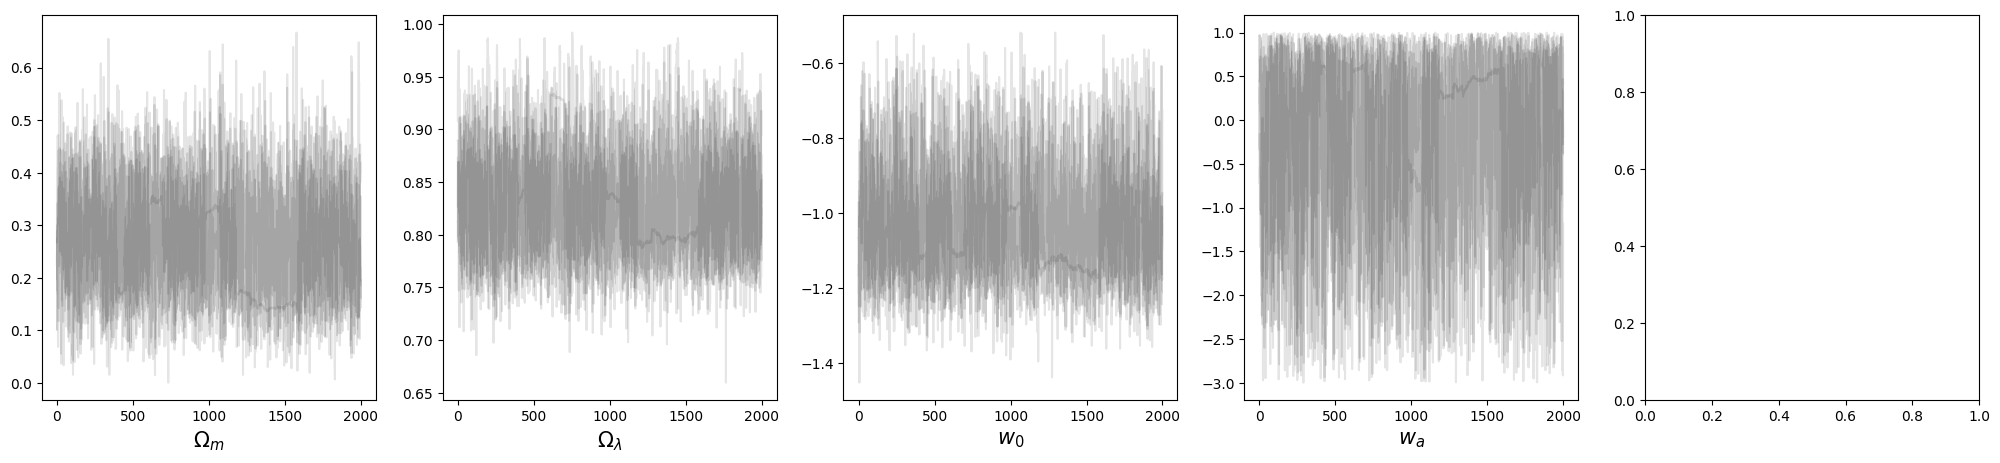

In [118]:
fig,ax = pl.subplots(1,5,figsize=(25,5))
column_list = JAX_chains.columns
#rfind finds the index of the last occurrence of the character in a string: 
column_set = list(set([elem[:elem.rfind('_')] for elem in column_list]))
column_dict = {"OM":0,"Ode":1,'w':2,'wa':3,'Ok':4}
for c_i in JAX_chains.keys():
    c_i_set = c_i[:c_i.rfind('_')]
    try:
        ax[column_dict[c_i_set]].plot(JAX_chains[c_i],c='k',alpha=0.1)
        ax[column_dict[c_i_set]].set_xlabel(label_dict[c_i_set],fontsize=15)
    except KeyError:
        pass 
    #ax[column_dict[c_i_set]].set_title(c_i)
pl.show()

In [85]:
chains.shape

(274, 2000, 9)

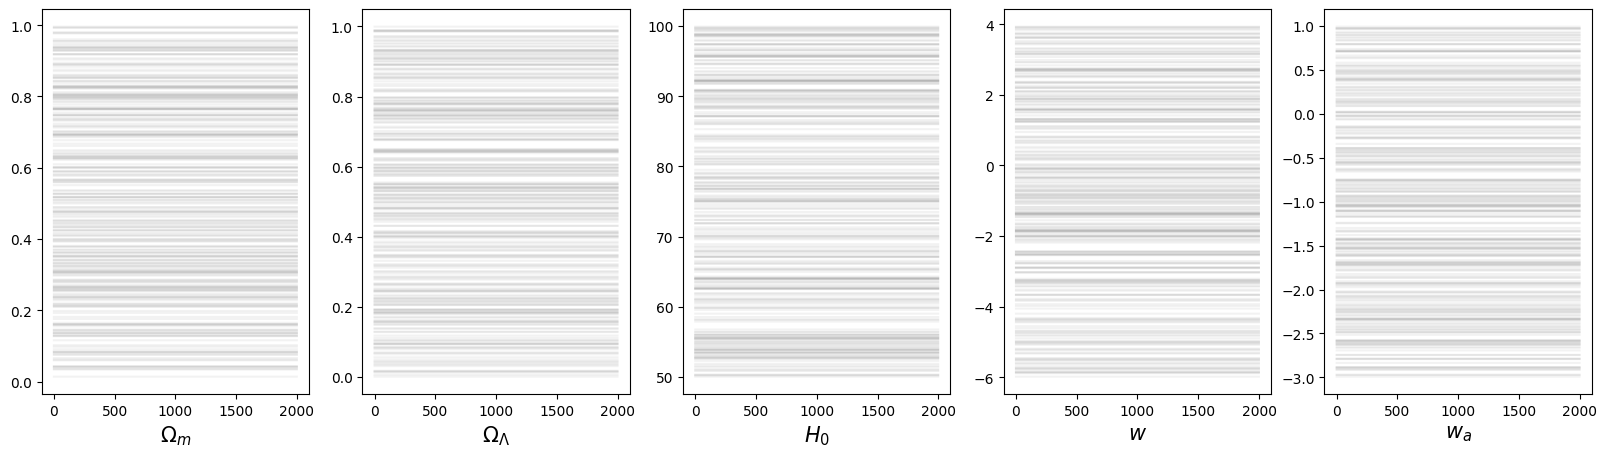

In [84]:
fig,ax = pl.subplots(1,5,figsize=(20,5))
for p_i in range(5):
    for i in range(len(chains)):
        ax[p_i].plot(chains[i,:,p_i],c='k',alpha=0.05)
    if p_i<5: ax[p_i].set_xlabel(['$\Omega_m$','$\Omega_\Lambda$','$H_0$','$w$','$w_a$'][p_i],fontsize=15)
pl.show()

In [ ]:
Perc_list = np.arange(50,102,2).astype('int')
N_samples_list = 2**np.arange(1,11)
#fig,ax = pl.subplots(1,len(Perc_list),figsize=(5*len(Perc_list),5))
fig,ax = pl.subplots(1,4,figsize=(20,5))
mu_dict = {}
si_dict = {}
#for p_i in range(len(Perc_list)):
for p_i in range(len(N_samples_list)):
    chains_i = locate_latest_chains(Errors_perc=1,
                                    N_samples=N_samples_list[p_i],
                                    Perc_true=100,
                                    contamination_str='False',
                                    photometric_str='False',
                                    cosmo_type_str='wCDM')
    N_steps_i = len(chains_i[0,:,0])
    burnin_i = int(0.5*N_steps_i)
    print(f'Found {N_steps_i} steps, using burnin of {burnin_i}')
    try: 
        for c_i,cosmo_prop in enumerate(['Om','Ode','H0','w','wa']): 
            mu_dict[cosmo_prop].append(np.mean(chains_i[:,burnin_i:,c_i]))
            si_dict[cosmo_prop].append(np.std(chains_i[:,burnin_i:,c_i]))
    except:
        for c_i,cosmo_prop in enumerate(['Om','Ode','H0','w','wa']):
            mu_dict[cosmo_prop] = [np.mean(chains_i[:,burnin_i:,c_i])]
            si_dict[cosmo_prop] = [np.std(chains_i[:,burnin_i:,c_i])]

for ii,cosmo_prop in enumerate(['Om','Ode','H0','w','wa']):
#    ax[ii].errorbar(Perc_list,mu_dict[cosmo_prop],yerr=si_dict[cosmo_prop],fmt='.')
    ax[ii].errorbar(N_samples_list,mu_dict[cosmo_prop],yerr=si_dict[cosmo_prop],fmt='.')
#    ax[ii].set_xlabel('% true lenses',fontsize=15)
    ax[ii].set_xlabel('Sample Size',fontsize=15)
    ax[ii].set_xscale('log')
    ax[ii].set_ylabel('$\mu\pm\sigma$',fontsize=15)
    ax[ii].set_title({'Om':'$\Omega_m$','Ode':'$\Omega_\Lambda$','H0':'$H_0$','w':'$w$','wa':'$w_a$'}[cosmo_prop],fontsize=18)
    ax[ii].tick_params(labelsize=10)
#    ax[ii].plot([min(Perc_list),max(Perc_list)],[[Om_fid,Ode_fid,H0_fid,w_fid][ii]]*2,c='k')
    ax[ii].plot([min(N_samples_list),max(N_samples_list)],[[Om_fid,Ode_fid,H0_fid,w_fid,wa_fid][ii]]*2,c='k')

#pl.suptitle('Precision with contaminated sample',fontsize=18)
pl.suptitle('Precision with varying sample size',fontsize=18)
pl.tight_layout()
pl.show()

In [117]:
def squash_walkers(db,exclude=[]):
    column_list = db.columns
    #rfind finds the index of the last occurrence of the character in a string: 
    column_set = list(set([elem[:elem.rfind('_')] for elem in column_list]))
    column_dict = {}
    for c_i in column_list:
        c_i_set = c_i[:c_i.rfind('_')]
        if int(c_i.split('_')[-1]) in exclude:
            print(f'Excluding {c_i}')
            continue
        try:
            column_dict[c_i_set].extend(np.array(db[c_i]))
        except:
            column_dict[c_i_set] = list(db[c_i])
    db_flat = pd.DataFrame(column_dict)
    return db_flat

Excluding OM_0
Excluding Ode_0
Excluding mu_zL_g_L_0
Excluding mu_zS_g_L_0
Excluding sigma_zL_g_L_0
Excluding sigma_zS_g_L_0
Excluding w_0
Excluding wa_0
Excluding zL_0_0
Excluding zL_1_0
Excluding zL_2_0
Excluding zL_3_0
Excluding zL_4_0
Excluding zL_5_0
Excluding zL_6_0
Excluding zL_7_0
Excluding zL_8_0
Excluding zL_9_0
Excluding zL_10_0
Excluding zL_11_0
Excluding zL_12_0
Excluding zL_13_0
Excluding zL_14_0
Excluding zL_15_0
Excluding zL_16_0
Excluding zL_17_0
Excluding zL_18_0
Excluding zL_19_0
Excluding zL_20_0
Excluding zL_21_0
Excluding zL_22_0
Excluding zL_23_0
Excluding zL_24_0
Excluding zL_25_0
Excluding zL_26_0
Excluding zL_27_0
Excluding zL_28_0
Excluding zL_29_0
Excluding zL_30_0
Excluding zL_31_0
Excluding zL_32_0
Excluding zL_33_0
Excluding zL_34_0
Excluding zL_35_0
Excluding zL_36_0
Excluding zL_37_0
Excluding zL_38_0
Excluding zL_39_0
Excluding zL_40_0
Excluding zL_41_0
Excluding zL_42_0
Excluding zL_43_0
Excluding zL_44_0
Excluding zL_45_0
Excluding zL_46_0
Excluding 

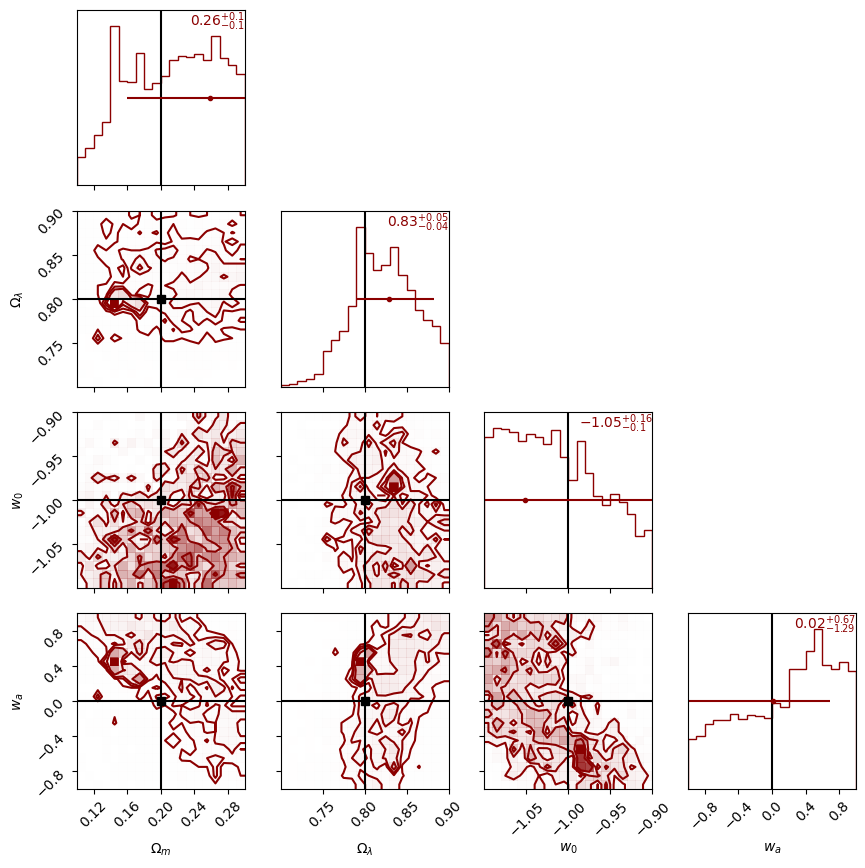

"\nHave shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further\ndemonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most\nimportantly including contamination + photometry.\n"

In [120]:
range_dict = {'OM':(0.1,0.3),'Ode':(0.7,0.9),'Ok':(-1,1),
            'w':(-1.1,-0.9),'wa':(-1,1),
            'mu_zL_g_L':(0,1.5),'mu_zS_g_L':(0,3),
            'mu_zL_g_NL':(0,5),'mu_zS_g_NL':(0,5),
            'sigma_zL_g_L':(0,2),'sigma_zS_g_L':(0,2),
            'sigma_zL_g_NL':(0.1,5),'sigma_zS_g_NL':(0.1,5),
            'zL':(0,1.5),'zS':(0,3),'t':(0,2),'t_mu':(0,2)}
label_dict = {'OM':'$\Omega_m$','Ode':'$\Omega_\lambda$','Ok':'$\Omega_k$',
            'w':'$w_0$','wa':'$w_a$','H0':'H0',
            'mu_zL_g_L':'$\mu_{zL|L}$','mu_zL_g_NL':'$\mu_{zL|NL}$',
            'mu_zS_g_L':'$\mu_{zS|L}$','mu_zS_g_NL':'$\mu_{zS|NL}$',
            'sigma_zL_g_L':'$\sigma_{zL|L}$','sigma_zL_g_NL':'$\sigma_{zL|NL}$',
            'sigma_zS_g_L':'$\sigma_{zS|L}$','sigma_zS_g_NL':'$\sigma_{zS|NL}$',
            't':'Test Sampler','t_mu':'Test Sampler ($\mu$)'}

def del_chains_in_mcmc(mcmc_dict,exclude):
    print(f'Excluding {exclude} from emcee plots')
    for k_ii in mcmc_dict.keys():
        L = mcmc_dict[k_ii].shape[0]
        mcmc_dict[k_ii]=np.delete(mcmc_dict[k_ii],exclude,axis=0)
        assert mcmc_dict[k_ii].shape[0] == L-len(exclude)
    return mcmc_dict

def percentile_str(v,dp=2):
    perc_50 = np.round(np.percentile(v,50),dp).astype('str')
    perc_84_50 =  np.round(np.percentile(v,84)-np.percentile(v,50),dp).astype('str')
    perc_50_16 =  np.round(np.percentile(v,50)-np.percentile(v,16),dp).astype('str')
    return f'${perc_50}'+"_{-"+perc_50_16+"}^{+"+perc_84_50+'}$'

def plot_mu_sig(ax,v,c,y_frac=0.5):
    v=v.flatten()
    perc_50 = np.percentile(v,50)
    perc_84_50 =  float(np.percentile(v,84)-np.percentile(v,50))
    perc_50_16 =  float(np.percentile(v,50)-np.percentile(v,16))
    ylim = ax.get_ylim()
    ax.errorbar(perc_50,y_frac*ylim[1],xerr=np.array([[perc_50_16,perc_84_50]]).T,fmt='.',c=c)
    ax.set_ylim(ylim)

def plot_emcee_corner(MCMC_chain_dict = {},key_list = [],
                    truth_dict={},range_dict={},label_dict = {},bin_dict = {},
                    burnin=np.nan,exclude=[]):
    MCMC_chain_dict = del_chains_in_mcmc(MCMC_chain_dict,exclude)
    corner_array = np.array([MCMC_chain_dict[k_i][:,burnin:] for k_i in key_list]).T
    label_list = [label_dict[k_i] for k_i in key_list]
    truth_list = [truth_dict[k_i] for k_i in key_list]
    range_list = [range_dict[k_i] for k_i in key_list]
    #bin_list = [bin_dict[k_i] for k_i in key_list]
    fig,ax = pl.subplots(len(key_list),len(key_list),figsize=(2.2*len(key_list),2.2*len(key_list)))
    corner.corner(corner_array,
                    truths = truth_list,
                    truth_color='k',
                    contour_kwargs = {'colors':'k'},
                    labels = label_list,
                    label_kwargs={'fontsize':18},
                    range = range_list,
                    fig=fig,
                    hist_kwargs={'density':True},
                    plot_datapoints=False)#,show_titles=True)
    for p_i in range(corner_array.shape[2]):
        ax[p_i,p_i].text(0,1,percentile_str(corner_array[:,:,p_i]),
                        horizontalalignment='left',
                        verticalalignment='top',
                        color='k',
                        transform=ax[p_i,p_i].transAxes,
                        fontsize=10)
        plot_mu_sig(ax[p_i,p_i],corner_array[:,:,p_i],c='k',y_frac=0.4)
    hist_ylim=[]
    for i in range(len(ax)):
        for j in range(len(ax)):
            if i!=j:
                ax[i,j].set_xlim(ax[j,j].get_xlim())
                ax[i,j].set_ylim(ax[i,i].get_xlim())
            else:
                hist_ylim.append(ax[i,j].get_ylim())
    pl.tight_layout()
    return fig,ax,hist_ylim

def plot_JAX_corner(sampler_list,
                    truth_dict={},range_dict={},label_dict = {},bin_dict = {},
                    key_list=[],legend_list=[],plot_Ok=False,fig=None,ax=[],burnin=np.nan,hist_ylim=[],exclude_walker_list=[]):
    if not isinstance(sampler_list, list):
        print('Making into a list')
        sampler_list=[sampler_list]
    if len(key_list)==0: #Plotting all except zL, zS 
        key_list=list(sampler_list[0].columns)
        try:key_list.remove('zL');key_list.remove('zS')
        except: pass
    print('Keys:',key_list)
    print('NOTE: Need to change this so the bins cover the whole prior:')
    #N_chains = sampler_list[0].num_chains
    for s_i,sampler in enumerate(sampler_list):
        corner_samples = sampler[key_list]
        if plot_Ok:
            Ok = np.array([1-(sampler['OM']+sampler['Ode'])])
            sampler['Ok'] = Ok
            key_list.append('Ok')
        #if len(exclude_walker_list)>0: print(f'Excluding {len(exclude_walker_list)} walkers from the plot')
        #corner_samples=np.delete(corner_samples,exclude_walker_list,axis=1)
        if s_i == len(sampler_list)-1: truths=[truth_dict[k] for k in key_list]
        else: truths=None
        if fig is None: 
            fig,ax = pl.subplots(len(key_list),len(key_list),figsize=(2.2*len(key_list),2.2*len(key_list)))
            truth_list = [truth_dict[k_i] for k_i in key_list]
        corner.corner(corner_samples,
            truths=truth_list,
            truth_color='k',
            labels=[label_dict[k_i] for k_i in key_list],
            fig=fig,
            color=['darkred','darkgreen','purple','darkblue'][s_i],
            range=[range_dict[k_i] for k_i in key_list],
            hist_kwargs={'density':True},
            plot_datapoints=False)#,show_titles=True)
        for p_i in range(np.array(corner_samples).shape[1]):
            ax[p_i,p_i].text(1,1,percentile_str(np.array(corner_samples)[:,p_i]),
                        horizontalalignment='right',
                        verticalalignment='top',
                        color='darkred',
                        transform=ax[p_i,p_i].transAxes,
                        fontsize=10)
            plot_mu_sig(ax[p_i,p_i],np.array(corner_samples)[:,p_i],c='darkred')
    if len(hist_ylim)!=0:
        for ii in range(len(ax)):
            ax_ymax = np.max([ax[ii,ii].get_ylim()[1],hist_ylim[ii][1]])
            ax[ii,ii].set_ylim(top=ax_ymax)
    pl.tight_layout()     
    if len(legend_list)!=0: ax[0,0].legend(legend_list,fontsize=8)
    if plot_Ok: print("Note: Ok is not an independent variable, so shouldn't be plotted as if it is.")
    return fig,ax

# fig,ax,hist_ylim = plot_emcee_corner(
#     MCMC_chain_dict = {'OM':chains[:,:,0],
#                        'Ode':chains[:,:,1],
#                        'H0':chains[:,:,2],
#                        'w':chains[:,:,3],
#                        'wa':chains[:,:,4]
#     },
#     key_list = ['OM','w','wa'],
#     truth_dict = {'OM':Om_fid,'Ode':Ode_fid,'w':w_fid,'wa':wa_fid},
#     range_dict = range_dict,
#     label_dict = label_dict,
#     #bin_dict = bin_dict,
#     burnin=1000,
#     exclude=[])#[0])

plot_JAX_corner(squash_walkers(JAX_chains,exclude = [0]),#[5,11,28,43,45,48]),
                truth_dict = {'OM':Om_fid,'Ode':Ode_fid,'w':w_fid,'wa':wa_fid},
                range_dict = range_dict,
                label_dict = label_dict,
                #bin_dict = bin_dict,
                key_list=['OM','Ode','w','wa'],
                legend_list=[],plot_Ok=False,
#                fig=fig,ax=ax,
                burnin=500,
                #hist_ylim=hist_ylim
                )

pl.show()

'''
Have shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further
demonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most
importantly including contamination + photometry.
'''

In [53]:
JAX_chains.columns

Index(['OM_0', 'OM_1', 'OM_2', 'OM_3', 'OM_4', 'OM_5', 'OM_6', 'OM_7', 'OM_8',
       'OM_9', 'Ode_0', 'Ode_1', 'Ode_2', 'Ode_3', 'Ode_4', 'Ode_5', 'Ode_6',
       'Ode_7', 'Ode_8', 'Ode_9', 'w_0', 'w_1', 'w_2', 'w_3', 'w_4', 'w_5',
       'w_6', 'w_7', 'w_8', 'w_9', 'wa_0', 'wa_1', 'wa_2', 'wa_3', 'wa_4',
       'wa_5', 'wa_6', 'wa_7', 'wa_8', 'wa_9'],
      dtype='object')

In [ ]:
from scipy.stats import norm

In [ ]:
dist.Normal(loc=0,scale=1).log_prob(1),np.log(norm.pdf(0,1,1))

(Array(-1.4189385, dtype=float32, weak_type=True), -1.4189385332046727)

In [ ]:
def JAX_samples_to_dict(sampler,separate_keys=False):
    key_list = sampler.get_samples().keys()
    sample_dict = {}
    for k_i in key_list:
        if not separate_keys: 
            assert sampler.get_samples()[k_i].shape[1]==1 and len(sampler.get_samples()[k_i].shape)==2
            sample_dict[k_i] = sampler.get_samples()[k_i].T[0]
        else: 
            print(k_i,sampler.get_samples(True)[k_i].shape)
            if k_i!='Ok': assert sampler.get_samples(True)[k_i].shape[2]==1 and len(sampler.get_samples(True)[k_i].shape)==3
            for c_i in range(sampler.get_samples(True)[k_i].shape[0]):
                try:
                    sample_dict[f'{k_i}_{c_i}'] = sampler.get_samples(True)[k_i][c_i,:,0]
                except:
                    #May require this exception if using FlatwCDM or FlatLambdaCDM
                    assert k_i=='Ok' and len(sampler.get_samples(True)[k_i].shape)==2
                    sample_dict[f'{k_i}_{c_i}'] = sampler.get_samples(True)[k_i][c_i,:]
    return sample_dict



In [ ]:
corner.hist2d?

Signature:
corner.hist2d(
    x,
    y,
    bins=20,
    range=None,
    axes_scale=['linear', 'linear'],
    weights=None,
    levels=None,
    smooth=None,
    ax=None,
    color=None,
    quiet=False,
    plot_datapoints=True,
    plot_density=True,
    plot_contours=True,
    no_fill_contours=False,
    fill_contours=False,
    contour_kwargs=None,
    contourf_kwargs=None,
    data_kwargs=None,
    pcolor_kwargs=None,
    new_fig=True,
    force_range=False,
    **kwargs,
)
Docstring:
Plot a 2-D histogram of samples.

Parameters
----------
x : array_like[nsamples,]
   The samples.

y : array_like[nsamples,]
   The samples.

axes_scale : iterable (2,)
    Scale (``"linear"``, ``"log"``) to use for each dimension.

quiet : bool
    If true, suppress warnings for small datasets.

levels : array_like
    The contour levels to draw.

ax : matplotlib.Axes
    A axes instance on which to add the 2-D histogram.

plot_datapoints : bool
    Draw the individual data points.

plot_density : b

In [ ]:
try: del ndim
except: pass
if contamination_str=='False' and photometric_str=='False':
    ndim = 5 #5 cosmo
elif contamination_str=='True' and photometric_str=='False':
    ndim = 5 #5 cosmo
elif contamination_str=='False' and photometric_str=='True':
    ndim = 9 #5 cosmo, 2 means, 2 sigma
elif contamination_str=='True' and photometric_str=='True':
    ndim = 13 #5 cosmo, 4 means, 4 sigma

chains_db = pd.DataFrame(chains[:,burnin:,:].reshape(-1,ndim),
                columns = ['$\Omega_m$','$\Omega_\Lambda$','$H_0$','$w$','$w_a$']
                +['$\mu_{LgL}$','$\mu_{SgL}$']*(photometric_str=='True')
                +['$\mu_{LgNL}$','$\mu_{SgNL}$']*(photometric_str=='True' and contamination_str=='True')
                +['$\sigma_{LgL}$','$\sigma_{SgL}$']*(photometric_str=='True')
                +['$\sigma_{LgNL}$','$\sigma_{SgNL}$']*(photometric_str=='True' and contamination_str=='True'))

chains_db.describe()#.loc[['count','mean','std']]

,$\Omega_m$,$\Omega_\Lambda$,$H_0$,$w$
count,212000.000000,212000.000000,212000.000000,212000.000000
mean,0.216964,0.778158,102.820536,-0.738987
std,0.111407,0.113485,54.031359,1.035421
min,0.037709,0.000030,10.012989,-1.164650
25%,0.177580,0.783142,57.354548,-1.024180
50%,0.200743,0.798900,98.675689,-0.997172
75%,0.224235,0.813757,149.815734,-0.969148
max,0.999681,0.993240,199.997918,3.867543
